In [39]:
# !pip install --upgrade pip
# !pip install natsort
# !pip install albumentations
# !pip install wandb
# !pip install torchinfo
# !pip install schema
# !pip install torchmetrics
# !pip install einops
# !pip install timm
# !pip install natsort
# !pip install torchsummary
# !pip install natsort

## Cell 1 - Imports and Base Setup:

In [40]:
import os
import sys
from pathlib import Path
from typing import Dict, List, Optional, Union, Tuple
from abc import ABC, abstractmethod

# Add CellViT to python path first
cellvit_path = "/rsrch5/home/plm/yshokrollahi/CellViT"
if cellvit_path not in sys.path:
    sys.path.append(cellvit_path)
    print(f"Added {cellvit_path} to Python path")

import yaml
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import albumentations as A

try:
    from cell_segmentation.datasets.pannuke import PanNukeDataset
    from cell_segmentation.datasets.tissuenet import TissueNetDataset
    print("Successfully imported CellViT modules")
except ImportError as e:
    print(f"Import error: {e}")
    raise

Successfully imported CellViT modules


## Cell 2 - Base Dataset Class:

In [41]:
class BaseModalityDataset(Dataset, ABC):
    """Base class for all modality datasets"""
    
    def __init__(self, dataset_path: Path, split: str, transforms=None):
        self.dataset_path = dataset_path
        self.split = split
        self.transforms = transforms
        self.modality_type = self._get_modality_type()
        
    @abstractmethod
    def _get_modality_type(self) -> str:
        """Return the modality type identifier"""
        pass
    
    def standardize_output(self, image, targets, metadata) -> Dict:
        """Standardize the output format across all modalities"""
        return {
            'image': image,
            'metadata': {
                'modality_type': self.modality_type,
                'available_targets': self._get_available_targets(),
                **metadata
            },
            'targets': targets
        }
    
    @abstractmethod
    def _get_available_targets(self) -> List[str]:
        """Return list of available target types for this modality"""
        pass
    
    @abstractmethod
    def __len__(self):
        pass
    
    @abstractmethod
    def __getitem__(self, idx):
        pass

## Cell 3 - TissueNet Standardized Implementation:

In [42]:
from pathlib import Path
from typing import Dict, List, Optional, Union, Tuple
import numpy as np
import torch
from scipy.ndimage import center_of_mass
from abc import ABC, abstractmethod

class TissueNetStandardized(BaseModalityDataset):
    def __init__(self, dataset_path: Path, split: str, transforms=None, **kwargs):
        super().__init__(dataset_path, split, transforms)
        self.dataset = TissueNetDataset(
            dataset_path=dataset_path,
            split=split,
            transforms=transforms,
            stardist=False,
            regression=False,
            cache_dataset=False,
            **kwargs
        )
    
    def _get_modality_type(self) -> str:
        return 'tissuenet'
    
    def _get_available_targets(self) -> List[str]:
        return ['nuclei', 'membrane', 'hv_maps']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data = self.dataset[idx]
        
        if isinstance(data, (tuple, list)):
            image = data[0]
            original_targets = data[1]
        else:
            image = data['image']
            original_targets = data.get('targets', {})
        
        standardized_targets = {
            'masks': {
                'nuclei': original_targets.get('nuclei_mask', None),
                'membrane': original_targets.get('cell_mask', None)
            },
            'semantic': {
                'has_membrane': True
            },
            'hv_maps': {
                'nuclei': original_targets.get('nuclei_hv_map', None),
                'membrane': original_targets.get('cell_hv_map', None)
            }
        }
        
        metadata = {
            'original_size': image.shape[-2:],
        }
        
        return self.standardize_output(image, standardized_targets, metadata)

## Cell 4 - PanNuke Standardized Implementation:

In [43]:
from pathlib import Path
from typing import Dict, List, Optional, Union, Tuple
import numpy as np
import torch
from scipy.ndimage import center_of_mass
from abc import ABC, abstractmethod

class PanNukeStandardized(BaseModalityDataset):
    def __init__(self, dataset_path: Path, split: str, transforms=None, folds=None, val_ratio=0.1):
        super().__init__(dataset_path, split, transforms)
        
        # Keep existing initialization
        if split == 'test':
            self.dataset = PanNukeDataset(
                dataset_path=dataset_path,
                folds=[2],
                transforms=transforms,
                stardist=False,
                regression=False,
                cache_dataset=False
            )
            self.indices = list(range(len(self.dataset)))
        else:
            self.dataset = PanNukeDataset(
                dataset_path=dataset_path,
                folds=[0, 1],
                transforms=transforms,
                stardist=False,
                regression=False,
                cache_dataset=False
            )
            total_len = len(self.dataset)
            val_size = int(total_len * val_ratio)
            train_size = total_len - val_size
            all_indices = list(range(total_len))
            
            if split == 'train':
                self.indices = all_indices[:train_size]
            else:  # val
                self.indices = all_indices[train_size:]
        
        # Cell type mappings
        self.cell_types = {
            0: 'Background',
            1: 'Neoplastic',
            2: 'Inflammatory',
            3: 'Connective',
            4: 'Dead',
            5: 'Epithelial'
        }
        
        # Tissue types remain the same
        self.tissue_types = {
            'Breast': 0, 'Colon': 1, 'Liver': 2, 'Kidney': 3,
            'Prostate': 4, 'Bladder': 5, 'Ovarian': 6, 'Uterus': 7,
            'Thyroid': 8, 'Testis': 9, 'Lung': 10, 'Esophagus': 11,
            'Skin': 12, 'Head&Neck': 13, 'Bile-duct': 14, 'Stomach': 15,
            'Pancreatic': 16, 'Adrenal': 17
        }
        
        # Initialize sampling related attributes
        self.cell_counts = None
        self.tissue_counts = None
        
    def load_cell_count(self):
        """Calculate number of actual instances of each cell type"""
        if self.cell_counts is not None:
            return

        self.cell_counts = {i: 0 for i in range(1, len(self.cell_types))}

        for idx in self.indices:
            data = self.dataset[idx]
            if isinstance(data, (tuple, list)):
                targets = data[1]
            else:
                targets = data.get('targets', {})

            cell_types = targets.get('nuclei_type_map', None)
            if cell_types is not None:
                # Count actual instances using return_counts
                unique_types, counts = np.unique(cell_types, return_counts=True)
                for cell_type, count in zip(unique_types, counts):
                    if cell_type > 0 and cell_type in self.cell_counts:
                        self.cell_counts[cell_type] += count  # Add actual count, not just 1

        print("Total instances of each cell type:")
        for cell_type, count in self.cell_counts.items():
            print(f"{self.cell_types[cell_type]}: {count} instances")



    
    def get_sampling_weights_cell(self, gamma=1.0):
        """Calculate sampling weights based on cell type instances"""
        if self.cell_counts is None:
            self.load_cell_count()

        weights = np.zeros(len(self), dtype=np.float32)
        total_instances = sum(self.cell_counts.values())

        for i, idx in enumerate(self.indices):
            data = self.dataset[idx]
            if isinstance(data, (tuple, list)):
                targets = data[1]
            else:
                targets = data.get('targets', {})

            cell_types = targets.get('nuclei_type_map', None)

            if cell_types is not None:
                unique_types, type_counts = np.unique(cell_types, return_counts=True)
                weight = 0
                for cell_type, count in zip(unique_types, type_counts):
                    if cell_type > 0 and cell_type in self.cell_counts and self.cell_counts[cell_type] > 0:
                        # Weight based on instance count ratio
                        instance_ratio = total_instances / (len(self.cell_counts) * self.cell_counts[cell_type])
                        weight += count * (instance_ratio ** gamma)
                weights[i] = weight if weight > 0 else 1.0
            else:
                weights[i] = 1.0

        # Normalize weights
        weights = weights / weights.sum()
        return weights

    # Keep all existing methods
    def _get_modality_type(self) -> str:
        return 'pannuke'
    
    def _get_available_targets(self) -> List[str]:
        return ['cell', 'cell_types', 'hv_maps']
    
    def gen_instance_hv_map(self, inst_map: np.ndarray) -> np.ndarray:
        """Generate horizontal and vertical maps"""
        if len(inst_map.shape) != 2:
            raise ValueError(f"Instance map should be 2D, got shape {inst_map.shape}")

        x_map = np.zeros(inst_map.shape[:2], dtype=np.float32)
        y_map = np.zeros(inst_map.shape[:2], dtype=np.float32)

        inst_list = list(np.unique(inst_map))
        if 0 in inst_list:
            inst_list.remove(0)

        for inst_id in inst_list:
            inst = (inst_map == inst_id).astype(np.uint8)
            
            rows = np.any(inst, axis=1)
            cols = np.any(inst, axis=0)
            if not np.any(rows) or not np.any(cols):
                continue
                
            y1, y2 = np.where(rows)[0][[0, -1]]
            x1, x2 = np.where(cols)[0][[0, -1]]
            
            inst_crop = inst[y1:y2+1, x1:x2+1]
            
            if inst_crop.shape[0] < 2 or inst_crop.shape[1] < 2:
                continue

            cy, cx = center_of_mass(inst_crop)
            
            y_coords, x_coords = np.mgrid[0:inst_crop.shape[0], 0:inst_crop.shape[1]]
            
            x_coords = (x_coords - cx) / (inst_crop.shape[1] - 1) * 2
            y_coords = (y_coords - cy) / (inst_crop.shape[0] - 1) * 2
            
            x_coords[inst_crop == 0] = 0
            y_coords[inst_crop == 0] = 0
            
            x_map[y1:y2+1, x1:x2+1][inst_crop > 0] = x_coords[inst_crop > 0]
            y_map[y1:y2+1, x1:x2+1][inst_crop > 0] = y_coords[inst_crop > 0]

        return np.stack([x_map, y_map])
    
    def get_cell_type_name(self, type_idx: int) -> str:
        """Convert cell type index to name"""
        return self.cell_types.get(type_idx, f'Unknown Type {type_idx}')
    
    def get_tissue_type_id(self, tissue_name: str) -> int:
        """Convert tissue name to ID"""
        return self.tissue_types.get(tissue_name, -1)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        data = self.dataset[self.indices[idx]]

        if isinstance(data, (tuple, list)):
            image = data[0]
            original_targets = data[1]
            tissue_type = data[2]
            img_name = data[3]
        else:
            image = data['image']
            original_targets = data.get('targets', {})
            tissue_type = None
            img_name = None

        # Update cell type handling to account for background class
        cell_mask = original_targets.get('instance_map', None)
        cell_types = original_targets.get('nuclei_type_map', None)
        
        # Add 1 to cell types to shift classes (0->1, 1->2, etc.) to match new mapping
        if cell_types is not None:
            if cell_mask is not None:
                cell_types[cell_mask == 0] = 0  # Just ensure background is 0

        cell_hv_map = self.gen_instance_hv_map(cell_mask.numpy()) if cell_mask is not None else None
        tissue_type_id = self.get_tissue_type_id(tissue_type) if tissue_type else None

        standardized_targets = {
            'masks': {
                'cell': cell_mask,
            },
            'semantic': {
                'cell_types': cell_types,
                'tissue_type': tissue_type_id,
                'has_membrane': False
            },
            'hv_maps': {
                'cell': torch.tensor(cell_hv_map) if cell_hv_map is not None else None
            }
        }

        metadata = {
            'original_size': image.shape[-2:],
            'fold': getattr(self.dataset, 'current_fold', None),
            'tissue_type': tissue_type,
            'tissue_type_id': tissue_type_id,
            'img_name': img_name,
            'cell_type_mapping': self.cell_types,
            'tissue_type_mapping': self.tissue_types
        }

        return self.standardize_output(image, standardized_targets, metadata)

## Cell 5 - Enhanced Dataset Manager:

In [65]:
class ModularDatasetManager:
    def __init__(self):
        # Dataset paths
        self.tissuenet_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/tissuenet")
        self.pannuke_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble")
        
        # Config paths
        self.tissuenet_config_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/examples/cell_segmentation/vitaminp-tissuenet.yaml")
        self.pannuke_config_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/examples/cell_segmentation/pannuke-vitaminp.yaml")
        
        self._load_configs()
        self.datasets = {}

    def print_dataset_info(self, split: str):
        """Print information about datasets for a given split"""
        print(f"\nDataset information for split '{split}':")
        for modality, splits in self.datasets.items():
            if split in splits:
                print(f"{modality}: {len(splits[split])} samples")
    
    def _load_configs(self):
        try:
            with open(self.tissuenet_config_path, 'r') as file:
                self.tissuenet_config = yaml.safe_load(file)
            with open(self.pannuke_config_path, 'r') as file:
                self.pannuke_config = yaml.safe_load(file)
            print("Successfully loaded configuration files")
        except Exception as e:
            print(f"Error loading configs: {e}")
            raise

    def get_transforms(self, transform_settings, input_shape=256):
        transforms = []
        if input_shape != 256:
            transforms.append(A.Resize(input_shape, input_shape))
        
        transforms.extend([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Downscale(scale_min=0.5, scale_max=1.0, p=0.15),
            A.Blur(blur_limit=9, p=0.2),
            A.GaussNoise(var_limit=50, p=0.25),
            A.ElasticTransform(p=0.2),
        ])
        
        if 'normalize' in transform_settings:
            transforms.append(A.Normalize(**transform_settings['normalize']))
        
        return A.Compose(transforms)

    @staticmethod
    def custom_collate_fn(batch):
       images = []
       masks = {
           'nuclei': [],
           'membrane': [],
           'cell': []
       }
       semantic = {
           'has_membrane': [],
           'cell_types': [],
           'tissue_type': []
       }
       metadata = {
           'original_channels': [],
           'sample_metadata': []
       }
       hv_maps = {
           'nuclei': [],
           'membrane': [],
           'cell': []
       }

       max_channels = max(item['image'].shape[0] for item in batch)

       for item in batch:
           # Handle image
           image = item['image']
           metadata['original_channels'].append(image.shape[0])
           if image.shape[0] < max_channels:
               padding = torch.zeros((max_channels - image.shape[0], *image.shape[1:]), 
                                  dtype=image.dtype, device=image.device)
               image = torch.cat([image, padding], dim=0)
           images.append(image)

           # Handle masks
           for mask_type in masks:
               if mask_type in item['targets']['masks'] and item['targets']['masks'][mask_type] is not None:
                   mask = item['targets']['masks'][mask_type]
                   if mask.dim() == 2:
                       mask = mask.unsqueeze(0)
                   masks[mask_type].append(mask)
               else:
                   zero_mask = torch.zeros((1, *image.shape[-2:]), 
                                        dtype=image.dtype, 
                                        device=image.device)
                   masks[mask_type].append(zero_mask)

           # Handle HV maps
           if 'hv_maps' in item['targets']:
               for hv_type in hv_maps:
                   if hv_type in item['targets']['hv_maps']:
                       hv_maps[hv_type].append(item['targets']['hv_maps'][hv_type])
                   else:
                       zero_map = torch.zeros((2, *image.shape[-2:]), 
                                           dtype=image.dtype, 
                                           device=image.device)
                       hv_maps[hv_type].append(zero_map)
           else:
               for hv_type in hv_maps:
                   zero_map = torch.zeros((2, *image.shape[-2:]), 
                                       dtype=image.dtype, 
                                       device=image.device)
                   hv_maps[hv_type].append(zero_map)

           # Handle cell_types
           if 'cell_types' in item['targets']['semantic']:
               cell_types = item['targets']['semantic']['cell_types']
               if cell_types.dim() == 2:
                   semantic['cell_types'].append(cell_types)
               else:
                   zeros = torch.zeros((*image.shape[-2:],), dtype=torch.long, device=image.device)
                   semantic['cell_types'].append(zeros)
           else:
               zeros = torch.zeros((*image.shape[-2:],), dtype=torch.long, device=image.device)
               semantic['cell_types'].append(zeros)
    
            
           # Boolean values
           has_membrane = item['targets']['semantic'].get('has_membrane', False)
           semantic['has_membrane'].append(torch.tensor(has_membrane, dtype=torch.bool))

           # Tissue type
           tissue_type = item['targets']['semantic'].get('tissue_type', 0)
           semantic['tissue_type'].append(torch.tensor(tissue_type, dtype=torch.long))

           metadata['sample_metadata'].append(item['metadata'])

       try:
           batch_dict = {
               'image': torch.stack(images),
               'targets': {
                   'masks': {},
                   'semantic': {},
                   'hv_maps': {}
               },
               'metadata': {
                   'original_channels': metadata['original_channels'],
                   'padded_channels': max_channels,
                   'sample_metadata': metadata['sample_metadata']
               }
           }

           # Stack masks
           for mask_type, mask_list in masks.items():
               if any(x is not None for x in mask_list):
                   batch_dict['targets']['masks'][mask_type] = torch.stack(mask_list)

           # Stack HV maps
           for hv_type, maps in hv_maps.items():
               if any(x is not None for x in maps):
                   batch_dict['targets']['hv_maps'][hv_type] = torch.stack(maps)

           # Stack semantic data
           batch_dict['targets']['semantic']['cell_types'] = torch.stack(semantic['cell_types'])
           batch_dict['targets']['semantic']['has_membrane'] = torch.stack(semantic['has_membrane'])
           batch_dict['targets']['semantic']['tissue_type'] = torch.stack(semantic['tissue_type'])

           return batch_dict

       except Exception as e:
           print("Error in collate function:", str(e))
           print("Image shapes:", [img.shape for img in images])
           print("Mask shapes:", {k: [m.shape for m in v] for k, v in masks.items()})
           print("HV map shapes:", {k: [m.shape for m in v] for k, v in hv_maps.items()})
           print("Semantic values:", semantic)
           raise e

    def setup_datasets(self):
        print("\nSetting up datasets...")

        # Setup TissueNet
        train_transforms = self.get_transforms(self.tissuenet_config['transformations'])
        val_transforms = A.Compose([
            A.Normalize(**self.tissuenet_config['transformations']['normalize'])
        ])

        self.datasets['tissuenet'] = {
            'train': TissueNetStandardized(
                dataset_path=self.tissuenet_path,
                split='train',
                transforms=train_transforms
            ),
            'val': TissueNetStandardized(
                dataset_path=self.tissuenet_path,
                split='val',
                transforms=val_transforms
            ),
            'test': TissueNetStandardized(
                dataset_path=self.tissuenet_path,
                split='test',
                transforms=val_transforms
            )
        }

        # Setup PanNuke with explicit test set
        self.datasets['pannuke'] = {
            'train': PanNukeStandardized(
                dataset_path=self.pannuke_path,
                split='train',
                transforms=train_transforms,
                val_ratio=0.1  # 10% for validation
            ),
            'val': PanNukeStandardized(
                dataset_path=self.pannuke_path,
                split='val',
                transforms=val_transforms,
                val_ratio=0.1
            ),
            'test': PanNukeStandardized(  # Add test split using fold [2]
                dataset_path=self.pannuke_path,
                split='test',
                transforms=val_transforms
            )
        }

        print("Dataset setup completed!")
        return self.datasets

    def get_dataloader(self, modality: str, split: str, batch_size: int = 32) -> DataLoader:
        dataset = self.datasets[modality][split]

        # Add weighted sampling for PanNuke training
        if modality == 'pannuke' and split == 'train':
            # Calculate weights for cell type balancing
            dataset.load_cell_count()  # This will now count actual instances
            weights = dataset.get_sampling_weights_cell(gamma=1.0)
            sampler = WeightedRandomSampler(
                weights=weights,
                num_samples=len(weights),
                replacement=True
            )
            return DataLoader(
                dataset,
                batch_size=batch_size,
                sampler=sampler,  # Use weighted sampler
                num_workers=4,
                pin_memory=True,
                collate_fn=self.custom_collate_fn
            )
        else:
            # Keep original loader for other cases
            return DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=(split == 'train'),
                num_workers=4,
                pin_memory=True,
                collate_fn=self.custom_collate_fn
            )

    def get_combined_dataloader(self, split: str, batch_size: int = 32) -> DataLoader:
        """
        Create a balanced combined dataloader that ensures samples from both datasets
        """
        from torch.utils.data import Dataset
        from torch.utils.data import WeightedRandomSampler

        class BalancedConcatDataset(Dataset):
            def __init__(self, datasets, batch_size):
                self.datasets = datasets
                self.batch_size = batch_size
                self.lengths = [len(d) for d in datasets]
                self.total_length = max(self.lengths) * len(datasets)

                # Calculate weights for PanNuke dataset if in training
                self.weights = []
                if split == 'train':
                    for dataset in datasets:
                        if hasattr(dataset, 'load_cell_count'):  # PanNuke dataset
                            dataset.load_cell_count()
                            self.weights.extend(dataset.get_sampling_weights_cell(gamma=1.0))
                        else:  # TissueNet dataset
                            self.weights.extend([1.0] * len(dataset))

            def __len__(self):
                return self.total_length

            def __getitem__(self, idx):
                # Determine which dataset to sample from
                dataset_idx = idx % len(self.datasets)
                # Get item from the corresponding dataset
                item_idx = idx // len(self.datasets) % self.lengths[dataset_idx]
                return self.datasets[dataset_idx][item_idx]

        # Create list of datasets for the given split
        datasets = [
            self.datasets[modality][split]
            for modality in self.datasets
            if split in self.datasets[modality]
        ]

        combined_dataset = BalancedConcatDataset(datasets, batch_size)

        if split == 'train':
            sampler = WeightedRandomSampler(
                weights=combined_dataset.weights,
                num_samples=len(combined_dataset.weights),
                replacement=True
            )

            return DataLoader(
                combined_dataset,
                batch_size=batch_size,
                sampler=sampler,  # Use weighted sampler for training
                num_workers=4,
                pin_memory=True,
                collate_fn=self.custom_collate_fn
            )
        else:
            return DataLoader(
                combined_dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=4,
                pin_memory=True,
                collate_fn=self.custom_collate_fn
            )

In [66]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# First cell - Run this only once to set up datasets
def setup_datasets_and_loaders(batch_size=16):
    manager = ModularDatasetManager()
    datasets = manager.setup_datasets()
    
    # Create all dataloaders
    loaders = {
        'mif': {
            'train': manager.get_dataloader('tissuenet', 'train', batch_size),
            'val': manager.get_dataloader('tissuenet', 'val', batch_size),
            'test': manager.get_dataloader('tissuenet', 'test', batch_size)
        },
        'he': {
            'train': manager.get_dataloader('pannuke', 'train', batch_size),
            'val': manager.get_dataloader('pannuke', 'val', batch_size),
            'test': manager.get_dataloader('pannuke', 'test', batch_size)
        },
        'combined': {
            'train': manager.get_combined_dataloader('train', batch_size),
            'val': manager.get_combined_dataloader('val', batch_size)
        }
    }
    
    return manager, datasets, loaders

# Run this once
manager, datasets, loaders = setup_datasets_and_loaders(batch_size=16)

Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!
Total instances of each cell type:
Neoplastic: 25849638 instances
Inflammatory: 5501366 instances
Connective: 11362104 instances
Dead: 208185 instances
Epithelial: 7875026 instances


## Validate class imbalence

Validating sampling balance...

Checking HE dataloader balance:

Batch 1 distribution:
Neoplastic: 1475 (19.67%)
Inflammatory: 1543 (20.58%)
Connective: 1492 (19.90%)
Dead: 1482 (19.77%)
Epithelial: 1506 (20.09%)

Batch 2 distribution:
Neoplastic: 3428 (19.94%)
Inflammatory: 3531 (20.54%)
Connective: 3422 (19.90%)
Dead: 3397 (19.76%)
Epithelial: 3414 (19.86%)

Batch 3 distribution:
Neoplastic: 5877 (19.78%)
Inflammatory: 6001 (20.20%)
Connective: 5930 (19.96%)
Dead: 5929 (19.96%)
Epithelial: 5970 (20.10%)

Batch 4 distribution:
Neoplastic: 7665 (19.61%)
Inflammatory: 7823 (20.02%)
Connective: 7785 (19.92%)
Dead: 7860 (20.11%)
Epithelial: 7947 (20.34%)

Batch 5 distribution:
Neoplastic: 9834 (19.68%)
Inflammatory: 9917 (19.85%)
Connective: 9889 (19.79%)
Dead: 10049 (20.11%)
Epithelial: 10275 (20.56%)

Batch 6 distribution:
Neoplastic: 11374 (19.47%)
Inflammatory: 11518 (19.71%)
Connective: 11619 (19.88%)
Dead: 11834 (20.25%)
Epithelial: 12086 (20.68%)

Batch 7 distribution:
Neoplastic: 

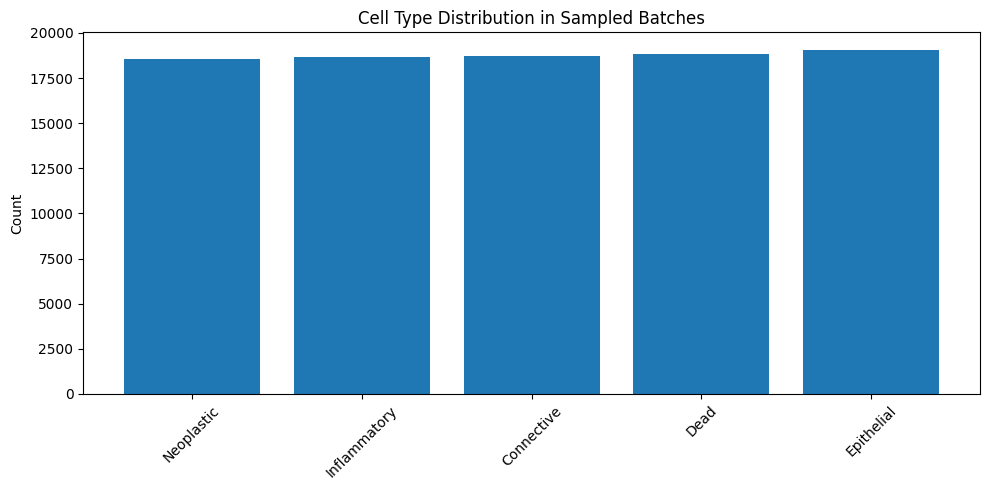

In [103]:
def validate_sampling_balance(loaders, num_batches=10):
    print("Validating sampling balance...")
    
    # Track cell type distributions
    cell_type_counts = {
        1: {'name': 'Neoplastic', 'count': 0},
        2: {'name': 'Inflammatory', 'count': 0},
        3: {'name': 'Connective', 'count': 0},
        4: {'name': 'Dead', 'count': 0},
        5: {'name': 'Epithelial', 'count': 0}
    }
    
    # Sample batches from HE loader
    he_loader = loaders['he']['train']
    print("\nChecking HE dataloader balance:")
    
    for i, batch in enumerate(he_loader):
        if i >= num_batches:
            break
            
        # Get cell types from batch
        cell_types = batch['targets']['semantic']['cell_types']
        
        # Count instances
        for cell_type in range(1, 6):
            count = torch.sum(cell_types[:, cell_type]).item()
            cell_type_counts[cell_type]['count'] += count
        
        print(f"\nBatch {i+1} distribution:")
        total_batch = sum(cell_type_counts[t]['count'] for t in cell_type_counts)
        for cell_type in cell_type_counts:
            count = cell_type_counts[cell_type]['count']
            name = cell_type_counts[cell_type]['name']
            percentage = (count / total_batch * 100) if total_batch > 0 else 0
            print(f"{name}: {count} ({percentage:.2f}%)")
    
    # Plot distribution
    plt.figure(figsize=(10, 5))
    names = [info['name'] for info in cell_type_counts.values()]
    counts = [info['count'] for info in cell_type_counts.values()]
    
    plt.bar(names, counts)
    plt.title('Cell Type Distribution in Sampled Batches')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    return cell_type_counts

# Run validation
cell_counts = validate_sampling_balance(loaders)


Detailed Cell Type Statistics:
----------------------------------------
Neoplastic:
  Count: 58818
  Percentage: 27.33%

Inflammatory:
  Count: 67279
  Percentage: 31.26%

Connective:
  Count: 35411
  Percentage: 16.46%

Dead:
  Count: 13701
  Percentage: 6.37%

Epithelial:
  Count: 39985
  Percentage: 18.58%



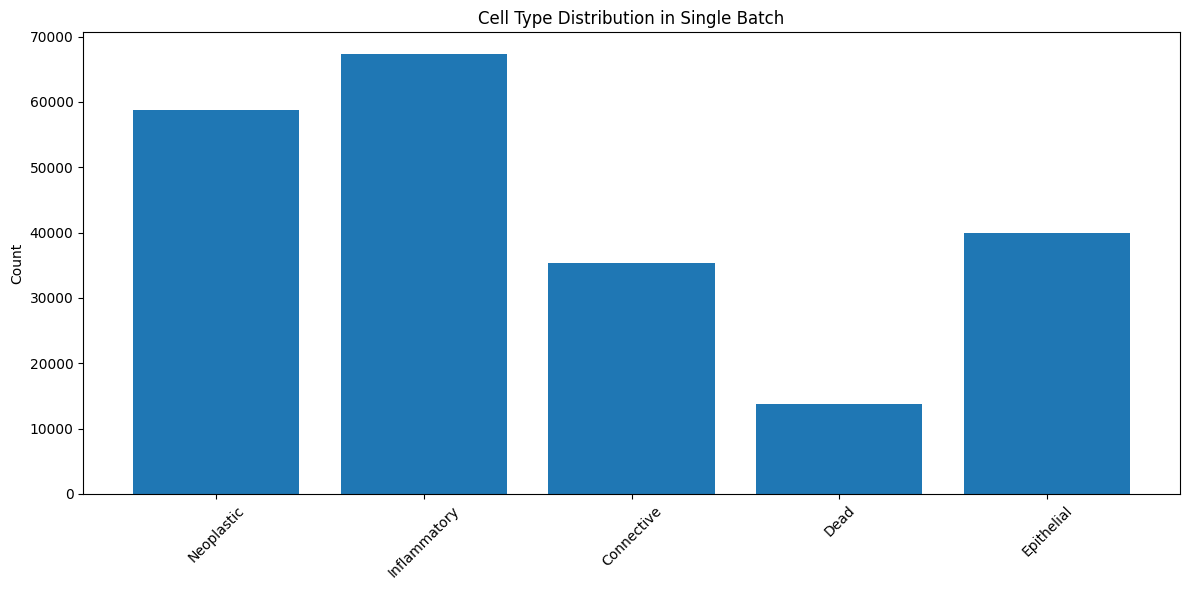

In [104]:
def visualize_single_batch(loader):
    # Get single batch
    batch = next(iter(loader))
    
    # Get cell types from batch
    cell_types = batch['targets']['semantic']['cell_types']
    
    # Initialize counters
    cell_type_counts = {
        1: {'name': 'Neoplastic', 'count': 0},
        2: {'name': 'Inflammatory', 'count': 0},
        3: {'name': 'Connective', 'count': 0},
        4: {'name': 'Dead', 'count': 0},
        5: {'name': 'Epithelial', 'count': 0}
    }
    
    # Count instances
    for cell_type in range(1, 6):
        count = torch.sum(cell_types == cell_type).item()
        cell_type_counts[cell_type]['count'] = count
    
    # Calculate percentages
    total = sum(info['count'] for info in cell_type_counts.values())
    
    # Plot using matplotlib
    plt.figure(figsize=(12, 6))
    
    # Bar chart
    names = [info['name'] for info in cell_type_counts.values()]
    counts = [info['count'] for info in cell_type_counts.values()]
    plt.bar(names, counts)
    plt.title('Cell Type Distribution in Single Batch')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    
    # Print detailed statistics
    print("\nDetailed Cell Type Statistics:")
    print("-" * 40)
    for cell_type, info in cell_type_counts.items():
        percentage = (info['count'] / total * 100) if total > 0 else 0
        print(f"{info['name']}:")
        print(f"  Count: {info['count']}")
        print(f"  Percentage: {percentage:.2f}%")
        print()
    
    plt.tight_layout()
    plt.show()

# Usage:
visualize_single_batch(loaders['he']['train'])

In [90]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import Counter

# def analyze_pannuke_class_balance(manager):
#     """
#     Analyze class distribution in PanNuke dataset
#     """
#     # Get PanNuke training dataset
#     pannuke_train = manager.datasets['pannuke']['train']
    
#     # Initialize counters
#     cell_type_counts = {
#         0: "Background",
#         1: "Neoplastic",
#         2: "Inflammatory",
#         3: "Connective",
#         4: "Dead",
#         5: "Epithelial"
#     }
#     counts = {name: 0 for name in cell_type_counts.values()}
    
#     # Get sampling weights if they exist
#     if hasattr(pannuke_train, 'load_cell_count'):
#         pannuke_train.load_cell_count()
#         weights = pannuke_train.get_sampling_weights_cell(gamma=1.0)
#         print("Sampling weights are being used!")
#     else:
#         weights = None
#         print("No sampling weights found!")

#     # Count cell types
#     print("\nAnalyzing cell type distribution...")
#     for idx in range(len(pannuke_train)):
#         sample = pannuke_train[idx]
#         cell_types = sample['targets']['semantic']['cell_types']
        
#         # Convert tensor to numpy for counting
#         if isinstance(cell_types, torch.Tensor):
#             cell_types = cell_types.numpy()
        
#         # Count each cell type
#         for type_idx, count in enumerate(cell_types):
#             if type_idx > 0:  # Skip background
#                 if np.any(count > 0):  # Check if any value is greater than 0
#                     counts[cell_type_counts[type_idx]] += 1

#     # Visualize distribution
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
#     # Plot cell type distribution
#     names = list(counts.keys())[1:]  # Exclude background
#     values = [counts[name] for name in names]
    
#     ax1.bar(names, values)
#     ax1.set_title('Cell Type Distribution in PanNuke Dataset')
#     ax1.set_xticklabels(names, rotation=45)
#     ax1.set_ylabel('Count')
    
#     # Plot weight distribution if available
#     if weights is not None:
#         ax2.hist(weights, bins=50)
#         ax2.set_title('Distribution of Sampling Weights')
#         ax2.set_xlabel('Weight Value')
#         ax2.set_ylabel('Frequency')
    
#     plt.tight_layout()
#     plt.show()

#     # Print statistics
#     print("\nClass Distribution Statistics:")
#     total = sum(values)
#     print("\nAbsolute counts:")
#     for name, count in zip(names, values):
#         print(f"{name}: {count}")
    
#     print("\nPercentages:")
#     for name, count in zip(names, values):
#         percentage = (count / total) * 100
#         print(f"{name}: {percentage:.2f}%")

#     if weights is not None:
#         print("\nWeight Statistics:")
#         print(f"Min weight: {min(weights):.4f}")
#         print(f"Max weight: {max(weights):.4f}")
#         print(f"Mean weight: {np.mean(weights):.4f}")
#         print(f"Median weight: {np.median(weights):.4f}")

#         # Calculate correlation between class frequency and weights
#         print("\nAnalyzing weight distribution per class...")
#         class_weights = {}
#         for idx in range(len(pannuke_train)):
#             sample = pannuke_train[idx]
#             cell_types = sample['targets']['semantic']['cell_types']
#             if isinstance(cell_types, torch.Tensor):
#                 cell_types = cell_types.numpy()
            
#             # Find the dominant cell type (excluding background)
#             dominant_type = np.argmax(cell_types[1:]) + 1
#             class_weights.setdefault(cell_type_counts[dominant_type], []).append(weights[idx])
        
#         print("\nMean weight per class:")
#         for class_name, class_weight_list in class_weights.items():
#             mean_weight = np.mean(class_weight_list)
#             print(f"{class_name}: {mean_weight:.4f}")

#     return counts, weights

# # Usage
# if __name__ == "__main__":
#     # Initialize your dataset manager
#     manager = ModularDatasetManager()
#     datasets = manager.setup_datasets()
    
#     # Analyze class balance
#     counts, weights = analyze_pannuke_class_balance(manager)

In [91]:
# from torch.utils.data import DataLoader, WeightedRandomSampler

# # Initialize the dataset manager
# manager = ModularDatasetManager()
# manager.setup_datasets()

# # Get the PanNuke training dataset
# pannuke_dataset = manager.datasets['pannuke']['train']

# # Load and print cell counts (now shows images containing each cell type)
# pannuke_dataset.load_cell_count()

# # Calculate sampling weights
# weights = pannuke_dataset.get_sampling_weights_cell(gamma=1.0)

# # Create sampler
# sampler = WeightedRandomSampler(
#     weights=weights,
#     num_samples=len(weights),
#     replacement=True
# )

# # Create test dataloader with the sampler
# test_loader = DataLoader(
#     pannuke_dataset,
#     batch_size=8,
#     sampler=sampler,
#     num_workers=4,
#     pin_memory=True,
#     collate_fn=manager.custom_collate_fn
# )

# # Test a few batches and count class presence
# class_presence = {i: 0 for i in range(1, 6)}  # Only counting cell types, not background
# num_test_batches = 10

# print("\nChecking cell type presence in sampled batches:")
# for i, batch in enumerate(test_loader):
#     if i >= num_test_batches:
#         break
        
#     cell_types = batch['targets']['semantic']['cell_types']
#     for type_vec in cell_types:
#         for class_idx, is_present in enumerate(type_vec[1:], 1):  # Skip background
#             if is_present:
#                 class_presence[class_idx] += 1

# print("\nNumber of images containing each cell type in sampled batches:")
# for class_idx, count in class_presence.items():
#     class_name = pannuke_dataset.cell_types[class_idx]
#     print(f"{class_name}: {count} images")

## Cell 6 - Usage Example:

In [92]:
# print("\nTesting combined loader...")
# # Create manager and setup datasets if not already done
# manager = ModularDatasetManager()
# manager.setup_datasets()

# # Print dataset sizes
# manager.print_dataset_info('train')

# # Test the loader
# combined_train_loader = manager.get_combined_dataloader('train', batch_size=4)
# batch = next(iter(combined_train_loader))

# print("\nBatch structure:")
# print("Image shape:", batch['image'].shape)
# print("Available masks:", list(batch['targets']['masks'].keys()))
# print("Available semantic:", list(batch['targets']['semantic'].keys()))
# print("Sample semantic values:", {k: v.shape if isinstance(v, torch.Tensor) else v 
#                                 for k, v in batch['targets']['semantic'].items()})

# print("\nMask shapes:")
# for mask_type, mask_tensor in batch['targets']['masks'].items():
#     print(f"{mask_type}: {mask_tensor.shape}")

# print("\nOriginal channels per sample:")
# original_channels = batch['metadata']['original_channels']
# for idx, channels in enumerate(original_channels):
#     dataset_type = "PanNuke" if channels == 3 else "TissueNet"
#     print(f"Sample {idx}: {channels} channels ({dataset_type})")

# print("\nSemantic values per sample:")
# for idx in range(batch['image'].shape[0]):
#     print(f"\nSample {idx}:")
#     for key in batch['targets']['semantic']:
#         if batch['targets']['semantic'][key] is not None:
#             value = batch['targets']['semantic'][key][idx]
#             print(f"  {key}: {value}")

# print("\nMask statistics:")
# for mask_type, mask_tensor in batch['targets']['masks'].items():
#     non_zero = torch.count_nonzero(mask_tensor).item()
#     total = mask_tensor.numel()
#     print(f"{mask_type}:")
#     print(f"  - Non-zero elements: {non_zero}")
#     print(f"  - Coverage: {(non_zero/total)*100:.2f}%")

In [93]:


# # Check all splits
# print("\nChecking all splits:")
# for split in ['train', 'val', 'test']:
#     manager.print_dataset_info(split)

In [94]:
# # Check raw data from the base dataset
# pannuke_train = manager.datasets['pannuke']['train']
# raw_data = pannuke_train.dataset[0]  # Get first sample from base dataset
# print("\nRaw data structure:", type(raw_data))
# if isinstance(raw_data, tuple):
#     print("Tuple contents:", [type(x) for x in raw_data])
#    # Print the actual cell type information
#     masks = raw_data[1]
#     print("\nAvailable mask keys:", masks.keys())
#     print("\nNuclei type map shape:", masks['nuclei_type_map'].shape)
#     print("Unique cell types in nuclei_type_map:", torch.unique(masks['nuclei_type_map']))

# elif isinstance(raw_data, dict):
#     print("Dict keys:", raw_data.keys())

# # Check cell type mapping
# print("\nCell type mapping:", pannuke_train.cell_types)


TissueNet Samples:


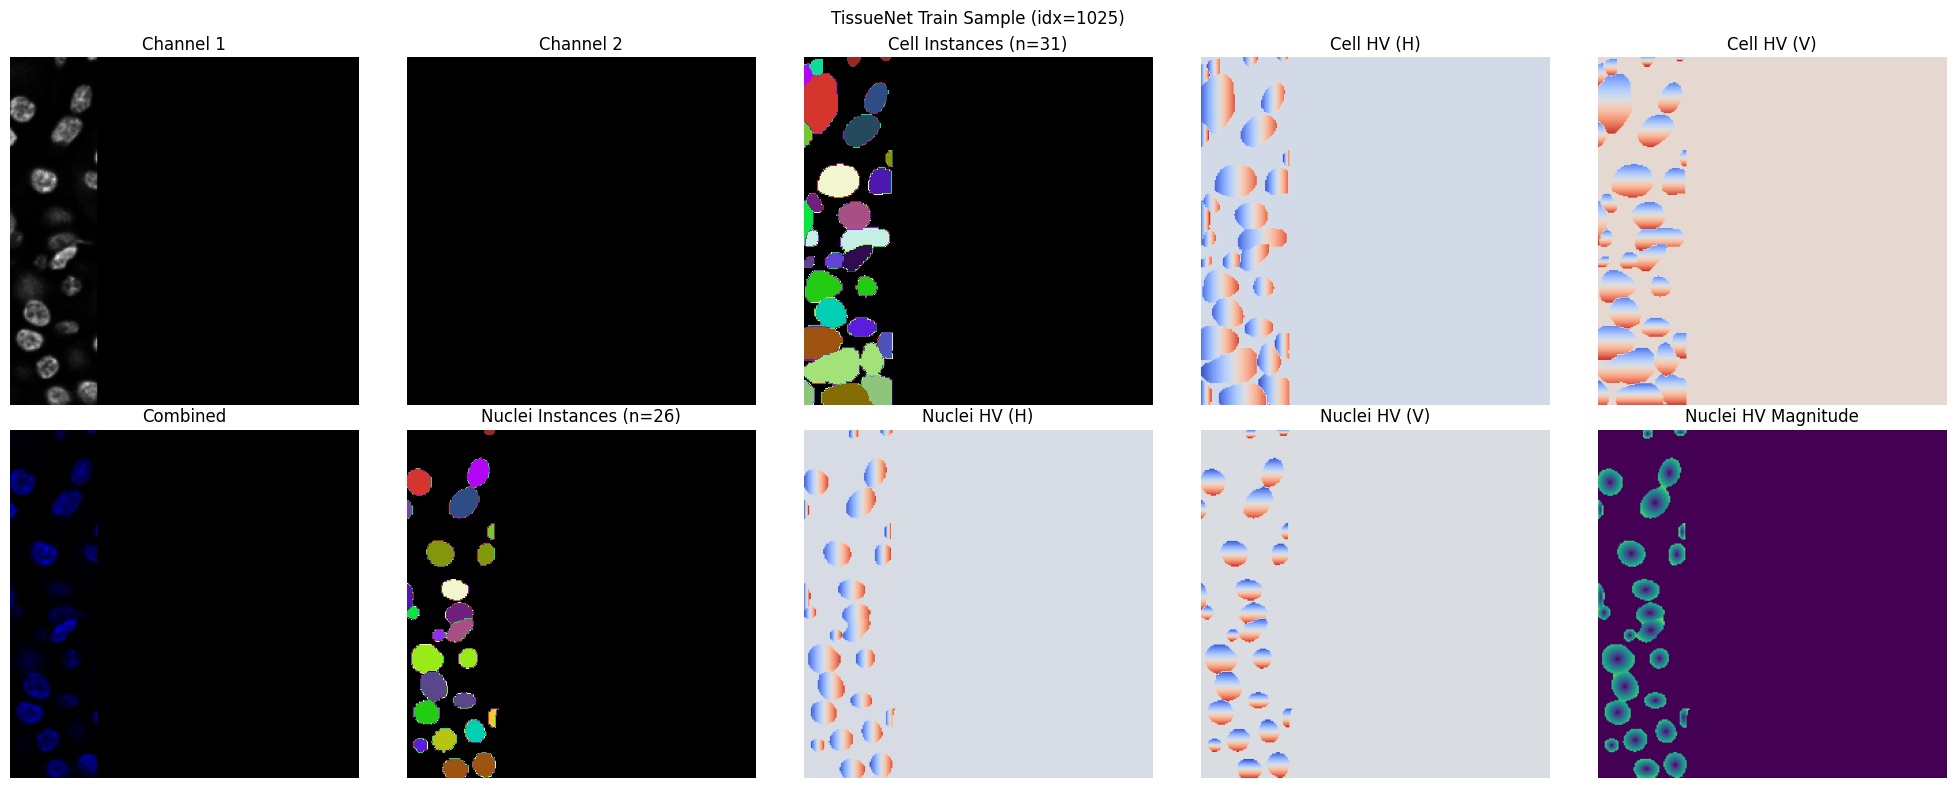

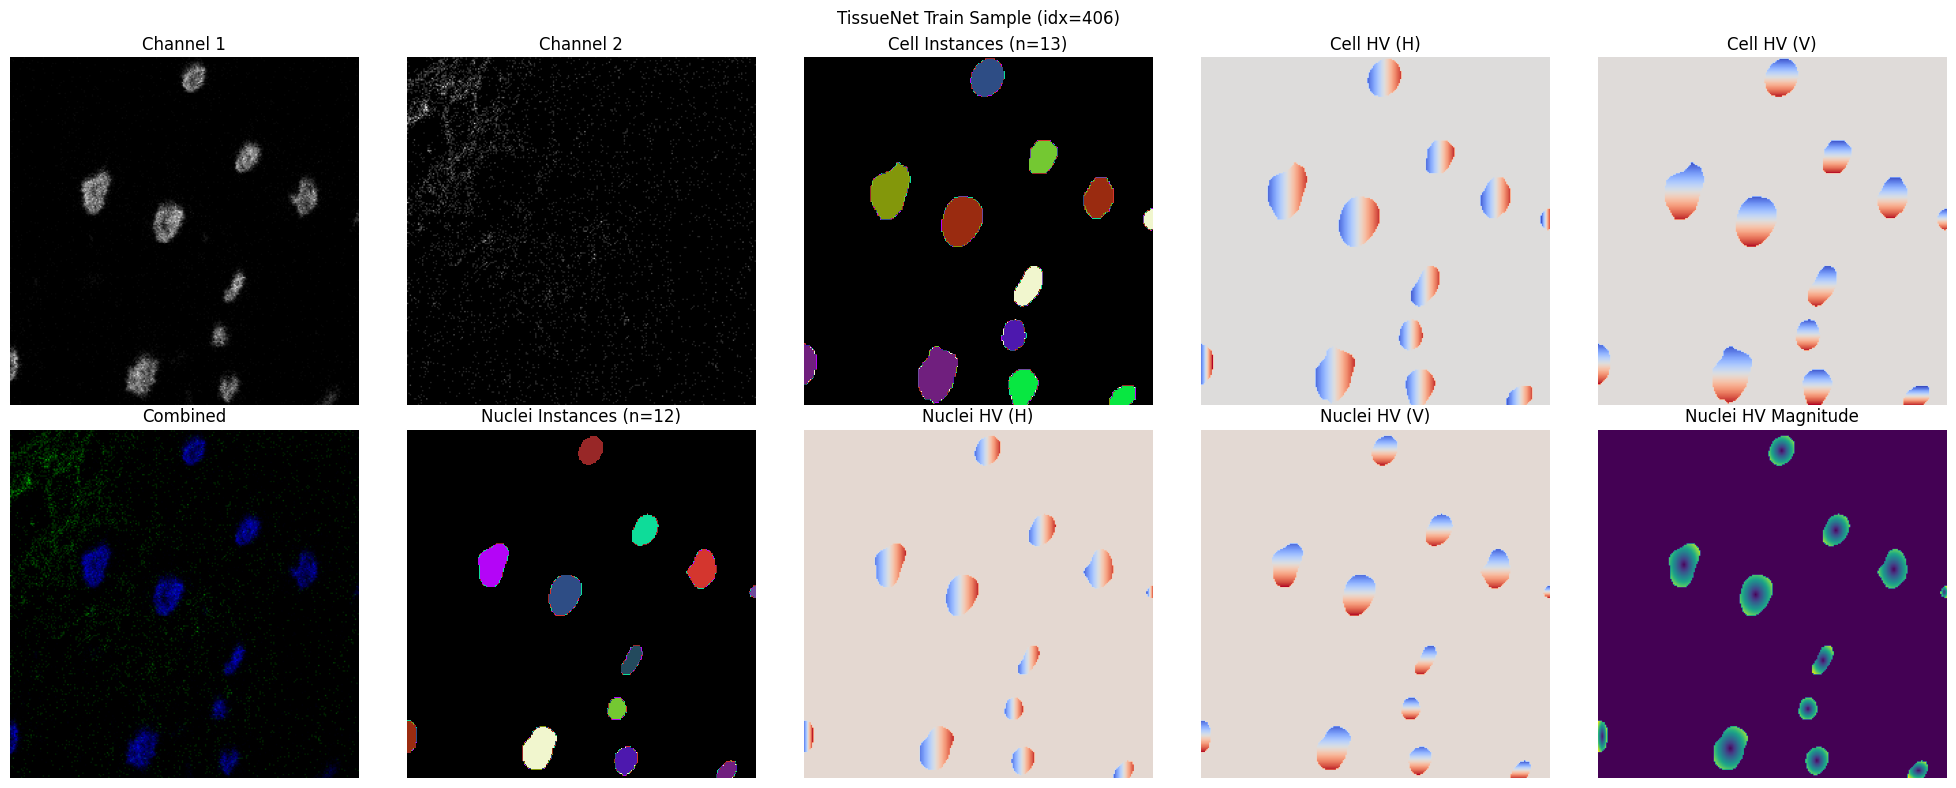


PanNuke Samples:


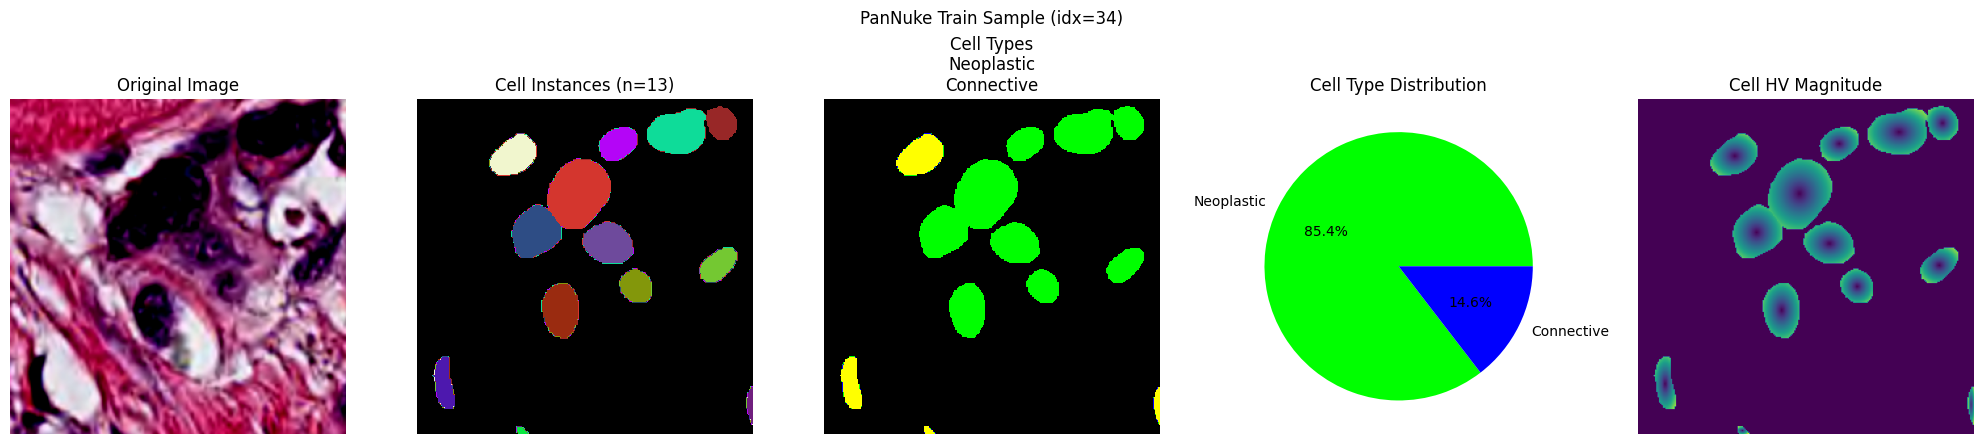

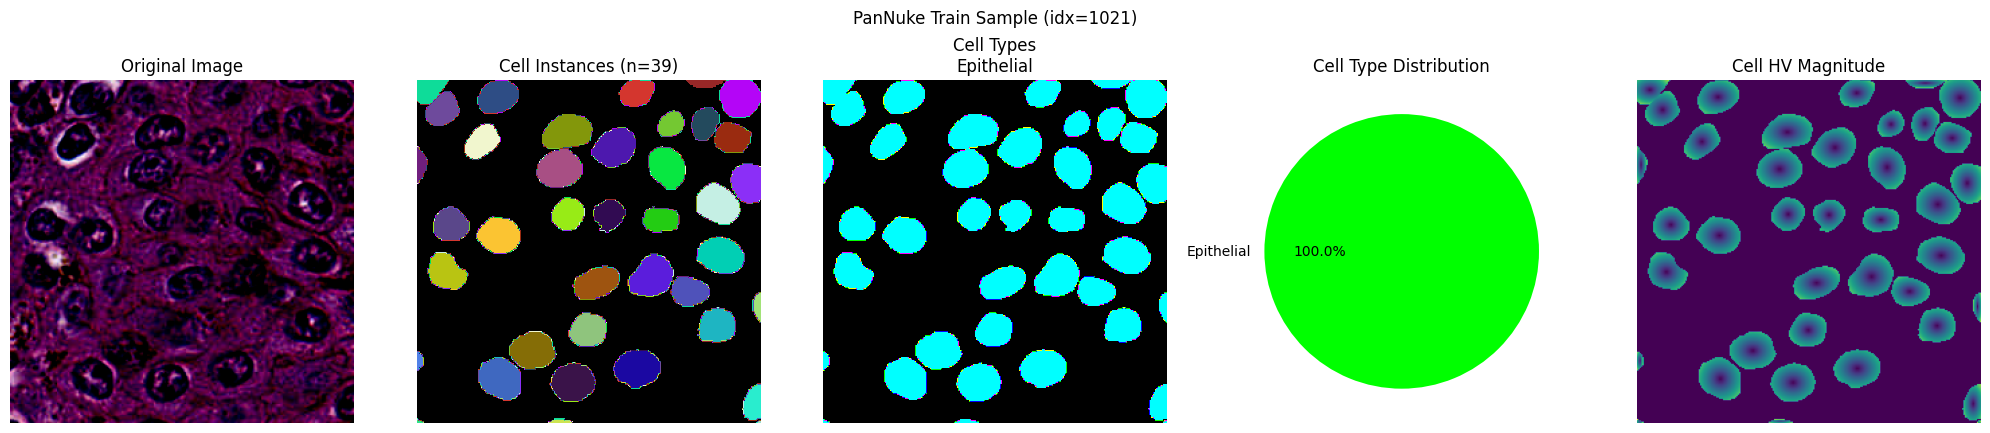

In [102]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.colors import ListedColormap

def create_random_colormap(n_instances):
    """Create a colormap with random distinct colors"""
    np.random.seed(42)  # For reproducibility
    colors = np.random.rand(n_instances + 1, 3)  # +1 for background
    colors[0] = [0, 0, 0]  # Background black
    return ListedColormap(colors)

def get_cell_type_name(type_idx):
    """Convert cell type index to name for PanNuke dataset"""
    class_names = {
        0: "Background",
        1: "Neoplastic",
        2: "Inflammatory",
        3: "Connective",
        4: "Dead",
        5: "Epithelial"
    }
    return class_names.get(type_idx, f'Unknown Type {type_idx}')

def get_cell_type_color(type_idx):
    """Get color for cell type"""
    type_colors = {
        0: 'black',      # Background
        1: '#00FF00',    # Neoplastic
        2: 'blue',       # Inflammatory
        3: 'yellow',     # Connective
        4: 'magenta',    # Dead
        5: 'cyan'        # Epithelial
    }
    return type_colors.get(type_idx, 'gray')

def visualize_sample(sample, title):
    """Visualize a single sample with its masks, HV maps and magnitude"""
    plt.figure(figsize=(20, 8))
    image = sample['image']
    
    if image.shape[0] == 2:  # TissueNet
        # Channel 1
        plt.subplot(251)
        img_ch1 = image[0].numpy()
        if img_ch1.max() > 1:
            img_ch1 = img_ch1 / img_ch1.max()
        plt.imshow(img_ch1, cmap='gray')
        plt.title('Channel 1')
        plt.axis('off')
        
        # Channel 2
        plt.subplot(252)
        img_ch2 = image[1].numpy()
        if img_ch2.max() > 1:
            img_ch2 = img_ch2 / img_ch2.max()
        plt.imshow(img_ch2, cmap='gray')
        plt.title('Channel 2')
        plt.axis('off')
        
        # Cell/Membrane mask
        plt.subplot(253)
        membrane_mask = sample['targets']['masks']['membrane']
        cell_types = sample['targets']['semantic'].get('cell_types', None)
        if membrane_mask is not None:
            n_instances = len(np.unique(membrane_mask.numpy()))
            random_cmap = create_random_colormap(n_instances)
            plt.imshow(membrane_mask, cmap=random_cmap)
            title_str = f'Cell Instances (n={n_instances-1})'
            if cell_types is not None:
                type_idx = cell_types.item() if isinstance(cell_types, torch.Tensor) else cell_types
                title_str += f'\n{get_cell_type_name(type_idx)}'
                plt.imshow(membrane_mask, cmap=ListedColormap([get_cell_type_color(0), get_cell_type_color(type_idx)]))
            plt.title(title_str)
        plt.axis('off')
        
        # Cell HV horizontal
        if 'membrane' in sample['targets'].get('hv_maps', {}):
            plt.subplot(254)
            plt.imshow(sample['targets']['hv_maps']['membrane'][0], cmap='coolwarm')
            plt.title('Cell HV (H)')
            plt.axis('off')
            
            # Cell HV vertical
            plt.subplot(255)
            plt.imshow(sample['targets']['hv_maps']['membrane'][1], cmap='coolwarm')
            plt.title('Cell HV (V)')
            plt.axis('off')
        
        # Combined view
        plt.subplot(256)
        img_ch1 = np.clip((img_ch1 - img_ch1.min()) / (img_ch1.max() - img_ch1.min() + 1e-8), 0, 1)
        img_ch2 = np.clip((img_ch2 - img_ch2.min()) / (img_ch2.max() - img_ch2.min() + 1e-8), 0, 1)
        
        combined_img = np.dstack([
            np.zeros_like(img_ch1),
            img_ch2 * 0.8,
            img_ch1
        ])
        plt.imshow(combined_img)
        plt.title('Combined')
        plt.axis('off')
        
        # Nuclei mask
        plt.subplot(257)
        nuclei_mask = sample['targets']['masks']['nuclei']
        if nuclei_mask is not None:
            n_instances = len(np.unique(nuclei_mask.numpy()))
            random_cmap = create_random_colormap(n_instances)
            plt.imshow(nuclei_mask, cmap=random_cmap)
            plt.title(f'Nuclei Instances (n={n_instances-1})')
        plt.axis('off')
        
        # Nuclei HV maps
        if 'nuclei' in sample['targets'].get('hv_maps', {}):
            plt.subplot(258)
            plt.imshow(sample['targets']['hv_maps']['nuclei'][0], cmap='coolwarm')
            plt.title('Nuclei HV (H)')
            plt.axis('off')
            
            plt.subplot(259)
            plt.imshow(sample['targets']['hv_maps']['nuclei'][1], cmap='coolwarm')
            plt.title('Nuclei HV (V)')
            plt.axis('off')
            
            plt.subplot(2,5,10)
            nuclei_hv = sample['targets']['hv_maps']['nuclei']
            nuclei_hv_magnitude = np.sqrt(nuclei_hv[0]**2 + nuclei_hv[1]**2)
            plt.imshow(nuclei_hv_magnitude, cmap='viridis')
            plt.title('Nuclei HV Magnitude')
            plt.axis('off')
            
    else:  # PanNuke
        # Original image
        plt.subplot(251)
        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.title('Original Image')
        plt.axis('off')
        
        # Instance mask
        plt.subplot(252)
        cell_mask = sample['targets']['masks']['cell']
        if cell_mask is not None:
            n_instances = len(np.unique(cell_mask.numpy()))
            random_cmap = create_random_colormap(n_instances)
            plt.imshow(cell_mask, cmap=random_cmap)
            plt.title(f'Cell Instances (n={n_instances-1})')
            plt.axis('off')
        
        # Cell types visualization
        plt.subplot(253)
        cell_types = sample['targets']['semantic']['cell_types']
        if isinstance(cell_types, torch.Tensor):
            if cell_types.dim() == 1:  # One-hot encoded vector
                # Create a color-coded mask based on the one-hot vector
                type_map = np.zeros_like(cell_mask.numpy())
                for type_idx, is_present in enumerate(cell_types, 1):
                    if is_present:
                        type_map[cell_mask.numpy() > 0] = type_idx
                
                unique_types = np.unique(type_map)
                colors = [get_cell_type_color(t) for t in range(max(unique_types) + 1)]
                plt.imshow(type_map, cmap=ListedColormap(colors))
                plt.title('Cell Types\n' + '\n'.join([get_cell_type_name(t) 
                                                     for t in unique_types if t != 0]))
            else:  # 2D tensor (original format)
                type_map = cell_types.numpy()
                unique_types = np.unique(type_map)
                colors = [get_cell_type_color(t) for t in range(max(unique_types) + 1)]
                plt.imshow(type_map, cmap=ListedColormap(colors))
                plt.title('Cell Types\n' + '\n'.join([get_cell_type_name(t) 
                                                     for t in unique_types if t != 0]))
        plt.axis('off')
        
        # Type distribution pie chart
        plt.subplot(254)
        if isinstance(cell_types, torch.Tensor):
            if cell_types.dim() == 1:  # One-hot encoded vector
                type_counts = {get_cell_type_name(i+1): count.item() 
                             for i, count in enumerate(cell_types) if count > 0}
            else:  # 2D tensor
                unique_types = np.unique(type_map)
                type_counts = {get_cell_type_name(t): (type_map == t).sum() 
                             for t in unique_types if t != 0}
            
            if type_counts:
                colors = [get_cell_type_color(t) for t in range(1, len(type_counts) + 1)]
                plt.pie(type_counts.values(), labels=type_counts.keys(), 
                       autopct='%1.1f%%', colors=colors)
                plt.title('Cell Type Distribution')
        
        # HV maps
        if 'cell' in sample['targets'].get('hv_maps', {}):
            plt.subplot(255)
            cell_hv = sample['targets']['hv_maps']['cell']
            cell_hv_magnitude = np.sqrt(cell_hv[0]**2 + cell_hv[1]**2)
            plt.imshow(cell_hv_magnitude, cmap='viridis')
            plt.title('Cell HV Magnitude')
            plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Test visualizations
# Now visualize samples
# Use existing datasets
print("\nTissueNet Samples:")
for i in range(2):
    idx = np.random.randint(0, len(datasets['tissuenet']['test']))
    sample = datasets['tissuenet']['test'][idx]
    visualize_sample(sample, f'TissueNet Train Sample (idx={idx})')

print("\nPanNuke Samples:")
for i in range(2):
    idx = np.random.randint(0, len(datasets['pannuke']['test']))
    sample = datasets['pannuke']['test'][idx]
    visualize_sample(sample, f'PanNuke Train Sample (idx={idx})')

In [96]:
# def analyze_datasets(dataset_manager):
#     for modality in ['tissuenet', 'pannuke']:
#         print(f"\n{modality.upper()} Dataset Analysis:")
#         for split in ['train', 'val', 'test']:
#             sample = dataset_manager.datasets[modality][split][0]
#             print(f"\n{split} split:")
#             print(f"Number of samples: {len(dataset_manager.datasets[modality][split])}")
#             print(f"Image channels: {sample['image'].shape[0]}")
#             print("Available masks:", list(sample['targets']['masks'].keys()))
#             print("Available semantic info:", list(sample['targets']['semantic'].keys()))
            
#             # Print shapes
#             print("\nShapes:")
#             print(f"Image: {sample['image'].shape}")
#             for mask_type, mask in sample['targets']['masks'].items():
#                 if mask is not None:
#                     print(f"{mask_type} mask: {mask.shape}")

# # Usage
# dataset_manager = ModularDatasetManager()
# dataset_manager.setup_datasets()
# analyze_datasets(dataset_manager)

## Model 

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseExpert(nn.Module):
    """Abstract base class for all experts"""
    @property
    def input_channels(self):
        raise NotImplementedError

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import swin_v2_b, Swin_V2_B_Weights
from typing import List, Tuple, Literal, OrderedDict
import numpy as np

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class Conv2DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Conv2DBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x))) + 1e-5 * torch.sum(torch.pow(self.conv.weight, 2))

class Deconv2DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2):
        super(Deconv2DBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.deconv(x)))


class SwinEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = Swin_V2_B_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_v2_b(weights=weights)
        self.swin.head = nn.Identity()  

        # Corrected channel dimensions for extra processing layers
        self.extra_processing = nn.ModuleList([
            nn.Sequential(
                Conv2DBlock(256, 256),  # Changed from 1024 to match input channels
                SEBlock(256),
            ),
            nn.Sequential(
                Conv2DBlock(512, 512),
                SEBlock(512),
            ),
            nn.Sequential(
                Conv2DBlock(1024, 1024),
                SEBlock(1024),
            )
        ])

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.swin.features):
            x = layer(x)
            if i in [2, 4, 6, 7]:  
                curr_x = x.permute(0, 3, 1, 2)  # Change from [B, H, W, C] to [B, C, H, W]
                if len(features) < len(self.extra_processing):
                    curr_x = self.extra_processing[len(features)](curr_x)
                features.append(curr_x)
        return features

class FeaturePyramidNetwork(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(FeaturePyramidNetwork, self).__init__()
        self.inner_blocks = nn.ModuleList()
        self.layer_blocks = nn.ModuleList()
        self.extra_blocks = nn.ModuleList()  # New extra processing blocks

        for in_channels in in_channels_list:
            inner_block_module = nn.Conv2d(in_channels, out_channels, 1)
            layer_block_module = nn.Sequential(
                Conv2DBlock(out_channels, out_channels),
                Conv2DBlock(out_channels, out_channels),
                SEBlock(out_channels)
            )
            extra_block = nn.Sequential(
                Conv2DBlock(out_channels, out_channels),
                SEBlock(out_channels)
            )
            
            self.inner_blocks.append(inner_block_module)
            self.layer_blocks.append(layer_block_module)
            self.extra_blocks.append(extra_block)

    def forward(self, x):
        results = []
        
        last_inner = self.inner_blocks[-1](x[-1])
        last_inner = self.extra_blocks[-1](last_inner)  # Extra processing
        results.append(self.layer_blocks[-1](last_inner))

        for feature, inner_block, layer_block, extra_block in zip(
            x[:-1][::-1], 
            self.inner_blocks[:-1][::-1], 
            self.layer_blocks[:-1][::-1],
            self.extra_blocks[:-1][::-1]
        ):
            if last_inner.shape[-2:] != feature.shape[-2:]:
                inner_top_down = F.interpolate(last_inner, size=feature.shape[-2:], mode="nearest")
            else:
                inner_top_down = last_inner
                
            inner_lateral = inner_block(feature)
            last_inner = inner_lateral + inner_top_down
            last_inner = extra_block(last_inner)  # Extra processing
            results.insert(0, layer_block(last_inner))

        return results

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = Conv2DBlock(F_g, F_int, kernel_size=1, padding=0)
        self.W_x = Conv2DBlock(F_l, F_int, kernel_size=1, padding=0)
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        self.residual = Conv2DBlock(F_g, F_l, kernel_size=1, padding=0)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=False)
        
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        out = self.residual(out)
        return out + x


class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, padding=6, dilation=6, bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 3, padding=12, dilation=12, bias=False)
        self.conv4 = nn.Conv2d(in_channels, out_channels, 3, padding=18, dilation=18, bias=False)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv5 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.conv_out = nn.Conv2d(5 * out_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        feat1 = self.conv1(x)
        feat2 = self.conv2(x)
        feat3 = self.conv3(x)
        feat4 = self.conv4(x)
        feat5 = self.conv5(self.pool(x))
        feat5 = F.interpolate(feat5, size=x.shape[2:], mode='bilinear', align_corners=False)
        out = torch.cat((feat1, feat2, feat3, feat4, feat5), dim=1)
        out = self.conv_out(out)
        out = self.bn(out)
        return self.relu(out)


class GlobalContextBlock(nn.Module):
    def __init__(self, inplanes, planes, pooling_type='att'):
        super(GlobalContextBlock, self).__init__()
        self.inplanes = inplanes
        self.planes = planes
        self.pooling_type = pooling_type

        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_in = nn.Conv2d(inplanes, planes, kernel_size=1)
        self.conv_out = nn.Conv2d(planes, inplanes, kernel_size=1)
        
        # Replace BatchNorm with LayerNorm
        self.ln_in = nn.LayerNorm([planes, 1, 1])
        self.ln_out = nn.LayerNorm([inplanes, 1, 1])

        self.relu = nn.ReLU(inplace=True)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            input_x = input_x.view(batch, channel, height * width)
            input_x = input_x.unsqueeze(1)
            context_mask = self.conv_mask(x)
            context_mask = context_mask.view(batch, 1, height * width)
            context_mask = self.softmax(context_mask)
            context_mask = context_mask.unsqueeze(-1)
            context = torch.matmul(input_x, context_mask)
            context = context.view(batch, channel, 1, 1)
        else:
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        context = self.spatial_pool(x)
        out = self.conv_in(context)
        out = self.ln_in(out)  # Use LayerNorm instead of BatchNorm
        out = self.relu(out)
        out = self.conv_out(out)
        out = self.ln_out(out)  # Use LayerNorm instead of BatchNorm
        
        return x * out.expand_as(x)

class ImprovedDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(ImprovedDecoder, self).__init__()
        self.aspp = ASPP(in_channels, 256)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Enhanced conv blocks with residual connections
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                self._make_dense_block(256 + in_channels, 128),
                SEBlock(128),
                self.dropout
            ),
            nn.Sequential(
                self._make_dense_block(128 + in_channels, 64),
                SEBlock(64),
                self.dropout
            ),
            nn.Sequential(
                self._make_dense_block(64 + in_channels, 32),
                SEBlock(32),
                self.dropout
            ),
        ])
        
        # Additional processing path
        self.extra_processing = nn.ModuleList([
            Conv2DBlock(128, 128),
            Conv2DBlock(64, 64),
            Conv2DBlock(32, 32),
        ])
        
        self.final_conv = nn.Sequential(
            Conv2DBlock(32, 32),
            nn.Conv2d(32, out_channels, kernel_size=1)
        )
        self.final_upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False)

    def _make_dense_block(self, in_ch, out_ch):
        return nn.Sequential(
            Conv2DBlock(in_ch, out_ch),
            Conv2DBlock(out_ch, out_ch),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, features):
        x = self.aspp(features[-1])
        x = self.dropout(x)
        
        for i, (feature, conv, extra) in enumerate(zip(
            features[-2::-1], 
            self.conv_blocks, 
            self.extra_processing
        )):
            x = F.interpolate(x, size=feature.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, feature], dim=1)
            x = conv(x)
            x = x + extra(x)  # Residual connection with extra processing
        
        x = self.final_conv(x)
        x = self.final_upsample(x)
        return x

## HE Expert

In [77]:
class HEExpert(BaseExpert):
    def __init__(self, pretrained=True, num_cell_classes=6):
        super().__init__()
        # Initialize Swin Transformer backbone
        if pretrained:
            weights = Swin_V2_B_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_v2_b(weights=weights)
        self.swin.head = nn.Identity()
        self.num_cell_classes = num_cell_classes
        
        # Extra processing layers
        self.extra_processing = nn.ModuleList([
            nn.Sequential(
                Conv2DBlock(256, 256),
                SEBlock(256),
            ),
            nn.Sequential(
                Conv2DBlock(512, 512),
                SEBlock(512),
            ),
            nn.Sequential(
                Conv2DBlock(1024, 1024),
                SEBlock(1024),
            )
        ])
        
        # Feature Pyramid Network
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 1024],
            out_channels=256
        )
        
        # Enhanced decoders
        self.cell_seg = ImprovedDecoder(256, 2)      # Binary segmentation for cells
        self.cell_type = ImprovedDecoder(256, 6)     # Cell type prediction
        self.cell_hv = ImprovedDecoder(256, 2)       # HV maps for cells
        
        # Global context enhancement
        self.global_context = nn.Sequential(
            GlobalContextBlock(1024, 256),
            SEBlock(1024)
        )
    
    def forward(self, x):
        features = []
        curr_x = x
        for i, layer in enumerate(self.swin.features):
            curr_x = layer(curr_x)
            if i in [2, 4, 6, 7]:
                feature = curr_x.permute(0, 3, 1, 2)
                if len(features) < len(self.extra_processing):
                    feature = self.extra_processing[len(features)](feature)
                features.append(feature)

        fpn_features = self.fpn(features)
        global_feature = self.global_context(features[-1])

        return {
            'cell_mask': self.cell_seg(fpn_features),  # Changed from 'cell_mask'
            'cell_types': self.cell_type(fpn_features),   # This was already correct
            'hv_maps': self.cell_hv(fpn_features),        # Changed from 'cell_hv'
            'gate_weights': global_feature                 # This stays the same
        }
    def calculate_instance_map(self, predictions, magnification=40):
        """Convert network outputs to instance segmentation map"""
        pred_map = torch.cat([
            torch.argmax(predictions['cell_types'], dim=1, keepdim=True),    # Type prediction
            torch.argmax(predictions['cell_mask'], dim=1, keepdim=True),     # Binary mask
            predictions['cell_hv']                                           # HV maps
        ], dim=1)
        
        # Move to numpy and rearrange for post-processor
        pred_map = pred_map.permute(0, 2, 3, 1).cpu().numpy()
        
        cell_post_processor = DetectionCellPostProcessor(
            nr_types=self.num_cell_classes, 
            magnification=magnification,
            gt=False
        )
        
        instance_preds = []
        type_preds = []
        
        for i in range(pred_map.shape[0]):
            instance_pred, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map[i])
            instance_preds.append(instance_pred)
            type_preds.append(type_pred)
            
        return torch.tensor(np.stack(instance_preds)), type_preds
    
    @property
    def input_channels(self):
        return 3
        
    def freeze_encoder(self):
        """Freeze encoder to not train it"""
        for param in self.swin.parameters():
            param.requires_grad = False
            
    def unfreeze_encoder(self):
        """Unfreeze encoder to train the whole model"""
        for param in self.swin.parameters():
            param.requires_grad = True

## MIF Expert

In [78]:
class MIFExpert(BaseExpert):
    def __init__(self, pretrained=True):
        super().__init__()
        # Initialize Swin Transformer backbone
        if pretrained:
            weights = Swin_V2_B_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_v2_b(weights=weights)
        self.swin.head = nn.Identity()
        
        # Modify first conv layer for 2-channel MIF input 
        original_weight = self.swin.features[0][0].weight
        self.swin.features[0][0] = nn.Conv2d(2, 128, kernel_size=(4, 4), stride=(4, 4))
        with torch.no_grad():
            self.swin.features[0][0].weight = nn.Parameter(
                original_weight[:, :2, :, :].clone()
            )
            
        # Extra processing layers
        self.extra_processing = nn.ModuleList([
            nn.Sequential(
                Conv2DBlock(256, 256),
                SEBlock(256),
            ),
            nn.Sequential(
                Conv2DBlock(512, 512),
                SEBlock(512),
            ),
            nn.Sequential(
                Conv2DBlock(1024, 1024),
                SEBlock(1024),
            )
        ])
        
        # Feature Pyramid Network
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 1024],
            out_channels=256
        )
        
        # Enhanced decoders - now outputting 2 channels each for binary segmentation
        self.nuclei_seg = ImprovedDecoder(256, 2)     # [background, nuclei]
        self.membrane_seg = ImprovedDecoder(256, 2)   # [background, membrane]
        self.nuclei_hv = ImprovedDecoder(256, 2)      # HV maps for nuclei
        self.membrane_hv = ImprovedDecoder(256, 2)    # HV maps for membrane
        
        # Global context enhancement
        self.global_context = nn.Sequential(
            GlobalContextBlock(1024, 256),
            SEBlock(1024)
        )

    def forward(self, x):
        # Extract features
        features = []
        curr_x = x
        for i, layer in enumerate(self.swin.features):
            curr_x = layer(curr_x)
            if i in [2, 4, 6, 7]:
                feature = curr_x.permute(0, 3, 1, 2)
                if len(features) < len(self.extra_processing):
                    feature = self.extra_processing[len(features)](feature)
                features.append(feature)
                
        fpn_features = self.fpn(features)
        global_feature = self.global_context(features[-1])
        
        return {
            'nuclei_mask': self.nuclei_seg(fpn_features),      # [B, 2, H, W] - [background, nuclei]
            'membrane_mask': self.membrane_seg(fpn_features),   # [B, 2, H, W] - [background, membrane]
            'nuclei_hv': self.nuclei_hv(fpn_features),         # [B, 2, H, W] - horizontal/vertical
            'membrane_hv': self.membrane_hv(fpn_features),      # [B, 2, H, W] - horizontal/vertical
            'gate_weights': global_feature
        }

    def calculate_instance_map(self, predictions, tissue_type="nuclei", magnification=40):
        """Convert network outputs to instance segmentation map"""
        results = []
        type_preds = []
        
        for i in range(predictions[f'{tissue_type}_mask'].shape[0]):
            # Stack predictions for post-processing - following their approach
            pred_map = np.concatenate([
                np.zeros((256, 256, 1)),  # Type map (not used for MIF)
                torch.argmax(predictions[f'{tissue_type}_mask'][i], dim=0).cpu().numpy()[..., None],
                predictions[f'{tissue_type}_hv'][i].cpu().numpy().transpose(1, 2, 0)
            ], axis=-1)
            
            # Initialize post-processor
            post_processor = DetectionCellPostProcessor(
                nr_types=1,  # Binary for MIF
                magnification=magnification, 
                gt=False
            )
            
            # Get instance predictions
            instance_pred, type_pred = post_processor.post_process_cell_segmentation(pred_map)
            results.append(instance_pred)
            type_preds.append(type_pred)
            
        return torch.tensor(np.stack(results)), type_preds
    
    @property
    def input_channels(self):
        return 2
        
    def freeze_encoder(self):
        """Freeze encoder to not train it"""
        for param in self.swin.parameters():
            param.requires_grad = False
            
    def unfreeze_encoder(self):
        """Unfreeze encoder to train the whole model"""
        for param in self.swin.parameters():
            param.requires_grad = True

## Gating Network

In [79]:
class GatingNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        class ResBlock(nn.Module):
            def __init__(self, in_channels, out_channels):
                super().__init__()
                self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
                self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-5)
                self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
                self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-5)
                self.relu = nn.ReLU(inplace=False)
                self.downsample = None
                if in_channels != out_channels:
                    self.downsample = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, 1, bias=False),
                        nn.BatchNorm2d(out_channels, eps=1e-5)
                    )
                
            def forward(self, x):
                identity = x
                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)
                out = self.conv2(out)
                out = self.bn2(out)
                
                if self.downsample is not None:
                    identity = self.downsample(x)
                
                out = out + identity
                return self.relu(out)
        
        # Improved feature extractors with more channels and deeper network
        self.mif_path = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-5),
            nn.ReLU(inplace=False),
            ResBlock(64, 128),
            nn.MaxPool2d(2),
            ResBlock(128, 256),
            nn.MaxPool2d(2),
            ResBlock(256, 256),
            nn.MaxPool2d(2)
        )
        
        self.he_path = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-5),
            nn.ReLU(inplace=False),
            ResBlock(64, 128),
            nn.MaxPool2d(2),
            ResBlock(128, 256),
            nn.MaxPool2d(2),
            ResBlock(256, 256),
            nn.MaxPool2d(2)
        )
        
        # Enhanced feature fusion with attention
        self.fusion = nn.Sequential(
            nn.Conv2d(512, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-5),
            nn.ReLU(inplace=False),
            SelfAttention(256),  # Add self-attention for better feature fusion
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-5),
            nn.ReLU(inplace=False)
        )
        
        # Improved classifier with more capacity
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=False),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=False),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )
        
        # Learnable temperature parameter
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)
        # Learnable modality bias
        self.modality_bias = nn.Parameter(torch.tensor([[2.0, -2.0], [-2.0, 2.0]]))
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Process features with better handling of modality differences
        if x.shape[1] == 2:  # MIF input
            mif_features = self.mif_path(x)
            # Create dummy HE input with proper channel statistics
            dummy_he = torch.cat([x, torch.zeros_like(x[:,:1])], dim=1)
            he_features = self.he_path(dummy_he)
            modality_idx = 0
        else:  # HE input
            he_features = self.he_path(x)
            # Better handling of MIF features from HE input
            mif_input = 0.5 * (x[:,:2] + x[:,1:])  # Average of channels for better representation
            mif_features = self.mif_path(mif_input)
            modality_idx = 1
        
        # Improved feature normalization and combination
        mif_features = F.normalize(mif_features, dim=1)
        he_features = F.normalize(he_features, dim=1)
        
        combined = torch.cat([mif_features, he_features], dim=1)
        fused = self.fusion(combined)
        
        # Generate logits with learnable bias
        logits = self.classifier(fused)
        
        # Apply temperature scaling and modality-specific bias
        scaled_logits = logits / torch.abs(self.temperature)  # Use abs to ensure positive temperature
        final_logits = scaled_logits + self.modality_bias[modality_idx]
        
        return final_logits

class SelfAttention(nn.Module):
    """Self-attention module for feature refinement"""
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        batch_size, C, H, W = x.size()
        
        query = self.query(x).view(batch_size, -1, H*W).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, H*W)
        value = self.value(x).view(batch_size, -1, H*W)
        
        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)
        
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, H, W)
        
        return x + self.gamma * out

class MultiModalExpertModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gating_network = GatingNetwork()
        self.mif_expert = MIFExpert()
        self.he_expert = HEExpert()
        
        # Improved refinement layers with better capacity
        self.refinement = nn.ModuleDict({
            'segmentation': nn.Sequential(
                nn.Conv2d(4, 16, 3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=False),
                nn.Conv2d(16, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(inplace=False),
                nn.Conv2d(8, 2, 1),
                nn.BatchNorm2d(2)
            ),
            'hv_maps': nn.Sequential(
                nn.Conv2d(4, 16, 3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=False),
                nn.Conv2d(16, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(inplace=False),
                nn.Conv2d(8, 2, 1),
                nn.BatchNorm2d(2)
            ),
            'cell_types': nn.Sequential(
                nn.Conv2d(6, 24, 3, padding=1),
                nn.BatchNorm2d(24),
                nn.ReLU(inplace=False),
                nn.Conv2d(24, 12, 3, padding=1),
                nn.BatchNorm2d(12),
                nn.ReLU(inplace=False),
                nn.Conv2d(12, 6, 1),
                nn.BatchNorm2d(6)
            ),
            'membrane': nn.Sequential(
                nn.Conv2d(2, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(inplace=False),
                nn.Conv2d(8, 4, 3, padding=1),
                nn.BatchNorm2d(4),
                nn.ReLU(inplace=False),
                nn.Conv2d(4, 2, 1),
                nn.BatchNorm2d(2)
            )
        })
    
    def forward(self, x, modality=None):
        # Get gating logits
        gate_logits = self.gating_network(x)
        
        if modality == 'gating':
            return {'gate_weights': gate_logits}
        
        # Get probabilities with temperature scaling
        gate_weights = F.softmax(gate_logits, dim=1)
        
        # Process through experts with better handling of modalities
        if x.shape[1] == 2:  # MIF input
            mif_output = self.mif_expert(x)
            padded_x = torch.cat([x, torch.zeros_like(x[:,:1])], dim=1)  # Better padding
            he_output = self.he_expert(padded_x)
            expected_expert = 0
        else:  # HE input
            he_output = self.he_expert(x)
            mif_input = 0.5 * (x[:,:2] + x[:,1:])  # Better MIF input creation
            mif_output = self.mif_expert(mif_input)
            expected_expert = 1
        
        # Apply weights with smooth interpolation
        mif_weight = gate_weights[:, 0].view(-1, 1, 1, 1)
        he_weight = gate_weights[:, 1].view(-1, 1, 1, 1)
        
        combined_outputs = {}
        
        # Improved output combination
        if 'nuclei_mask' in mif_output and 'cell_mask' in he_output:
            mif_feat = F.normalize(mif_output['nuclei_mask'], dim=1)
            he_feat = F.normalize(he_output['cell_mask'], dim=1)
            
            combined_outputs['segmentation'] = self.refinement['segmentation'](
                torch.cat([mif_weight * mif_feat, he_weight * he_feat], dim=1)
            )
        
        
        # Standardize HV maps output
        if 'nuclei_hv' in mif_output and 'hv_maps' in he_output:
            mif_hv = F.normalize(mif_output['nuclei_hv'], dim=1)
            he_hv = F.normalize(he_output['hv_maps'], dim=1)

            combined_outputs['hv_maps'] = torch.tanh(
                self.refinement['hv_maps'](
                    torch.cat([mif_weight * mif_hv, he_weight * he_hv], dim=1)
                )
            )
        
        if 'cell_types' in he_output:
            he_types = F.normalize(he_output['cell_types'], dim=1)
            combined_outputs['cell_types'] = torch.tanh(
                self.refinement['cell_types'](he_types * he_weight)
            )
        
        if 'membrane_mask' in mif_output:
            mif_membrane = F.normalize(mif_output['membrane_mask'], dim=1)
            combined_outputs['membrane'] = torch.tanh(
                self.refinement['membrane'](mif_membrane * mif_weight)
            )
        
        # Add gating information with consistent shapes
        combined_outputs.update({
            'gate_logits': gate_logits,
            'gate_weights': gate_weights,
            'expected_expert': expected_expert
        })
        
        # Handle modality-specific outputs
        if modality == 'mif':
            combined_outputs.update(mif_output)
            combined_outputs['expected_expert'] = 0
        elif modality == 'he':
            combined_outputs.update(he_output)
            combined_outputs['expected_expert'] = 1
        
        return combined_outputs

In [80]:
def test_multimodal_model(device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"Running tests on device: {device}")
    
    # Create sample inputs
    batch_size = 2
    mif_input = torch.randn(batch_size, 2, 256, 256).to(device)
    he_input = torch.randn(batch_size, 3, 256, 256).to(device)
    
    # Initialize model
    model = MultiModalExpertModel().to(device)
    model.eval()
    
    with torch.no_grad():
        def analyze_outputs(outputs, input_type):
            print(f"\nOutput Analysis for {input_type} input:")
            for k, v in outputs.items():
                if isinstance(v, torch.Tensor):
                    print(f"{k}:")
                    print(f"  Shape: {v.shape}")
                    if k == 'gate_weights':
                        probs = F.softmax(v, dim=1)
                        print(f"  Gating Probabilities: MIF={probs[0,0]:.3f}, HE={probs[0,1]:.3f}")
                        print(f"  Feature Integration: {(probs[0,0] + probs[0,1]):.3f}")
                    elif k == 'gate_logits':
                        print(f"  Logits: MIF={v[0,0]:.3f}, HE={v[0,1]:.3f}")
                    if k in ['segmentation', 'hv_maps', 'cell_types', 'membrane']:
                        print(f"  Value Range: [{v.min():.3f}, {v.max():.3f}]")
                        print(f"  Mean Activation: {v.mean():.3f}")

        print("\n=== Testing MIF input ===")
        print(f"Input shape: {mif_input.shape}")
        mif_outputs = model(mif_input)
        analyze_outputs(mif_outputs, "MIF")
        
        print("\n=== Testing H&E input ===")
        print(f"Input shape: {he_input.shape}")
        he_outputs = model(he_input)
        analyze_outputs(he_outputs, "H&E")
        
        print("\n=== Testing Feature Fusion ===")
        # Compare outputs between modalities with fixed reshaping
        def compare_features(mif_out, he_out):
            common_keys = set(mif_out.keys()) & set(he_out.keys())
            for key in common_keys:
                if isinstance(mif_out[key], torch.Tensor) and isinstance(he_out[key], torch.Tensor):
                    if key not in ['gate_logits', 'gate_weights', 'expected_expert']:
                        # Safely reshape tensors
                        mif_flat = mif_out[key].reshape(batch_size, -1)
                        he_flat = he_out[key].reshape(batch_size, -1)
                        # Normalize the features before comparison
                        mif_norm = F.normalize(mif_flat, p=2, dim=1)
                        he_norm = F.normalize(he_flat, p=2, dim=1)
                        similarity = torch.sum(mif_norm * he_norm, dim=1).mean()
                        print(f"{key} feature similarity: {similarity:.3f}")
                        # Also show activation statistics
                        print(f"  Mean difference: {(mif_out[key].mean() - he_out[key].mean()).abs():.3f}")
                        print(f"  Std difference: {(mif_out[key].std() - he_out[key].std()).abs():.3f}")

        print("\nFeature Similarity Analysis:")
        compare_features(mif_outputs, he_outputs)
        
        print("\n=== Testing Modality-Specific Training ===")
        # Test gating modality
        gating_outputs = model(mif_input, modality='gating')
        print("\nGating modality outputs (MIF input):")
        print(f"Keys: {gating_outputs.keys()}")
        if 'gate_weights' in gating_outputs:
            logits = gating_outputs['gate_weights']
            probs = F.softmax(logits, dim=1)
            print(f"Gating Probabilities: MIF={probs[0,0]:.3f}, HE={probs[0,1]:.3f}")
        
        # Test individual modalities
        print("\nTesting individual modality outputs:")
        mif_specific = model(mif_input, modality='mif')
        he_specific = model(he_input, modality='he')
        
        print("\nMIF modality outputs:")
        print(f"Keys: {mif_specific.keys()}")
        print("Output shapes:")
        for k, v in mif_specific.items():
            if isinstance(v, torch.Tensor):
                print(f"  {k}: {v.shape}")
        
        print("\nH&E modality outputs:")
        print(f"Keys: {he_specific.keys()}")
        print("Output shapes:")
        for k, v in he_specific.items():
            if isinstance(v, torch.Tensor):
                print(f"  {k}: {v.shape}")
        
        # Verify gating behavior
        print("\n=== Gating Analysis ===")
        def analyze_gating(inputs, input_type):
            outputs = model(inputs)
            logits = outputs['gate_logits']
            probs = F.softmax(logits, dim=1)
            correct_expert = 0 if input_type == 'MIF' else 1
            accuracy = (probs.argmax(dim=1) == correct_expert).float().mean()
            confidence = probs[:, correct_expert].mean()
            print(f"\n{input_type} Input Gating Analysis:")
            print(f"Routing Accuracy: {accuracy:.3f}")
            print(f"Average Confidence: {confidence:.3f}")
            print(f"Expected Expert: {correct_expert}")
            print(f"Average Logits: MIF={logits[:,0].mean():.3f}, HE={logits[:,1].mean():.3f}")
            print(f"Feature Integration Score: {(probs.sum(dim=1).mean()):.3f}")
        
        analyze_gating(mif_input, "MIF")
        analyze_gating(he_input, "H&E")

if __name__ == "__main__":
    test_multimodal_model()

Running tests on device: cuda

=== Testing MIF input ===
Input shape: torch.Size([2, 2, 256, 256])

Output Analysis for MIF input:
segmentation:
  Shape: torch.Size([2, 2, 256, 256])
  Value Range: [-0.139, 0.378]
  Mean Activation: 0.124
hv_maps:
  Shape: torch.Size([2, 2, 256, 256])
  Value Range: [-0.266, 0.288]
  Mean Activation: 0.062
cell_types:
  Shape: torch.Size([2, 6, 256, 256])
  Value Range: [-0.273, 0.247]
  Mean Activation: -0.131
membrane:
  Shape: torch.Size([2, 2, 256, 256])
  Value Range: [-0.413, 0.183]
  Mean Activation: -0.141
gate_logits:
  Shape: torch.Size([2, 2])
  Logits: MIF=2.000, HE=-2.000
gate_weights:
  Shape: torch.Size([2, 2])
  Gating Probabilities: MIF=0.724, HE=0.276
  Feature Integration: 1.000

=== Testing H&E input ===
Input shape: torch.Size([2, 3, 256, 256])

Output Analysis for H&E input:
segmentation:
  Shape: torch.Size([2, 2, 256, 256])
  Value Range: [-0.127, 0.353]
  Mean Activation: 0.115
hv_maps:
  Shape: torch.Size([2, 2, 256, 256])
  V

## Loss Functions

In [81]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class MSGELoss(nn.Module):
    def __init__(self):
        super(MSGELoss, self).__init__()

    def forward(self, pred, target):
        dy_pred, dx_pred = self.compute_gradient(pred)
        dy_target, dx_target = self.compute_gradient(target)
        loss = F.mse_loss(dy_pred, dy_target) + F.mse_loss(dx_pred, dx_target)
        return loss

    def compute_gradient(self, x):
        dy = x[:, :, 1:, :] - x[:, :, :-1, :]
        dx = x[:, :, :, 1:] - x[:, :, :, :-1]
        return dy, dx

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, recall_boost=0.7):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.recall_boost = recall_boost

    def forward(self, inputs, targets):
        # Convert to proper format
        binary_targets = (targets > 0).squeeze(1).long()  # Remove channel dim and convert to long
        
        # Ensure inputs are in correct format (B, C, H, W)
        if inputs.shape[1] != 2:  # If not 2 channels, adjust input
            inputs = torch.cat([1-inputs, inputs], dim=1)  # Create background and foreground channels
            
        ce_loss = F.cross_entropy(inputs, binary_targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_weight = self.alpha * (1-pt)**self.gamma
        
        pred_labels = torch.argmax(inputs, dim=1)
        false_negative_mask = (binary_targets != pred_labels) & (binary_targets == 1)
        boost_weights = torch.ones_like(ce_loss, device=ce_loss.device)
        boost_weights[false_negative_mask] += self.recall_boost
        
        loss = focal_weight * ce_loss * boost_weights
        return loss.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5, recall_weight=1.5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.recall_weight = recall_weight

    def forward(self, inputs, targets):
        # Convert to proper format
        binary_targets = (targets > 0).squeeze(1).long()  # Remove channel dim
        
        # Ensure inputs are in correct format (B, C, H, W)
        if inputs.shape[1] != 2:  # If not 2 channels, adjust input
            inputs = torch.cat([1-inputs, inputs], dim=1)  # Create background and foreground channels
            
        inputs = F.softmax(inputs, dim=1)
        
        # Convert targets to one-hot
        targets_one_hot = F.one_hot(binary_targets, num_classes=2).permute(0, 3, 1, 2).float()
        
        # Calculate intersection and other terms
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        false_negatives = (targets_one_hot * (1 - inputs)).sum(dim=(2, 3))
        false_positives = ((1 - targets_one_hot) * inputs).sum(dim=(2, 3))
        
        numerator = 2 * intersection + self.smooth
        denominator = (inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3)) + 
                      self.recall_weight * false_negatives + false_positives + self.smooth)
        
        dice = numerator / denominator
        return 1 - dice.mean()


class CombinedLoss(nn.Module):
    def __init__(self, gate_supervision_weight=1.0, gate_margin=0.3, feature_fusion_weight=0.5):
        super(CombinedLoss, self).__init__()
        # Core loss functions with tuned parameters
        self.dice_loss = DiceLoss(recall_weight=1.5)
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2, recall_boost=0.7)
        self.hv_loss = MSGELoss()
        self.cell_type_loss = nn.CrossEntropyLoss(ignore_index=-100)
        
        # Loss weights
        self.lambda_dice = 1.0
        self.lambda_focal = 1.0
        self.lambda_type = 1.0
        self.lambda_hv = 2.0
        self.gate_supervision_weight = gate_supervision_weight
        self.gate_margin = gate_margin
        self.feature_fusion_weight = feature_fusion_weight
        
    def compute_segmentation_loss(self, pred, target):
        """Compute combined segmentation loss"""
        dice = self.dice_loss(pred, target)
        focal = self.focal_loss(pred, target)
        return self.lambda_dice * dice + self.lambda_focal * focal
    
    def compute_gating_loss(self, gate_logits, target_gate):
        """Enhanced gating loss with stability measures"""
        ce_loss = F.cross_entropy(gate_logits, target_gate, label_smoothing=0.1)
        
        # Compute margin loss with stability
        probs = F.softmax(gate_logits, dim=1)
        correct_probs = probs[torch.arange(len(target_gate)), target_gate]
        margin_loss = torch.mean(F.relu(self.gate_margin - correct_probs)**2)
        
        # Add confidence regularization
        entropy_reg = -torch.mean(torch.sum(probs * torch.log(probs + 1e-7), dim=1))
        
        return ce_loss + margin_loss + 0.1 * entropy_reg
    
    def compute_feature_consistency_loss(self, outputs):
        """Compute feature consistency across different outputs"""
        consistency_loss = 0.0
        
        if 'segmentation' in outputs and 'hv_maps' in outputs:
            seg_feat = F.normalize(outputs['segmentation'].reshape(outputs['segmentation'].size(0), -1), dim=1)
            hv_feat = F.normalize(outputs['hv_maps'].reshape(outputs['hv_maps'].size(0), -1), dim=1)
            consistency_loss += (1 - F.cosine_similarity(seg_feat, hv_feat, dim=1)).mean()
        
        if 'membrane' in outputs:
            mem_feat = F.normalize(outputs['membrane'].reshape(outputs['membrane'].size(0), -1), dim=1)
            if 'segmentation' in outputs:
                consistency_loss += 0.5 * (1 - F.cosine_similarity(seg_feat, mem_feat, dim=1)).mean()
        
        return consistency_loss

    def __call__(self, outputs, targets, modality):
        losses_dict = {}
        total_loss = 0.0
        
        # Gating-specific loss computation
        if modality == 'gating':
            if 'gate_weights' in outputs:
                input_tensor = targets['image']
                target_gates = torch.zeros(input_tensor.size(0), device=outputs['gate_weights'].device, dtype=torch.long)
                target_gates[input_tensor.size(1) == 3] = 1  # HE index
                
                gate_loss = self.gate_supervision_weight * self.compute_gating_loss(
                    outputs['gate_weights'], target_gates)
                consistency_loss = self.feature_fusion_weight * self.compute_feature_consistency_loss(outputs)
                
                total_loss = gate_loss + consistency_loss
                losses_dict.update({
                    'gate_loss': float(gate_loss),
                    'consistency_loss': float(consistency_loss)
                })
                return total_loss, losses_dict
        
        # Modality-specific losses
        if modality in ['mif', 'he']:
            # Segmentation losses
            if 'nuclei_mask' in targets['masks']:
                seg_loss = self.compute_segmentation_loss(
                    outputs['segmentation'],
                    targets['masks']['nuclei' if modality == 'mif' else 'cell']
                )
                total_loss += seg_loss
                losses_dict['seg_loss'] = float(seg_loss)
            
            # HV map losses
            if 'nuclei' in targets['hv_maps']:
                hv_loss = self.lambda_hv * self.hv_loss(
                    outputs['hv_maps'],
                    targets['hv_maps']['nuclei' if modality == 'mif' else 'cell']
                )
                total_loss += hv_loss
                losses_dict['hv_loss'] = float(hv_loss)
            
            # Cell type losses
            if 'cell_types' in targets['semantic']:
                type_loss = self.lambda_type * self.cell_type_loss(
                    outputs['cell_types'],
                    targets['semantic']['cell_types']
                )
                total_loss += type_loss
                losses_dict['type_loss'] = float(type_loss)
            
            # Membrane losses (MIF specific)
            if modality == 'mif' and 'membrane' in targets['masks']:
                membrane_loss = self.compute_segmentation_loss(
                    outputs['membrane'],
                    targets['masks']['membrane']
                )
                total_loss += membrane_loss
                losses_dict['membrane_loss'] = float(membrane_loss)
            
            # Add feature consistency loss
            consistency_loss = self.feature_fusion_weight * self.compute_feature_consistency_loss(outputs)
            total_loss += consistency_loss
            losses_dict['consistency_loss'] = float(consistency_loss)
        
        losses_dict['total_loss'] = float(total_loss)
        return total_loss, losses_dict

In [82]:
def quick_model_test():
    print("Running quick model test...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create dummy data
    batch_size = 2
    mif_input = torch.randn(batch_size, 2, 256, 256).to(device)
    he_input = torch.randn(batch_size, 3, 256, 256).to(device)
    
    # Create dummy targets
    dummy_mask = torch.randint(0, 2, (batch_size, 1, 256, 256)).float().to(device)
    dummy_hv = torch.randn(batch_size, 2, 256, 256).to(device)
    dummy_types = torch.randint(0, 6, (batch_size, 256, 256)).to(device)
    
    # Create targets dict
    mif_targets = {
        'image': mif_input,
        'masks': {'nuclei': dummy_mask, 'membrane': dummy_mask},
        'hv_maps': {'nuclei': dummy_hv},
        'semantic': {'cell_types': dummy_types}
    }
    
    he_targets = {
        'image': he_input,
        'masks': {'cell': dummy_mask},
        'hv_maps': {'cell': dummy_hv},
        'semantic': {'cell_types': dummy_types}
    }
    
    # Initialize model and loss
    model = MultiModalExpertModel().to(device)
    criterion = CombinedLoss()
    
    # Test forward pass
    model.eval()
    with torch.no_grad():
        try:
            # Test MIF
            print("\nTesting MIF input:")
            mif_out = model(mif_input)
            mif_loss, mif_loss_dict = criterion(mif_out, mif_targets, 'mif')
            print(f"MIF Loss: {mif_loss:.4f}")
            print(f"MIF Gate Probs: {F.softmax(mif_out['gate_logits'], dim=1)[0]}")
            
            # Test HE
            print("\nTesting HE input:")
            he_out = model(he_input)
            he_loss, he_loss_dict = criterion(he_out, he_targets, 'he')
            print(f"HE Loss: {he_loss:.4f}")
            print(f"HE Gate Probs: {F.softmax(he_out['gate_logits'], dim=1)[0]}")
            
            print("\nTest passed successfully!")
            
        except Exception as e:
            print(f"Test failed with error: {str(e)}")
            raise e

if __name__ == "__main__":
    quick_model_test()

Running quick model test...

Testing MIF input:
MIF Loss: 11.1383
MIF Gate Probs: tensor([0.9820, 0.0180], device='cuda:0')

Testing HE input:
HE Loss: 2.3067
HE Gate Probs: tensor([0.0180, 0.9820], device='cuda:0')

Test passed successfully!


## Trainer

In [83]:
import os
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast
from skimage.measure import label
from torchmetrics.functional import dice
from torchmetrics.functional.classification import binary_jaccard_index
from cell_segmentation.utils.metrics import get_fast_pq, remap_label

class ExpertTrainer:
    def __init__(self, model, optimizer, loss_fn, device, expert_type, checkpoint_dir='checkpoints'):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.expert_type = expert_type
        self.checkpoint_dir = os.path.join(checkpoint_dir, expert_type)
        self.best_loss = float('inf')
        
        # Create checkpoint directory
        os.makedirs(self.checkpoint_dir, exist_ok=True)
    
    def save_checkpoint(self, epoch, metrics, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'metrics': metrics,
            'loss': metrics.get('loss', float('inf'))
        }
        
        # Save periodic checkpoint
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
            torch.save(checkpoint, checkpoint_path)
            print(f"Saved periodic checkpoint to {checkpoint_path}")
        
        # Save best model
        if is_best:
            best_model_path = os.path.join(self.checkpoint_dir, 'best_model.pt')
            torch.save(checkpoint, best_model_path)
            print(f"Saved best model to {best_model_path}")
    
    def load_checkpoint(self, checkpoint_path):
        """Load model checkpoint"""
        if not os.path.exists(checkpoint_path):
            return 0, float('inf')
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint.get('epoch', 0), checkpoint.get('loss', float('inf'))
    
    def train_epoch(self, dataloader):
        self.model.train()
        epoch_loss = 0
        losses = defaultdict(float)
        num_batches = 0
        progress_bar = tqdm(dataloader, desc=f'Training {self.expert_type.upper()} Expert')
        
        for batch in progress_bar:
            images = batch['image'].to(self.device)
            
            # Prepare targets for gating
            targets = {
                'image': images,
                'masks': {k: v.to(self.device) if v is not None else None 
                         for k, v in batch['targets']['masks'].items()},
                'semantic': {k: v.to(self.device) if v is not None else None 
                            for k, v in batch['targets']['semantic'].items()},
                'hv_maps': {k: v.to(self.device) if v is not None else None 
                           for k, v in batch['targets'].get('hv_maps', {}).items()}
            }

            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(images)
            loss, loss_dict = self.loss_fn(outputs, targets, self.expert_type)
            
            # Check for NaN loss
            if torch.isnan(loss):
                print("Warning: NaN loss detected, skipping batch")
                continue
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            # Track losses
            epoch_loss += loss.item()
            for k, v in loss_dict.items():
                losses[k] += float(v)
            num_batches += 1
            
            # Update progress bar with gating-specific metrics
            if self.expert_type == 'gating':
                gate_logits = outputs['gate_weights']
                gate_probs = F.softmax(gate_logits, dim=1)
                true_modality = torch.tensor(images.shape[1] == 3, device=images.device).long()  # 0 for MIF, 1 for HE

                hard_accuracy = (gate_probs.argmax(dim=1) == true_modality).float().mean()
                soft_accuracy = gate_probs[torch.arange(gate_probs.size(0)), true_modality].mean()
                confidence = gate_probs.max(dim=1)[0].mean()
                
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{hard_accuracy.item():.4f}',
                    'conf': f'{confidence.item():.4f}'
                })

        metrics = {
            'loss': epoch_loss / max(1, num_batches),
            'num_batches': num_batches
        }
        metrics.update({k: v/max(1, num_batches) for k, v in losses.items()})
        
        return metrics

def validate(model, val_loader, loss_fn, device, expert_type):
    model.eval()
    val_loss = 0
    val_metrics = {
        'binary_dice_scores': [],
        'binary_jaccard_scores': [],
        'cell_pq_scores': [],
        'class_precision': defaultdict(list),
        'class_recall': defaultdict(list),
        'class_f1': defaultdict(list),
        'gating_accuracy': [],  # For gating
        'gating_soft_accuracy': [],  # Add this line
        'gating_confidence': []   # Add this line
    }
    num_batches = 0

    class_names = {
        1: 'Neoplastic',
        2: 'Inflammatory', 
        3: 'Connective',
        4: 'Dead',
        5: 'Epithelial'
    }

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            images = batch['image'].to(device)
            targets = {
                'image': images,  # Add this line for gating training
                'masks': {k: v.to(device) if v is not None else None 
                         for k, v in batch['targets']['masks'].items()},
                'semantic': {k: v.to(device) if v is not None else None 
                            for k, v in batch['targets']['semantic'].items()},
                'hv_maps': {k: v.to(device) if v is not None else None 
                           for k, v in batch['targets'].get('hv_maps', {}).items()}
            }
            
            # For gating expert, determine true modality based on input channels
            true_modality = 0 if images.shape[1] == 2 else 1  # 0 for MIF, 1 for HE
            
            outputs = model(images)
            loss, loss_dict = loss_fn(outputs, targets, expert_type)
            val_loss += loss.item()
            
            if expert_type == 'gating':
                # Calculate gating accuracy using soft weights
                if 'gate_weights' in outputs:
                    # Get probabilities from the model
                    gate_probs = F.softmax(outputs['gate_weights'], dim=1)
                    pred_modality = torch.argmax(gate_probs, dim=1)

                    # Calculate both hard and soft accuracy
                    hard_accuracy = (pred_modality == true_modality).float().mean()
                    soft_accuracy = gate_probs[torch.arange(gate_probs.size(0)), true_modality].mean()

                    val_metrics['gating_accuracy'].append(float(hard_accuracy))
                    val_metrics['gating_soft_accuracy'].append(float(soft_accuracy))

                    # Also track confidence
                    val_metrics['gating_confidence'].append(float(gate_probs.max(dim=1)[0].mean()))
            elif expert_type == 'he':
                # Existing HE validation code...
                if 'cell_mask' in outputs:
                    pred_binary = torch.argmax(outputs['cell_mask'], dim=1)
                    target_binary = targets['masks']['cell']
                    # Rest of HE validation...
            elif expert_type == 'mif':
                # Existing MIF validation code...
                if 'nuclei_mask' in outputs:
                    pred_binary = torch.argmax(outputs['nuclei_mask'], dim=1)
                    target_binary = targets['masks']['nuclei']
                    # Rest of MIF validation...
            
            num_batches += 1

    # Calculate final metrics
    metrics = {
        'val_loss': val_loss / num_batches
    }

    if expert_type == 'gating':
        metrics['val_gating_accuracy'] = np.mean(val_metrics['gating_accuracy'])
        metrics['val_gating_soft_accuracy'] = np.mean(val_metrics['gating_soft_accuracy'])
        metrics['val_gating_confidence'] = np.mean(val_metrics['gating_confidence'])
    else:
        # Add existing metrics for MIF/HE experts
        if val_metrics['binary_dice_scores']:
            metrics.update({
                'val_dice': np.nanmean(val_metrics['binary_dice_scores']),
                'val_jaccard': np.nanmean(val_metrics['binary_jaccard_scores']),
                'val_pq': np.nanmean(val_metrics['cell_pq_scores'])
            })

    # Add per-class metrics for HE expert
    if expert_type == 'he' and any(len(val_metrics['class_precision'][i]) > 0 for i in range(1, 6)):
        print("\nPer-class metrics:")
        for class_idx in range(1, 6):
            class_name = class_names[class_idx]
            if len(val_metrics['class_precision'][class_idx]) > 0:
                metrics.update({
                    f'val_{class_name}_precision': np.nanmean(val_metrics['class_precision'][class_idx]),
                    f'val_{class_name}_recall': np.nanmean(val_metrics['class_recall'][class_idx]),
                    f'val_{class_name}_f1': np.nanmean(val_metrics['class_f1'][class_idx])
                })
                
                print(f"\n{class_name}:")
                print(f"Precision: {metrics[f'val_{class_name}_precision']:.4f}")
                print(f"Recall: {metrics[f'val_{class_name}_recall']:.4f}")
                print(f"F1: {metrics[f'val_{class_name}_f1']:.4f}")
    
    return metrics

def train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, device, expert_type, checkpoint_dir='checkpoints'):
    trainer = ExpertTrainer(model, optimizer, loss_fn, device, expert_type, checkpoint_dir)
    trainer.total_epochs = num_epochs
    training_history = defaultdict(list)
    
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    # Split dataset into train and val subsets
    dataset_size = len(train_loader.dataset)
    val_size = int(0.1 * dataset_size) # 10% validation
    train_size = dataset_size - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_loader.dataset, [train_size, val_size])
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_loader.batch_size,
        shuffle=True,
        num_workers=train_loader.num_workers,
        pin_memory=train_loader.pin_memory,
        collate_fn=train_loader.collate_fn
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=train_loader.batch_size,
        shuffle=False,
        num_workers=train_loader.num_workers,
        pin_memory=train_loader.pin_memory,
        collate_fn=train_loader.collate_fn
    )
    
    start_epoch = 0
    if os.path.exists(os.path.join(trainer.checkpoint_dir, 'best_model.pt')):
        start_epoch, best_loss = trainer.load_checkpoint(os.path.join(trainer.checkpoint_dir, 'best_model.pt'))
        trainer.best_loss = best_loss
        print(f"Resuming training from epoch {start_epoch + 1}")
    
    for epoch in range(start_epoch, num_epochs):
        train_metrics = trainer.train_epoch(train_loader)
        scheduler.step()
        
        # Save metrics history
        for key, value in train_metrics.items():
            training_history[key].append(value)
        
        print(f"\nEpoch {epoch + 1}/{num_epochs}:")
        for k, v in train_metrics.items():
            print(f"{k}: {v:.4f}")
        
        # Validation every 10 epochs
        if (epoch + 1) % 1 == 0 or epoch == num_epochs - 1:
            val_metrics = validate(model, val_loader, loss_fn, device, expert_type)
            print("\nValidation metrics:")
            for k, v in val_metrics.items():
                print(f"{k}: {v:.4f}")
                training_history[k].append(v)
            
            is_best = val_metrics['val_loss'] < trainer.best_loss
            if is_best:
                trainer.best_loss = val_metrics['val_loss']
        else:
            is_best = train_metrics['loss'] < trainer.best_loss
            if is_best:
                trainer.best_loss = train_metrics['loss']
        
        # Save checkpoint
        trainer.save_checkpoint(
            epoch,
            {
                **train_metrics,
                **(val_metrics if 'val_metrics' in locals() else {}),
                'epoch': epoch,
                'expert_type': expert_type
            },
            is_best
        )
        
        # Early stopping check (optional)
        if 'val_metrics' in locals() and val_metrics['val_loss'] > trainer.best_loss * 1.5:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")
            break
    
    # Save final expert-specific information

    # Convert training history to JSON serializable format
    json_safe_history = {}
    for k, v in training_history.items():
        if isinstance(v, (list, tuple)):
            json_safe_history[k] = [float(x) if hasattr(x, 'item') else x for x in v]
        else:
            json_safe_history[k] = float(v) if hasattr(v, 'item') else v

    # Create JSON-safe final info
    final_info = {
        'expert_type': expert_type,
        'final_loss': float(trainer.best_loss),  # Convert to Python float
        'training_history': json_safe_history,
        'model_path': os.path.join(trainer.checkpoint_dir, 'best_model.pt')
    }
    
    with open(os.path.join(trainer.checkpoint_dir, 'training_info.json'), 'w') as f:
        json.dump(final_info, f, indent=4)
    
    return training_history

In [84]:
import torch
from torchvision.models import swin_v2_b, Swin_V2_B_Weights

def inspect_model_outputs(model, device):
    model.eval()
    
    mif_input = torch.randn(1, 2, 256, 256).to(device)
    print("\nTesting MIF input:")
    with torch.no_grad():
        for k, v in model(mif_input, 'mif').items():
            if isinstance(v, torch.Tensor):
                print(f"{k}: {list(v.shape)}")

    he_input = torch.randn(1, 3, 256, 256).to(device)
    print("\nTesting H&E input:")
    with torch.no_grad():
        for k, v in model(he_input, 'he').items():
            if isinstance(v, torch.Tensor):
                print(f"{k}: {list(v.shape)}")

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiModalExpertModel().to(device)

inspect_model_outputs(model, device)


Testing MIF input:
segmentation: [1, 2, 256, 256]
hv_maps: [1, 2, 256, 256]
cell_types: [1, 6, 256, 256]
membrane: [1, 2, 256, 256]
gate_logits: [1, 2]
gate_weights: [1, 1024, 8, 8]
nuclei_mask: [1, 2, 256, 256]
membrane_mask: [1, 2, 256, 256]
nuclei_hv: [1, 2, 256, 256]
membrane_hv: [1, 2, 256, 256]

Testing H&E input:
segmentation: [1, 2, 256, 256]
hv_maps: [1, 2, 256, 256]
cell_types: [1, 6, 256, 256]
membrane: [1, 2, 256, 256]
gate_logits: [1, 2]
gate_weights: [1, 1024, 8, 8]
cell_mask: [1, 2, 256, 256]


In [105]:
import torch
import torch.nn.functional as F
import numpy as np

def test_model_pipeline(model):
    # Create small synthetic dataset
    batch_size = 2
    
    # Create both MIF (2 channel) and HE (3 channel) synthetic images
    mif_images = torch.randn(batch_size, 2, 256, 256)  # 2 channel images
    he_images = torch.randn(batch_size, 3, 256, 256)   # 3 channel images
    
    # Create synthetic masks
    dummy_masks = torch.randint(0, 2, (batch_size, 1, 256, 256)).float()
    
    # Create synthetic batches
    mif_batch = {
        'image': mif_images,
        'targets': {
            'masks': {'nuclei': dummy_masks},
            'semantic': {'nuclei': dummy_masks},
            'hv_maps': {'nuclei': torch.randn(batch_size, 2, 256, 256)}
        }
    }
    
    he_batch = {
        'image': he_images,
        'targets': {
            'masks': {'cell': dummy_masks},
            'semantic': {'cell': dummy_masks},
            'hv_maps': {'cell': torch.randn(batch_size, 2, 256, 256)}
        }
    }
    
    # Test model components
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    try:
        # Move model to device if not already there
        model = model.to(device)
        
        # Move data to device
        mif_batch = {k: v.to(device) if isinstance(v, torch.Tensor) else 
                    {k2: v2.to(device) if isinstance(v2, torch.Tensor) else v2 
                     for k2, v2 in v.items()} for k, v in mif_batch.items()}
        he_batch = {k: v.to(device) if isinstance(v, torch.Tensor) else 
                   {k2: v2.to(device) if isinstance(v2, torch.Tensor) else v2 
                    for k2, v2 in v.items()} for k, v in he_batch.items()}
        
        # Test MIF Expert
        print("\nTesting MIF Expert...")
        mif_output = model.mif_expert(mif_batch['image'])
        print("MIF Expert Output shapes:")
        for k, v in mif_output.items():
            if isinstance(v, torch.Tensor):
                print(f"{k}: {v.shape}")
            else:
                print(f"{k}: {type(v)} = {v}")
        
        # Test HE Expert
        print("\nTesting HE Expert...")
        he_output = model.he_expert(he_batch['image'])
        print("HE Expert Output shapes:")
        for k, v in he_output.items():
            if isinstance(v, torch.Tensor):
                print(f"{k}: {v.shape}")
            else:
                print(f"{k}: {type(v)} = {v}")
        
        # Test Gating Network
        print("\nTesting Gating Network...")
        # Test with MIF images
        gate_logits_mif = model.gating_network(mif_batch['image'])
        print("\nGating logits shape (MIF):", gate_logits_mif.shape)
        gate_probs_mif = F.softmax(gate_logits_mif, dim=1)
        print("Gating probabilities (MIF):", gate_probs_mif)
        
        # Test with HE images
        gate_logits_he = model.gating_network(he_batch['image'])
        print("\nGating logits shape (HE):", gate_logits_he.shape)
        gate_probs_he = F.softmax(gate_logits_he, dim=1)
        print("Gating probabilities (HE):", gate_probs_he)
        
        # Test full forward pass
        print("\nTesting full model forward pass...")
        full_output_mif = model(mif_batch['image'])
        print("\nFull model output shapes (MIF):")
        for k, v in full_output_mif.items():
            if isinstance(v, torch.Tensor):
                print(f"{k}: {v.shape}")
            else:
                print(f"{k}: {type(v)} = {v}")
            
        full_output_he = model(he_batch['image'])
        print("\nFull model output shapes (HE):")
        for k, v in full_output_he.items():
            if isinstance(v, torch.Tensor):
                print(f"{k}: {v.shape}")
            else:
                print(f"{k}: {type(v)} = {v}")
        
        print("\nTest completed successfully!")
        return True
        
    except Exception as e:
        print(f"\nError during testing: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

if __name__ == "__main__":
    # Assuming your model is already defined and loaded
    print("Starting quick model test...")
    success = test_model_pipeline(model)  # Pass your model instance here
    if success:
        print("\nAll tests passed! Model appears to be working correctly.")
    else:
        print("\nTests failed! Please check the error messages above.")

Starting quick model test...
Using device: cuda

Testing MIF Expert...
MIF Expert Output shapes:
nuclei_mask: torch.Size([2, 2, 256, 256])
membrane_mask: torch.Size([2, 2, 256, 256])
nuclei_hv: torch.Size([2, 2, 256, 256])
membrane_hv: torch.Size([2, 2, 256, 256])
gate_weights: torch.Size([2, 1024, 8, 8])

Testing HE Expert...
HE Expert Output shapes:
cell_mask: torch.Size([2, 2, 256, 256])
cell_types: torch.Size([2, 6, 256, 256])
hv_maps: torch.Size([2, 2, 256, 256])
gate_weights: torch.Size([2, 1024, 8, 8])

Testing Gating Network...

Gating logits shape (MIF): torch.Size([2, 2])
Gating probabilities (MIF): tensor([[0.9820, 0.0180],
        [0.9820, 0.0180]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Gating logits shape (HE): torch.Size([2, 2])
Gating probabilities (HE): tensor([[0.0180, 0.9820],
        [0.0180, 0.9820]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Testing full model forward pass...

Full model output shapes (MIF):
segmentation: torch.Size([2, 2, 256, 256])
hv

## full dataset train 

In [117]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch
import shutil
import os
import json
from datetime import datetime

class ModelManager:
    def __init__(self, checkpoint_dir='checkpoints_separate', device=None):
        self.checkpoint_dir = checkpoint_dir
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        os.makedirs(checkpoint_dir, exist_ok=True)
        
    def clean_checkpoints(self, delete_all=False, delete_mif=False, delete_he=False, delete_gating=False):
        """
        Clean checkpoints with options to delete specific expert checkpoints.
        
        Args:
            delete_all (bool): If True, delete all checkpoints
            delete_mif (bool): If True, delete MIF expert checkpoints
            delete_he (bool): If True, delete HE expert checkpoints
            delete_gating (bool): If True, delete gating network checkpoints
        """
        if delete_all:
            print("Cleaning all checkpoints...")
            for expert in ['mif', 'he', 'gating']:
                expert_dir = os.path.join(self.checkpoint_dir, expert)
                if os.path.exists(expert_dir):
                    print(f"Removing {expert} checkpoints...")
                    shutil.rmtree(expert_dir)
                    os.makedirs(expert_dir)
        else:
            if delete_mif:
                print("Cleaning MIF checkpoints...")
                mif_dir = os.path.join(self.checkpoint_dir, 'mif')
                if os.path.exists(mif_dir):
                    shutil.rmtree(mif_dir)
                    os.makedirs(mif_dir)
                    
            if delete_he:
                print("Cleaning HE checkpoints...")
                he_dir = os.path.join(self.checkpoint_dir, 'he')
                if os.path.exists(he_dir):
                    shutil.rmtree(he_dir)
                    os.makedirs(he_dir)
                    
            if delete_gating:
                print("Cleaning gating checkpoints...")
                gating_dir = os.path.join(self.checkpoint_dir, 'gating')
                if os.path.exists(gating_dir):
                    shutil.rmtree(gating_dir)
                    os.makedirs(gating_dir)

    def setup_expert(self, expert_type, pretrained=False):
        print(f"\n=== Setting up {expert_type.upper()} Expert ===")
        if expert_type == 'mif':
            model = MIFExpert(pretrained=pretrained).to(self.device)
        else:
            model = HEExpert().to(self.device)
        return model
    
    def setup_gating(self, mif_model, he_model):
        print("\n=== Setting up Gating Network ===")
        model = MultiModalExpertModel().to(self.device)
        model.mif_expert.load_state_dict(mif_model.state_dict())
        model.he_expert.load_state_dict(he_model.state_dict())
        
        for param in model.mif_expert.parameters():
            param.requires_grad = False
        for param in model.he_expert.parameters():
            param.requires_grad = False
            
        return model
        
    def load_checkpoint(self, model, expert_type):
        checkpoint_path = os.path.join(self.checkpoint_dir, f'{expert_type}/best_model.pt')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded {expert_type.upper()} checkpoint from {checkpoint_path}")
            return True
        return False

class ModularTrainer:
    def __init__(self, loaders, config=None):
        self.loaders = loaders
        self.config = config or {
            'num_epochs': {'mif': 150, 'he': 50, 'gating': 5},
            'learning_rates': {'mif': 1e-4, 'he': 1e-4, 'gating': 1e-4},
            'train_flags': {'mif': False, 'he': True, 'gating': True},
            'gate_supervision_weight': 2.0
        }
        self.model_manager = ModelManager()
        self.histories = {}
        
    def train_expert(self, expert_type):
        print(f"\n=== Training {expert_type.upper()} Expert ===")
        
        model = self.model_manager.setup_expert(expert_type)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.config['learning_rates'][expert_type])
        loss_fn = CombinedLoss()
        
        history = train_model(
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn,
            train_loader=self.loaders[expert_type]['train'],
            val_loader=self.loaders[expert_type]['val'],
            num_epochs=self.config['num_epochs'][expert_type],
            device=self.model_manager.device,
            expert_type=expert_type,
            checkpoint_dir=self.model_manager.checkpoint_dir
        )
        
        self.histories[expert_type] = history
        return model
    
    def train_gating(self, mif_model, he_model):
        print("\n=== Training Gating Network ===")
        
        model = self.model_manager.setup_gating(mif_model, he_model)
        optimizer = torch.optim.Adam(model.gating_network.parameters(), 
                                   lr=self.config['learning_rates']['gating'])
        loss_fn = CombinedLoss(gate_supervision_weight=self.config['gate_supervision_weight'])
        
        history = train_model(
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn,
            train_loader=self.loaders['combined']['train'],
            val_loader=self.loaders['combined']['val'],
            num_epochs=self.config['num_epochs']['gating'],
            device=self.model_manager.device,
            expert_type='gating',
            checkpoint_dir=self.model_manager.checkpoint_dir
        )
        
        self.histories['gating'] = history
        return model
    
    def train(self, delete_all=False, delete_mif=False, delete_he=False, delete_gating=False):
        """
        Train the model with options to selectively delete checkpoints before training.
        
        Args:
            delete_all (bool): If True, delete all checkpoints
            delete_mif (bool): If True, delete MIF expert checkpoints
            delete_he (bool): If True, delete HE expert checkpoints
            delete_gating (bool): If True, delete gating network checkpoints
        """
        # Clean checkpoints as requested
        self.model_manager.clean_checkpoints(
            delete_all=delete_all,
            delete_mif=delete_mif,
            delete_he=delete_he,
            delete_gating=delete_gating
        )
        
        # Train or load MIF expert
        if self.config['train_flags']['mif']:
            mif_model = self.train_expert('mif')
        else:
            mif_model = self.model_manager.setup_expert('mif')
            self.model_manager.load_checkpoint(mif_model, 'mif')
            
        # Train or load HE expert
        if self.config['train_flags']['he']:
            he_model = self.train_expert('he')
        else:
            he_model = self.model_manager.setup_expert('he')
            self.model_manager.load_checkpoint(he_model, 'he')
            
        # Train gating if needed
        if self.config['train_flags']['gating']:
            combined_model = self.train_gating(mif_model, he_model)
            self.save_final_model(combined_model)
            
        return self.histories
    
    def save_final_model(self, model):
        save_path = os.path.join(self.model_manager.checkpoint_dir, 'final_combined_model.pt')
        torch.save({
            'model_state_dict': model.state_dict(),
            'histories': self.histories,
            'config': self.config,
            'date': str(datetime.now())
        }, save_path)
        print(f"\nSaved final model to {save_path}")

# Configuration for training
config = {
    'num_epochs': {'mif': 150, 'he': 150, 'gating': 5},
    'learning_rates': {'mif': 1e-4, 'he': 1e-4, 'gating': 1e-4},
    'train_flags': {
        'mif': False,  # Don't retrain MIF since we're keeping it
        'he': True,    # Retrain HE
        'gating': True # Retrain gating
    },
    'gate_supervision_weight': 2.0
}

# Create trainer with existing loaders
trainer = ModularTrainer(loaders, config)

# Run training with specific deletion flags
histories = trainer.train(
    delete_mif=False,    # Keep MIF checkpoints
    delete_he=True,      # Remove HE checkpoints
    delete_gating=True   # Remove gating checkpoints
)

Cleaning HE checkpoints...
Cleaning gating checkpoints...

=== Setting up MIF Expert ===
Loaded MIF checkpoint from checkpoints_separate/mif/best_model.pt

=== Training HE Expert ===

=== Setting up HE Expert ===


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.19it/s]



Epoch 1/150:
loss: 1.1810
num_batches: 263.0000
hv_loss: 0.0345
type_loss: 1.1466
consistency_loss: 0.0000
total_loss: 1.1810


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.21it/s]



Validation metrics:
val_loss: 0.9263
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.20it/s]



Epoch 2/150:
loss: 0.7646
num_batches: 263.0000
hv_loss: 0.0335
type_loss: 0.7311
consistency_loss: 0.0000
total_loss: 0.7646


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.94it/s]



Validation metrics:
val_loss: 0.7000
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.14it/s]



Epoch 3/150:
loss: 0.5551
num_batches: 263.0000
hv_loss: 0.0333
type_loss: 0.5219
consistency_loss: 0.0000
total_loss: 0.5551


Validation: 100%|██████████| 30/30 [00:03<00:00,  9.97it/s]



Validation metrics:
val_loss: 0.5387
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.06it/s]



Epoch 4/150:
loss: 0.4563
num_batches: 263.0000
hv_loss: 0.0331
type_loss: 0.4232
consistency_loss: 0.0000
total_loss: 0.4563


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.59it/s]



Validation metrics:
val_loss: 0.3985
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 5/150:
loss: 0.4025
num_batches: 263.0000
hv_loss: 0.0331
type_loss: 0.3694
consistency_loss: 0.0000
total_loss: 0.4025


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.03it/s]



Validation metrics:
val_loss: 0.3676
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_5.pt
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.28it/s]



Epoch 6/150:
loss: 0.3683
num_batches: 263.0000
hv_loss: 0.0330
type_loss: 0.3353
consistency_loss: 0.0000
total_loss: 0.3683


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.54it/s]



Validation metrics:
val_loss: 0.3414
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.18it/s]



Epoch 7/150:
loss: 0.3467
num_batches: 263.0000
hv_loss: 0.0329
type_loss: 0.3138
consistency_loss: 0.0000
total_loss: 0.3467


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.60it/s]



Validation metrics:
val_loss: 0.3299
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.15it/s]



Epoch 8/150:
loss: 0.3335
num_batches: 263.0000
hv_loss: 0.0330
type_loss: 0.3005
consistency_loss: 0.0000
total_loss: 0.3335


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.77it/s]



Validation metrics:
val_loss: 0.3175
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 9/150:
loss: 0.3238
num_batches: 263.0000
hv_loss: 0.0330
type_loss: 0.2908
consistency_loss: 0.0000
total_loss: 0.3238


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.31it/s]



Validation metrics:
val_loss: 0.3111
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 10/150:
loss: 0.3213
num_batches: 263.0000
hv_loss: 0.0330
type_loss: 0.2884
consistency_loss: 0.0000
total_loss: 0.3213


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.55it/s]



Validation metrics:
val_loss: 0.3094
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_10.pt
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.17it/s]



Epoch 11/150:
loss: 0.3305
num_batches: 263.0000
hv_loss: 0.0330
type_loss: 0.2975
consistency_loss: 0.0000
total_loss: 0.3305


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.33it/s]



Validation metrics:
val_loss: 0.3133


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 12/150:
loss: 0.3164
num_batches: 263.0000
hv_loss: 0.0329
type_loss: 0.2835
consistency_loss: 0.0000
total_loss: 0.3164


Validation: 100%|██████████| 30/30 [00:03<00:00,  9.45it/s]



Validation metrics:
val_loss: 0.2920
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 13/150:
loss: 0.2999
num_batches: 263.0000
hv_loss: 0.0329
type_loss: 0.2670
consistency_loss: 0.0000
total_loss: 0.2999


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.96it/s]



Validation metrics:
val_loss: 0.2951


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 14/150:
loss: 0.2878
num_batches: 263.0000
hv_loss: 0.0329
type_loss: 0.2549
consistency_loss: 0.0000
total_loss: 0.2878


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.50it/s]



Validation metrics:
val_loss: 0.2701
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 15/150:
loss: 0.2822
num_batches: 263.0000
hv_loss: 0.0329
type_loss: 0.2493
consistency_loss: 0.0000
total_loss: 0.2822


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.48it/s]



Validation metrics:
val_loss: 0.2713
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_15.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 16/150:
loss: 0.2723
num_batches: 263.0000
hv_loss: 0.0329
type_loss: 0.2394
consistency_loss: 0.0000
total_loss: 0.2723


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.19it/s]



Validation metrics:
val_loss: 0.2661
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 17/150:
loss: 0.2624
num_batches: 263.0000
hv_loss: 0.0329
type_loss: 0.2294
consistency_loss: 0.0000
total_loss: 0.2624


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.83it/s]



Validation metrics:
val_loss: 0.2652
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.29it/s]



Epoch 18/150:
loss: 0.2564
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2236
consistency_loss: 0.0000
total_loss: 0.2564


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.59it/s]



Validation metrics:
val_loss: 0.2556
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 19/150:
loss: 0.2527
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2199
consistency_loss: 0.0000
total_loss: 0.2527


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.53it/s]



Validation metrics:
val_loss: 0.2502
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.20it/s]



Epoch 20/150:
loss: 0.2470
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2142
consistency_loss: 0.0000
total_loss: 0.2470


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.79it/s]



Validation metrics:
val_loss: 0.2425
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_20.pt
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.12it/s]



Epoch 21/150:
loss: 0.2409
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2081
consistency_loss: 0.0000
total_loss: 0.2409


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.12it/s]



Validation metrics:
val_loss: 0.2461


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 22/150:
loss: 0.2364
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2036
consistency_loss: 0.0000
total_loss: 0.2364


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.05it/s]



Validation metrics:
val_loss: 0.2432


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.04it/s]



Epoch 23/150:
loss: 0.2334
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2006
consistency_loss: 0.0000
total_loss: 0.2334


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.82it/s]



Validation metrics:
val_loss: 0.2390
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.09it/s]



Epoch 24/150:
loss: 0.2288
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1961
consistency_loss: 0.0000
total_loss: 0.2288


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.96it/s]



Validation metrics:
val_loss: 0.2359
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.22it/s]



Epoch 25/150:
loss: 0.2254
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.1926
consistency_loss: 0.0000
total_loss: 0.2254


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.19it/s]



Validation metrics:
val_loss: 0.2325
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_25.pt
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.30it/s]



Epoch 26/150:
loss: 0.2227
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1900
consistency_loss: 0.0000
total_loss: 0.2227


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.01it/s]



Validation metrics:
val_loss: 0.2338


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.12it/s]



Epoch 27/150:
loss: 0.2219
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.1891
consistency_loss: 0.0000
total_loss: 0.2219


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.08it/s]



Validation metrics:
val_loss: 0.2323
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 28/150:
loss: 0.2194
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1867
consistency_loss: 0.0000
total_loss: 0.2194


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.06it/s]



Validation metrics:
val_loss: 0.2310
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 29/150:
loss: 0.2186
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1858
consistency_loss: 0.0000
total_loss: 0.2186


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.28it/s]



Validation metrics:
val_loss: 0.2314


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 30/150:
loss: 0.2186
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1859
consistency_loss: 0.0000
total_loss: 0.2186


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.53it/s]



Validation metrics:
val_loss: 0.2320
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_30.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.10it/s]



Epoch 31/150:
loss: 0.2440
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2112
consistency_loss: 0.0000
total_loss: 0.2440


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.78it/s]



Validation metrics:
val_loss: 0.2486


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.12it/s]



Epoch 32/150:
loss: 0.2480
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2152
consistency_loss: 0.0000
total_loss: 0.2480


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.11it/s]



Validation metrics:
val_loss: 0.2546


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 33/150:
loss: 0.2404
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2076
consistency_loss: 0.0000
total_loss: 0.2404


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.10it/s]



Validation metrics:
val_loss: 0.2510


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 34/150:
loss: 0.2344
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.2016
consistency_loss: 0.0000
total_loss: 0.2344


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.92it/s]



Validation metrics:
val_loss: 0.2416


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.11it/s]



Epoch 35/150:
loss: 0.2317
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.1989
consistency_loss: 0.0000
total_loss: 0.2317


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.93it/s]



Validation metrics:
val_loss: 0.2444
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_35.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 36/150:
loss: 0.2290
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.1963
consistency_loss: 0.0000
total_loss: 0.2290


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.14it/s]



Validation metrics:
val_loss: 0.2468


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 37/150:
loss: 0.2274
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.1946
consistency_loss: 0.0000
total_loss: 0.2274


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.12it/s]



Validation metrics:
val_loss: 0.2412


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.16it/s]



Epoch 38/150:
loss: 0.2244
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1917
consistency_loss: 0.0000
total_loss: 0.2244


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.60it/s]



Validation metrics:
val_loss: 0.2513


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 39/150:
loss: 0.2204
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.1877
consistency_loss: 0.0000
total_loss: 0.2204


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.38it/s]



Validation metrics:
val_loss: 0.2328


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.17it/s]



Epoch 40/150:
loss: 0.2175
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1848
consistency_loss: 0.0000
total_loss: 0.2175


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.42it/s]



Validation metrics:
val_loss: 0.2352
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_40.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 41/150:
loss: 0.2163
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.1835
consistency_loss: 0.0000
total_loss: 0.2163


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.01it/s]



Validation metrics:
val_loss: 0.2388


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.05it/s]



Epoch 42/150:
loss: 0.2134
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1807
consistency_loss: 0.0000
total_loss: 0.2134


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.15it/s]



Validation metrics:
val_loss: 0.2333


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.18it/s]



Epoch 43/150:
loss: 0.2105
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1778
consistency_loss: 0.0000
total_loss: 0.2105


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.30it/s]



Validation metrics:
val_loss: 0.2367


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.11it/s]



Epoch 44/150:
loss: 0.2094
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1767
consistency_loss: 0.0000
total_loss: 0.2094


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.56it/s]



Validation metrics:
val_loss: 0.2359


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 45/150:
loss: 0.2086
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1759
consistency_loss: 0.0000
total_loss: 0.2086


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.00it/s]



Validation metrics:
val_loss: 0.2305
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_45.pt
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.20it/s]



Epoch 46/150:
loss: 0.2034
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1708
consistency_loss: 0.0000
total_loss: 0.2034


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.05it/s]



Validation metrics:
val_loss: 0.2267
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 47/150:
loss: 0.2013
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1687
consistency_loss: 0.0000
total_loss: 0.2013


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.93it/s]



Validation metrics:
val_loss: 0.2316


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.15it/s]



Epoch 48/150:
loss: 0.2021
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1695
consistency_loss: 0.0000
total_loss: 0.2021


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.26it/s]



Validation metrics:
val_loss: 0.2310


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 49/150:
loss: 0.1986
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1659
consistency_loss: 0.0000
total_loss: 0.1986


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.70it/s]



Validation metrics:
val_loss: 0.2292


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 50/150:
loss: 0.1981
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1655
consistency_loss: 0.0000
total_loss: 0.1981


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.09it/s]



Validation metrics:
val_loss: 0.2343
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_50.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.29it/s]



Epoch 51/150:
loss: 0.1950
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1622
consistency_loss: 0.0000
total_loss: 0.1950


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.15it/s]



Validation metrics:
val_loss: 0.2264
Saved best model to checkpoints_separate/he/best_model.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.12it/s]



Epoch 52/150:
loss: 0.1939
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1612
consistency_loss: 0.0000
total_loss: 0.1939


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.70it/s]



Validation metrics:
val_loss: 0.2291


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.22it/s]



Epoch 53/150:
loss: 0.1923
num_batches: 263.0000
hv_loss: 0.0328
type_loss: 0.1595
consistency_loss: 0.0000
total_loss: 0.1923


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.30it/s]



Validation metrics:
val_loss: 0.2281


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.28it/s]



Epoch 54/150:
loss: 0.1912
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1585
consistency_loss: 0.0000
total_loss: 0.1912


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.90it/s]



Validation metrics:
val_loss: 0.2276


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.28it/s]



Epoch 55/150:
loss: 0.1884
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1557
consistency_loss: 0.0000
total_loss: 0.1884


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.53it/s]



Validation metrics:
val_loss: 0.2268
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_55.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.16it/s]



Epoch 56/150:
loss: 0.1868
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1542
consistency_loss: 0.0000
total_loss: 0.1868


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.73it/s]



Validation metrics:
val_loss: 0.2288


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 57/150:
loss: 0.1850
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1523
consistency_loss: 0.0000
total_loss: 0.1850


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.73it/s]



Validation metrics:
val_loss: 0.2294


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 58/150:
loss: 0.1826
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1499
consistency_loss: 0.0000
total_loss: 0.1826


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.94it/s]



Validation metrics:
val_loss: 0.2281


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 59/150:
loss: 0.1822
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1495
consistency_loss: 0.0000
total_loss: 0.1822


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.02it/s]



Validation metrics:
val_loss: 0.2289


Training HE Expert: 100%|██████████| 263/263 [00:33<00:00,  7.95it/s]



Epoch 60/150:
loss: 0.1808
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1481
consistency_loss: 0.0000
total_loss: 0.1808


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.11it/s]



Validation metrics:
val_loss: 0.2292
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_60.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.29it/s]



Epoch 61/150:
loss: 0.1798
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1471
consistency_loss: 0.0000
total_loss: 0.1798


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.66it/s]



Validation metrics:
val_loss: 0.2301


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 62/150:
loss: 0.1787
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1461
consistency_loss: 0.0000
total_loss: 0.1787


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.85it/s]



Validation metrics:
val_loss: 0.2290


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 63/150:
loss: 0.1783
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1457
consistency_loss: 0.0000
total_loss: 0.1783


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.57it/s]



Validation metrics:
val_loss: 0.2308


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 64/150:
loss: 0.1766
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1440
consistency_loss: 0.0000
total_loss: 0.1766


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.72it/s]



Validation metrics:
val_loss: 0.2307


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.15it/s]



Epoch 65/150:
loss: 0.1773
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1447
consistency_loss: 0.0000
total_loss: 0.1773


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.95it/s]



Validation metrics:
val_loss: 0.2304
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_65.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.29it/s]



Epoch 66/150:
loss: 0.1765
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1439
consistency_loss: 0.0000
total_loss: 0.1765


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.24it/s]



Validation metrics:
val_loss: 0.2300


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 67/150:
loss: 0.1761
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1434
consistency_loss: 0.0000
total_loss: 0.1761


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.77it/s]



Validation metrics:
val_loss: 0.2297


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.29it/s]



Epoch 68/150:
loss: 0.1763
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1437
consistency_loss: 0.0000
total_loss: 0.1763


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.47it/s]



Validation metrics:
val_loss: 0.2295


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.22it/s]



Epoch 69/150:
loss: 0.1759
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1433
consistency_loss: 0.0000
total_loss: 0.1759


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.52it/s]



Validation metrics:
val_loss: 0.2303


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.22it/s]



Epoch 70/150:
loss: 0.1751
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1425
consistency_loss: 0.0000
total_loss: 0.1751


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.01it/s]



Validation metrics:
val_loss: 0.2299
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_70.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 71/150:
loss: 0.1996
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1669
consistency_loss: 0.0000
total_loss: 0.1996


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.82it/s]



Validation metrics:
val_loss: 0.2474


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 72/150:
loss: 0.2025
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1698
consistency_loss: 0.0000
total_loss: 0.2025


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.01it/s]



Validation metrics:
val_loss: 0.2356


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.19it/s]



Epoch 73/150:
loss: 0.1979
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1652
consistency_loss: 0.0000
total_loss: 0.1979


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.70it/s]



Validation metrics:
val_loss: 0.2329


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.28it/s]



Epoch 74/150:
loss: 0.1970
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1643
consistency_loss: 0.0000
total_loss: 0.1970


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.25it/s]



Validation metrics:
val_loss: 0.2297


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 75/150:
loss: 0.1953
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1627
consistency_loss: 0.0000
total_loss: 0.1953


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.29it/s]



Validation metrics:
val_loss: 0.2391
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_75.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.30it/s]



Epoch 76/150:
loss: 0.1920
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1593
consistency_loss: 0.0000
total_loss: 0.1920


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.37it/s]



Validation metrics:
val_loss: 0.2337


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.04it/s]



Epoch 77/150:
loss: 0.1935
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1608
consistency_loss: 0.0000
total_loss: 0.1935


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.11it/s]



Validation metrics:
val_loss: 0.2359


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.12it/s]



Epoch 78/150:
loss: 0.1899
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1573
consistency_loss: 0.0000
total_loss: 0.1899


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.74it/s]



Validation metrics:
val_loss: 0.2370


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.19it/s]



Epoch 79/150:
loss: 0.1878
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1551
consistency_loss: 0.0000
total_loss: 0.1878


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.87it/s]



Validation metrics:
val_loss: 0.2338


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.28it/s]



Epoch 80/150:
loss: 0.1868
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1541
consistency_loss: 0.0000
total_loss: 0.1868


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.85it/s]



Validation metrics:
val_loss: 0.2413
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_80.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.09it/s]



Epoch 81/150:
loss: 0.1838
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1511
consistency_loss: 0.0000
total_loss: 0.1838


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.86it/s]



Validation metrics:
val_loss: 0.2388


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 82/150:
loss: 0.1859
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1532
consistency_loss: 0.0000
total_loss: 0.1859


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.91it/s]



Validation metrics:
val_loss: 0.2332


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 83/150:
loss: 0.1806
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1480
consistency_loss: 0.0000
total_loss: 0.1806


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.27it/s]



Validation metrics:
val_loss: 0.2342


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.29it/s]



Epoch 84/150:
loss: 0.1834
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1507
consistency_loss: 0.0000
total_loss: 0.1834


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.59it/s]



Validation metrics:
val_loss: 0.2358


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.29it/s]



Epoch 85/150:
loss: 0.1812
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1486
consistency_loss: 0.0000
total_loss: 0.1812


Validation: 100%|██████████| 30/30 [00:03<00:00,  9.67it/s]



Validation metrics:
val_loss: 0.2374
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_85.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 86/150:
loss: 0.1774
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1448
consistency_loss: 0.0000
total_loss: 0.1774


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.24it/s]



Validation metrics:
val_loss: 0.2374


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 87/150:
loss: 0.1775
num_batches: 263.0000
hv_loss: 0.0327
type_loss: 0.1449
consistency_loss: 0.0000
total_loss: 0.1775


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.18it/s]



Validation metrics:
val_loss: 0.2402


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 88/150:
loss: 0.1758
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1432
consistency_loss: 0.0000
total_loss: 0.1758


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.12it/s]



Validation metrics:
val_loss: 0.2415


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 89/150:
loss: 0.1759
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1433
consistency_loss: 0.0000
total_loss: 0.1759


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.23it/s]



Validation metrics:
val_loss: 0.2413


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.15it/s]



Epoch 90/150:
loss: 0.1733
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1407
consistency_loss: 0.0000
total_loss: 0.1733


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.79it/s]



Validation metrics:
val_loss: 0.2363
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_90.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.26it/s]



Epoch 91/150:
loss: 0.1740
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1414
consistency_loss: 0.0000
total_loss: 0.1740


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.26it/s]



Validation metrics:
val_loss: 0.2482


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 92/150:
loss: 0.1711
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1384
consistency_loss: 0.0000
total_loss: 0.1711


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.93it/s]



Validation metrics:
val_loss: 0.2432


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.28it/s]



Epoch 93/150:
loss: 0.1695
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1369
consistency_loss: 0.0000
total_loss: 0.1695


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.75it/s]



Validation metrics:
val_loss: 0.2421


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.06it/s]



Epoch 94/150:
loss: 0.1681
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1356
consistency_loss: 0.0000
total_loss: 0.1681


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.61it/s]



Validation metrics:
val_loss: 0.2441


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 95/150:
loss: 0.1673
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1347
consistency_loss: 0.0000
total_loss: 0.1673


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.07it/s]



Validation metrics:
val_loss: 0.2451
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_95.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.18it/s]



Epoch 96/150:
loss: 0.1652
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1327
consistency_loss: 0.0000
total_loss: 0.1652


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.29it/s]



Validation metrics:
val_loss: 0.2499


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.22it/s]



Epoch 97/150:
loss: 0.1652
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1327
consistency_loss: 0.0000
total_loss: 0.1652


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.88it/s]



Validation metrics:
val_loss: 0.2451


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 98/150:
loss: 0.1634
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1309
consistency_loss: 0.0000
total_loss: 0.1634


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.00it/s]



Validation metrics:
val_loss: 0.2598


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 99/150:
loss: 0.1610
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1284
consistency_loss: 0.0000
total_loss: 0.1610


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.68it/s]



Validation metrics:
val_loss: 0.2484


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 100/150:
loss: 0.1619
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1293
consistency_loss: 0.0000
total_loss: 0.1619


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.88it/s]



Validation metrics:
val_loss: 0.2492
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_100.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.28it/s]



Epoch 101/150:
loss: 0.1613
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1288
consistency_loss: 0.0000
total_loss: 0.1613


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.07it/s]



Validation metrics:
val_loss: 0.2507


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 102/150:
loss: 0.1607
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1281
consistency_loss: 0.0000
total_loss: 0.1607


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.67it/s]



Validation metrics:
val_loss: 0.2527


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 103/150:
loss: 0.1580
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1255
consistency_loss: 0.0000
total_loss: 0.1580


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.02it/s]



Validation metrics:
val_loss: 0.2494


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.32it/s]



Epoch 104/150:
loss: 0.1569
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1244
consistency_loss: 0.0000
total_loss: 0.1569


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.19it/s]



Validation metrics:
val_loss: 0.2528


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 105/150:
loss: 0.1551
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1225
consistency_loss: 0.0000
total_loss: 0.1551


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.61it/s]



Validation metrics:
val_loss: 0.2503
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_105.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 106/150:
loss: 0.1537
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1212
consistency_loss: 0.0000
total_loss: 0.1537


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.97it/s]



Validation metrics:
val_loss: 0.2537


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.10it/s]



Epoch 107/150:
loss: 0.1528
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1203
consistency_loss: 0.0000
total_loss: 0.1528


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.92it/s]



Validation metrics:
val_loss: 0.2594


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.32it/s]



Epoch 108/150:
loss: 0.1537
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1211
consistency_loss: 0.0000
total_loss: 0.1537


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.23it/s]



Validation metrics:
val_loss: 0.2550


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 109/150:
loss: 0.1514
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1189
consistency_loss: 0.0000
total_loss: 0.1514


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.07it/s]



Validation metrics:
val_loss: 0.2559


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 110/150:
loss: 0.1503
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1178
consistency_loss: 0.0000
total_loss: 0.1503


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.67it/s]



Validation metrics:
val_loss: 0.2555
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_110.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.13it/s]



Epoch 111/150:
loss: 0.1508
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1183
consistency_loss: 0.0000
total_loss: 0.1508


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.75it/s]



Validation metrics:
val_loss: 0.2575


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 112/150:
loss: 0.1489
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1164
consistency_loss: 0.0000
total_loss: 0.1489


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.91it/s]



Validation metrics:
val_loss: 0.2565


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 113/150:
loss: 0.1492
num_batches: 263.0000
hv_loss: 0.0326
type_loss: 0.1167
consistency_loss: 0.0000
total_loss: 0.1492


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.95it/s]



Validation metrics:
val_loss: 0.2554


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 114/150:
loss: 0.1474
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1149
consistency_loss: 0.0000
total_loss: 0.1474


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.78it/s]



Validation metrics:
val_loss: 0.2559


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.06it/s]



Epoch 115/150:
loss: 0.1467
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1142
consistency_loss: 0.0000
total_loss: 0.1467


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.93it/s]



Validation metrics:
val_loss: 0.2574
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_115.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.19it/s]



Epoch 116/150:
loss: 0.1461
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1135
consistency_loss: 0.0000
total_loss: 0.1461


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.33it/s]



Validation metrics:
val_loss: 0.2593


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 117/150:
loss: 0.1452
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1127
consistency_loss: 0.0000
total_loss: 0.1452


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.03it/s]



Validation metrics:
val_loss: 0.2616


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 118/150:
loss: 0.1439
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1114
consistency_loss: 0.0000
total_loss: 0.1439


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.97it/s]



Validation metrics:
val_loss: 0.2626


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.15it/s]



Epoch 119/150:
loss: 0.1436
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1111
consistency_loss: 0.0000
total_loss: 0.1436


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.02it/s]



Validation metrics:
val_loss: 0.2653


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 120/150:
loss: 0.1429
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1104
consistency_loss: 0.0000
total_loss: 0.1429


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.59it/s]



Validation metrics:
val_loss: 0.2635
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_120.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.14it/s]



Epoch 121/150:
loss: 0.1412
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1087
consistency_loss: 0.0000
total_loss: 0.1412


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.52it/s]



Validation metrics:
val_loss: 0.2649


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 122/150:
loss: 0.1418
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1093
consistency_loss: 0.0000
total_loss: 0.1418


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.20it/s]



Validation metrics:
val_loss: 0.2618


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.19it/s]



Epoch 123/150:
loss: 0.1411
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1086
consistency_loss: 0.0000
total_loss: 0.1411


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.81it/s]



Validation metrics:
val_loss: 0.2648


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 124/150:
loss: 0.1407
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1082
consistency_loss: 0.0000
total_loss: 0.1407


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.45it/s]



Validation metrics:
val_loss: 0.2647


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 125/150:
loss: 0.1405
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1080
consistency_loss: 0.0000
total_loss: 0.1405


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.08it/s]



Validation metrics:
val_loss: 0.2657
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_125.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.15it/s]



Epoch 126/150:
loss: 0.1391
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1066
consistency_loss: 0.0000
total_loss: 0.1391


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.41it/s]



Validation metrics:
val_loss: 0.2661


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.21it/s]



Epoch 127/150:
loss: 0.1394
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1069
consistency_loss: 0.0000
total_loss: 0.1394


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.10it/s]



Validation metrics:
val_loss: 0.2669


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.20it/s]



Epoch 128/150:
loss: 0.1381
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1057
consistency_loss: 0.0000
total_loss: 0.1381


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.99it/s]



Validation metrics:
val_loss: 0.2688


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.16it/s]



Epoch 129/150:
loss: 0.1371
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1046
consistency_loss: 0.0000
total_loss: 0.1371


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.11it/s]



Validation metrics:
val_loss: 0.2693


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 130/150:
loss: 0.1375
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1050
consistency_loss: 0.0000
total_loss: 0.1375


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.84it/s]



Validation metrics:
val_loss: 0.2660
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_130.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.16it/s]



Epoch 131/150:
loss: 0.1368
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1043
consistency_loss: 0.0000
total_loss: 0.1368


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.84it/s]



Validation metrics:
val_loss: 0.2697


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.14it/s]



Epoch 132/150:
loss: 0.1370
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1045
consistency_loss: 0.0000
total_loss: 0.1370


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.81it/s]



Validation metrics:
val_loss: 0.2701


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.29it/s]



Epoch 133/150:
loss: 0.1358
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1033
consistency_loss: 0.0000
total_loss: 0.1358


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.26it/s]



Validation metrics:
val_loss: 0.2694


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.17it/s]



Epoch 134/150:
loss: 0.1365
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1040
consistency_loss: 0.0000
total_loss: 0.1365


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.55it/s]



Validation metrics:
val_loss: 0.2659


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 135/150:
loss: 0.1357
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1032
consistency_loss: 0.0000
total_loss: 0.1357


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.82it/s]



Validation metrics:
val_loss: 0.2699
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_135.pt


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.16it/s]



Epoch 136/150:
loss: 0.1355
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1030
consistency_loss: 0.0000
total_loss: 0.1355


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.79it/s]



Validation metrics:
val_loss: 0.2687


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.27it/s]



Epoch 137/150:
loss: 0.1355
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1030
consistency_loss: 0.0000
total_loss: 0.1355


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.32it/s]



Validation metrics:
val_loss: 0.2715


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.22it/s]



Epoch 138/150:
loss: 0.1351
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1026
consistency_loss: 0.0000
total_loss: 0.1351


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.06it/s]



Validation metrics:
val_loss: 0.2681


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 139/150:
loss: 0.1354
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1029
consistency_loss: 0.0000
total_loss: 0.1354


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.45it/s]



Validation metrics:
val_loss: 0.2702


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.19it/s]



Epoch 140/150:
loss: 0.1346
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1022
consistency_loss: 0.0000
total_loss: 0.1346


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.08it/s]



Validation metrics:
val_loss: 0.2719
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_140.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 141/150:
loss: 0.1344
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1019
consistency_loss: 0.0000
total_loss: 0.1344


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.23it/s]



Validation metrics:
val_loss: 0.2711


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.23it/s]



Epoch 142/150:
loss: 0.1346
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1021
consistency_loss: 0.0000
total_loss: 0.1346


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.19it/s]



Validation metrics:
val_loss: 0.2722


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 143/150:
loss: 0.1344
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1020
consistency_loss: 0.0000
total_loss: 0.1344


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.76it/s]



Validation metrics:
val_loss: 0.2713


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.15it/s]



Epoch 144/150:
loss: 0.1344
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1019
consistency_loss: 0.0000
total_loss: 0.1344


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.76it/s]



Validation metrics:
val_loss: 0.2737


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.29it/s]



Epoch 145/150:
loss: 0.1345
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1020
consistency_loss: 0.0000
total_loss: 0.1345


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.35it/s]



Validation metrics:
val_loss: 0.2732
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_145.pt


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.24it/s]



Epoch 146/150:
loss: 0.1340
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1015
consistency_loss: 0.0000
total_loss: 0.1340


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.41it/s]



Validation metrics:
val_loss: 0.2715


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.25it/s]



Epoch 147/150:
loss: 0.1343
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1019
consistency_loss: 0.0000
total_loss: 0.1343


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.19it/s]



Validation metrics:
val_loss: 0.2720


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.20it/s]



Epoch 148/150:
loss: 0.1347
num_batches: 263.0000
hv_loss: 0.0325
type_loss: 0.1022
consistency_loss: 0.0000
total_loss: 0.1347


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.74it/s]



Validation metrics:
val_loss: 0.2708


Training HE Expert: 100%|██████████| 263/263 [00:32<00:00,  8.18it/s]



Epoch 149/150:
loss: 0.1332
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1008
consistency_loss: 0.0000
total_loss: 0.1332


Validation: 100%|██████████| 30/30 [00:02<00:00, 10.32it/s]



Validation metrics:
val_loss: 0.2708


Training HE Expert: 100%|██████████| 263/263 [00:31<00:00,  8.22it/s]



Epoch 150/150:
loss: 0.1341
num_batches: 263.0000
hv_loss: 0.0324
type_loss: 0.1017
consistency_loss: 0.0000
total_loss: 0.1341


Validation: 100%|██████████| 30/30 [00:02<00:00, 11.17it/s]



Validation metrics:
val_loss: 0.2688
Saved periodic checkpoint to checkpoints_separate/he/checkpoint_epoch_150.pt

=== Training Gating Network ===

=== Setting up Gating Network ===


Training GATING Expert: 100%|██████████| 1161/1161 [03:18<00:00,  5.86it/s, loss=1.5711, acc=1.0000, conf=0.7299]



Epoch 1/5:
loss: 1.5721
num_batches: 1161.0000
gate_loss: 0.8511
consistency_loss: 0.7210


Validation: 100%|██████████| 129/129 [00:15<00:00,  8.19it/s]



Validation metrics:
val_loss: 1.5422
val_gating_accuracy: 1.0000
val_gating_soft_accuracy: 0.7294
val_gating_confidence: 0.7294
Saved best model to checkpoints_separate/gating/best_model.pt


Training GATING Expert: 100%|██████████| 1161/1161 [03:17<00:00,  5.87it/s, loss=1.5725, acc=1.0000, conf=0.7304]



Epoch 2/5:
loss: 1.5662
num_batches: 1161.0000
gate_loss: 0.8450
consistency_loss: 0.7212


Validation: 100%|██████████| 129/129 [00:15<00:00,  8.48it/s]



Validation metrics:
val_loss: 1.5415
val_gating_accuracy: 1.0000
val_gating_soft_accuracy: 0.7304
val_gating_confidence: 0.7304
Saved best model to checkpoints_separate/gating/best_model.pt


Training GATING Expert: 100%|██████████| 1161/1161 [03:17<00:00,  5.87it/s, loss=1.5636, acc=1.0000, conf=0.7307]



Epoch 3/5:
loss: 1.5650
num_batches: 1161.0000
gate_loss: 0.8440
consistency_loss: 0.7210


Validation: 100%|██████████| 129/129 [00:15<00:00,  8.26it/s]



Validation metrics:
val_loss: 1.5379
val_gating_accuracy: 1.0000
val_gating_soft_accuracy: 0.7307
val_gating_confidence: 0.7307
Saved best model to checkpoints_separate/gating/best_model.pt


Training GATING Expert: 100%|██████████| 1161/1161 [03:17<00:00,  5.87it/s, loss=1.5674, acc=1.0000, conf=0.7309]



Epoch 4/5:
loss: 1.5646
num_batches: 1161.0000
gate_loss: 0.8437
consistency_loss: 0.7209


Validation: 100%|██████████| 129/129 [00:15<00:00,  8.57it/s]



Validation metrics:
val_loss: 1.5431
val_gating_accuracy: 1.0000
val_gating_soft_accuracy: 0.7307
val_gating_confidence: 0.7307


Training GATING Expert: 100%|██████████| 1161/1161 [03:17<00:00,  5.87it/s, loss=1.5683, acc=1.0000, conf=0.7309]



Epoch 5/5:
loss: 1.5647
num_batches: 1161.0000
gate_loss: 0.8435
consistency_loss: 0.7212


Validation: 100%|██████████| 129/129 [00:15<00:00,  8.28it/s]



Validation metrics:
val_loss: 1.5391
val_gating_accuracy: 1.0000
val_gating_soft_accuracy: 0.7308
val_gating_confidence: 0.7308
Saved periodic checkpoint to checkpoints_separate/gating/checkpoint_epoch_5.pt

Saved final model to checkpoints_separate/final_combined_model.pt


## Load HE EXPERT

Analyzing random sample 641 out of 2722 samples


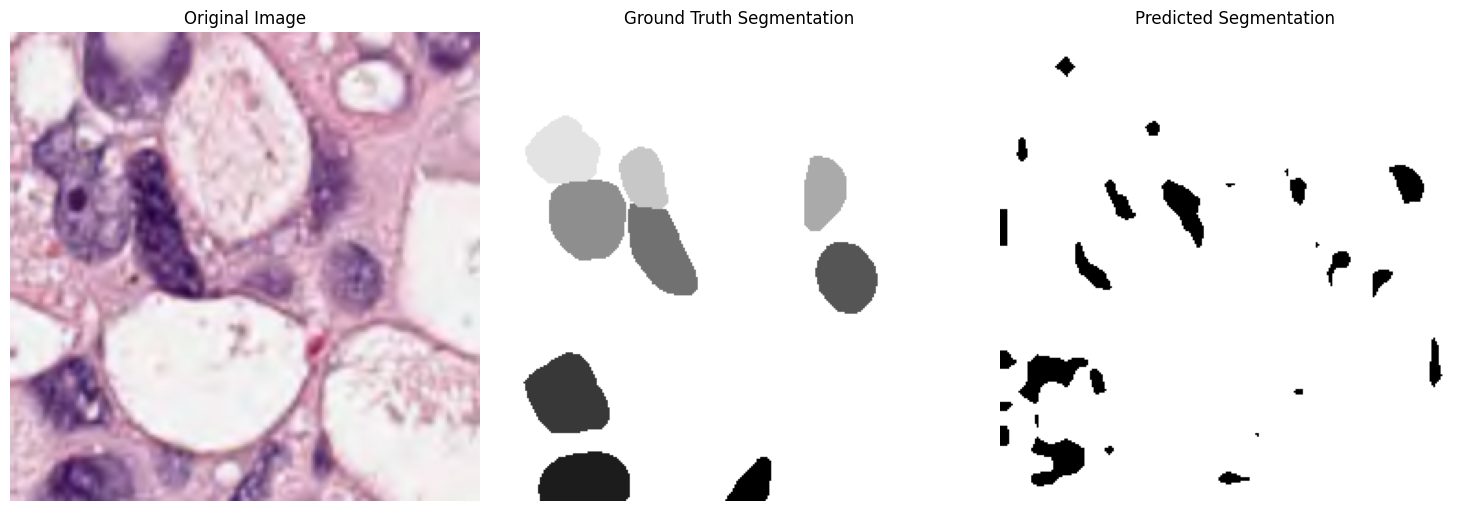


Segmentation Statistics:
Ground truth segmented pixels: 9286
Predicted segmented pixels: 2980
Difference: 6306 pixels


In [148]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation_comparison(model, test_loader, device='cuda'):
    """
    Visualize original image, ground truth, and predicted segmentation masks
    """
    # Get a random sample
    random_idx = np.random.randint(0, len(test_loader.dataset))
    print(f"Analyzing random sample {random_idx} out of {len(test_loader.dataset)} samples")

    # Get the random sample
    random_sample = test_loader.dataset[random_idx]
    batch = test_loader.collate_fn([random_sample])

    # Get predictions
    model.eval()
    with torch.no_grad():
        # Move image to device
        images = batch['image'].to(device)
        outputs = model(images)
        
        # Create figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 1. Original image
        img_display = images[0].cpu().numpy()
        img_display = np.moveaxis(img_display, 0, -1)  # Change channel order for display
        img_display = np.clip((img_display - img_display.min()) / 
                            (img_display.max() - img_display.min() + 1e-8), 0, 1)
        axes[0].imshow(img_display)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # 2. Ground Truth Binary Segmentation
        if 'masks' in batch['targets'] and 'cell' in batch['targets']['masks']:
            binary_gt = batch['targets']['masks']['cell'][0].squeeze().cpu().numpy()
            axes[1].imshow(binary_gt, cmap='binary')
            axes[1].set_title('Ground Truth Segmentation')
        else:
            axes[1].set_title('Ground Truth (Not Available)')
        axes[1].axis('off')
        
        # 3. Model Prediction
        binary_pred = torch.softmax(outputs['cell_mask'][0], dim=0)[1].cpu().numpy()
        axes[2].imshow(binary_pred > 0.5, cmap='binary')
        axes[2].set_title('Predicted Segmentation')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print some basic statistics
        if 'masks' in batch['targets'] and 'cell' in batch['targets']['masks']:
            gt_pixels = np.sum(binary_gt > 0)
            pred_pixels = np.sum(binary_pred > 0.5)
            print("\nSegmentation Statistics:")
            print(f"Ground truth segmented pixels: {gt_pixels}")
            print(f"Predicted segmented pixels: {pred_pixels}")
            print(f"Difference: {abs(gt_pixels - pred_pixels)} pixels")

# Use the function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_segmentation_comparison(he_model, loaders['he']['test'], device)

Analyzing random sample 1631 out of 2722 samples

Available keys in model outputs:
- cell_mask
- cell_types
- hv_maps
- gate_weights
Using __proc_np_hv from post-processing file vitamin-p_update


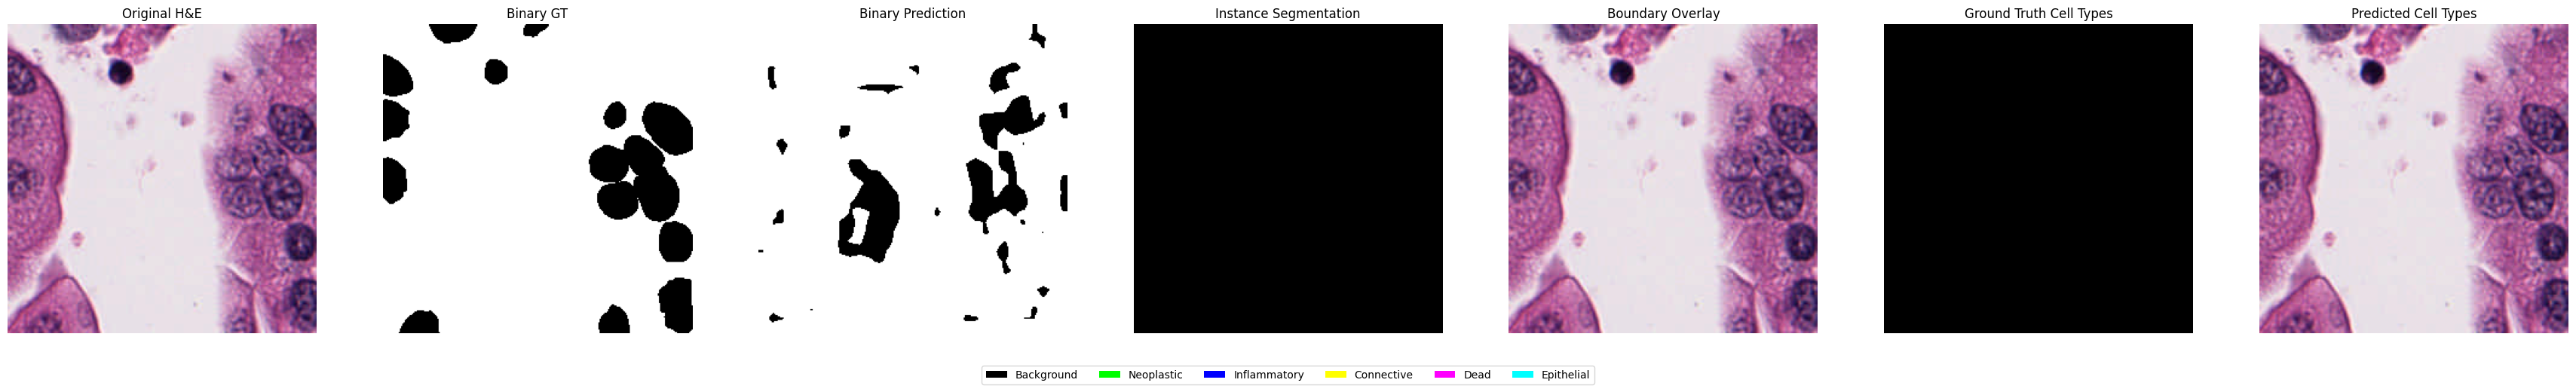


Prediction Statistics:
Number of detected cells: 0

Cell type distribution:


In [127]:
def visualize_predictions(he_model, test_loader, device='cuda'):
    """
    Visualize predictions using already loaded model and dataloader
    """
    # Get a random sample
    random_idx = np.random.randint(0, len(test_loader.dataset))
    print(f"Analyzing random sample {random_idx} out of {len(test_loader.dataset)} samples")

    # Get the random sample
    random_sample = test_loader.dataset[random_idx]
    batch = test_loader.collate_fn([random_sample])

    # Define class names and colors
    class_names = {
        0: "Background", 1: "Neoplastic", 2: "Inflammatory",
        3: "Connective", 4: "Dead", 5: "Epithelial"
    }
    type_colors = {
        0: 'black', 1: '#00FF00', 2: 'blue',
        3: 'yellow', 4: 'magenta', 5: 'cyan'
    }

    # Get predictions
    he_model.eval()
    with torch.no_grad():
        images = batch['image'].to(device)
        outputs = he_model(images)
        
        print("\nAvailable keys in model outputs:")
        for key in outputs.keys():
            print(f"- {key}")
            
        # Initialize post-processor
        cell_post_processor = DetectionCellPostProcessor(nr_types=6, magnification=40)
        
        # Process predictions - check if 'cell_hv' exists
        if 'cell_hv' in outputs:
            pred_map = np.concatenate([
                torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
            ], axis=-1)
        else:
            # Handle case without cell_hv
            pred_map = np.concatenate([
                torch.argmax(outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
                torch.argmax(outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
                np.zeros((outputs['cell_types'][0].shape[1], outputs['cell_types'][0].shape[2], 2))
            ], axis=-1)

        instance_map, type_pred = cell_post_processor.post_process_cell_segmentation(pred_map)
        
        # Create visualization
        fig, axes = plt.subplots(1, 7, figsize=(35, 5))
        
        # Original image
        img_display = images[0].cpu().numpy()
        img_display = np.moveaxis(img_display, 0, -1)
        img_display = np.clip((img_display - img_display.min()) / 
                            (img_display.max() - img_display.min() + 1e-8), 0, 1)
        axes[0].imshow(img_display)
        axes[0].set_title('Original H&E')
        axes[0].axis('off')
        
        # Binary Ground Truth
        if 'masks' in batch['targets'] and 'cell' in batch['targets']['masks']:
            binary_gt = batch['targets']['masks']['cell'][0].squeeze().cpu().numpy()
            axes[1].imshow(binary_gt > 0, cmap='binary')
            axes[1].set_title('Binary GT')
        else:
            axes[1].set_title('Binary GT (Not Available)')
        axes[1].axis('off')
        
        # Binary Prediction
        binary_pred = torch.softmax(outputs['cell_mask'][0], dim=0)[1].cpu().numpy()
        axes[2].imshow(binary_pred > 0.5, cmap='binary')
        axes[2].set_title('Binary Prediction')
        axes[2].axis('off')
        
        # Instance Segmentation
        axes[3].imshow(instance_map, cmap='nipy_spectral')
        axes[3].set_title('Instance Segmentation')
        axes[3].axis('off')
        
        # Boundary Overlay
        boundaries = find_boundaries(instance_map, mode='thick')
        overlay = img_display.copy()
        overlay[boundaries] = [1, 1, 1]  # White boundaries
        axes[4].imshow(overlay)
        axes[4].set_title('Boundary Overlay')
        axes[4].axis('off')
        
        # Ground Truth Cell Type Map
        if 'semantic' in batch['targets'] and 'cell_types' in batch['targets']['semantic']:
            cell_types = batch['targets']['semantic']['cell_types'][0].cpu().numpy()
            cell_mask = batch['targets']['masks']['cell'][0].squeeze().cpu().numpy()

            gt_type_map = np.zeros_like(cell_mask)
            active_type = np.argmax(cell_types)
            gt_type_map[cell_mask > 0] = active_type

            gt_type_rgb = np.zeros((*gt_type_map.shape, 3))
            for type_id in range(len(class_names)):
                color = np.array(mcolors.to_rgb(type_colors[type_id]))
                gt_type_rgb[gt_type_map == type_id] = color

            axes[5].imshow(gt_type_rgb)
            axes[5].set_title('Ground Truth Cell Types')
        else:
            axes[5].set_title('Ground Truth Cell Types (Not Available)')
        axes[5].axis('off')
        
        # Predicted Cell Type Overlay
        pred_type_overlay = img_display.copy()
        for cell_id, cell_info in type_pred.items():
            cell_mask = instance_map == cell_id
            cell_type = cell_info['type']
            pred_type_overlay[cell_mask] = np.array(mcolors.to_rgb(type_colors[cell_type]))
        pred_type_overlay[boundaries] = [1, 1, 1]
        axes[6].imshow(pred_type_overlay)
        axes[6].set_title('Predicted Cell Types')
        axes[6].axis('off')
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none', 
                         label=class_names[i]) for i, color in type_colors.items()]
        fig.legend(handles=legend_elements, loc='lower center', 
                  ncol=len(class_names), bbox_to_anchor=(0.5, 0))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()

        # Print statistics
        print("\nPrediction Statistics:")
        print(f"Number of detected cells: {len(type_pred)}")
        type_counts = {}
        for cell_id, cell_info in type_pred.items():
            cell_type = cell_info['type']
            type_counts[cell_type] = type_counts.get(cell_type, 0) + 1
        
        print("\nCell type distribution:")
        for type_id, count in type_counts.items():
            print(f"{class_names[type_id]}: {count} cells")

# Use with existing data:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_predictions(he_model, loaders['he']['test'], device)

## mIF EXPERT

Current file location: /rsrch5/home/plm/yshokrollahi/CellViT/cell_segmentation/utils/post_proc_vitaminp_mif.py
Loaded MIF expert checkpoint from: checkpoints_separate/mif/best_model.pt
Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!
Analyzing random sample 1184 out of 1324 samples
Using __proc_np_hv from post-processing file vitamin-p-mif_new
Using __proc_np_hv from post-processing file vitamin-p-mif_new


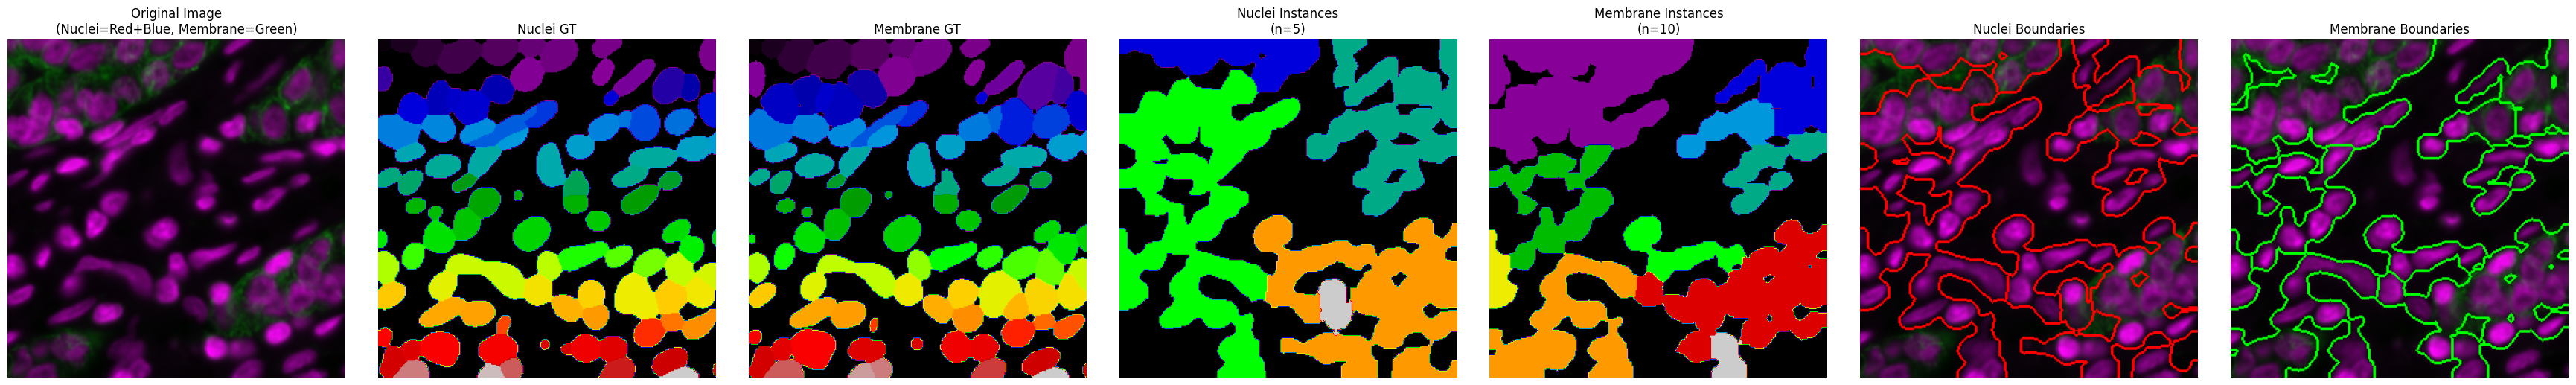


Prediction Statistics:
Number of detected nuclei: 5
Number of detected membranes: 10
Visualization complete!


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.segmentation import find_boundaries
from cell_segmentation.utils.post_proc_vitaminp_mif import DetectionCellPostProcessor
import os

def load_mif_expert_and_visualize(base_dir: str, device: str = 'cuda'):
    """
    Load MIF expert model and visualize its predictions on TissueNet
    """
    # Initialize MIF expert model
    mif_model = MIFExpert(pretrained=True).to(device)
    
    # Load the MIF expert checkpoint
    checkpoint_path = os.path.join(base_dir, 'mif', 'best_model.pt')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        mif_model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded MIF expert checkpoint from: {checkpoint_path}")
    else:
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    # Create dataset manager and setup datasets
    manager = ModularDatasetManager()
    datasets = manager.setup_datasets()
    test_loader = manager.get_dataloader('tissuenet', 'test', batch_size=1)

    # Get a random sample
    random_idx = np.random.randint(0, len(test_loader.dataset))
    print(f"Analyzing random sample {random_idx} out of {len(test_loader.dataset)} samples")

    def visualize_tissuenet(random_idx, test_loader, model, device):
        sample = test_loader.dataset[random_idx % len(test_loader.dataset)]
        batch = test_loader.collate_fn([sample])
        
        model.eval()
        with torch.no_grad():
            images = batch['image'].to(device)
            outputs = model(images)
            
            nuclei_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
            membrane_processor = DetectionCellPostProcessor(nr_types=1, magnification=40, gt=False)
            
            # Process nuclei using correct keys
            nuclei_seg = torch.sigmoid(outputs['nuclei_mask'][0, 1]).cpu().numpy() > 0.1
            nuclei_hv = outputs['nuclei_hv'][0].cpu().numpy()
            nuclei_map = np.concatenate([
                np.zeros((256, 256, 1)),
                nuclei_seg[..., None],
                nuclei_hv.transpose(1, 2, 0)
            ], axis=-1)
            
            # Process membrane using correct keys
            membrane_seg = torch.sigmoid(outputs['membrane_mask'][0, 1]).cpu().numpy() > 0.3
            membrane_hv = outputs['membrane_hv'][0].cpu().numpy()
            membrane_map = np.concatenate([
                np.zeros((256, 256, 1)),
                membrane_seg[..., None],
                membrane_hv.transpose(1, 2, 0)
            ], axis=-1)
            
            nuclei_instance_map, nuclei_info = nuclei_processor.post_process_cell_segmentation(nuclei_map)
            membrane_instance_map, membrane_info = membrane_processor.post_process_cell_segmentation(membrane_map)
            
            # Visualization
            fig, axes = plt.subplots(1, 7, figsize=(35, 5))
            
            # Original image
            img_display = images[0].cpu().numpy()
            img_display = np.moveaxis(img_display, 0, -1)
            
            # Create RGB display
            rgb_display = np.stack([
                img_display[..., 0],  # Nuclei channel
                img_display[..., 1],  # Membrane channel
                img_display[..., 0]   # Nuclei channel again for blue
            ], axis=-1)
            
            # Normalize for display
            rgb_display = np.clip((rgb_display - rgb_display.min()) / 
                                (rgb_display.max() - rgb_display.min() + 1e-8), 0, 1)
            
            axes[0].imshow(rgb_display)
            axes[0].set_title('Original Image\n(Nuclei=Red+Blue, Membrane=Green)')
            axes[0].axis('off')
            
            # Nuclei GT
            if 'nuclei' in batch['targets']['masks']:
                gt_nuclei = batch['targets']['masks']['nuclei'][0].squeeze().cpu().numpy()
                axes[1].imshow(gt_nuclei, cmap='nipy_spectral')
                axes[1].set_title('Nuclei GT')
            axes[1].axis('off')
            
            # Membrane GT
            if 'membrane' in batch['targets']['masks']:
                gt_membrane = batch['targets']['masks']['membrane'][0].squeeze().cpu().numpy()
                axes[2].imshow(gt_membrane, cmap='nipy_spectral')
                axes[2].set_title('Membrane GT')
            axes[2].axis('off')
            
            # Instance maps
            axes[3].imshow(nuclei_instance_map, cmap='nipy_spectral')
            axes[3].set_title(f'Nuclei Instances\n(n={len(nuclei_info)})')
            axes[3].axis('off')
            
            axes[4].imshow(membrane_instance_map, cmap='nipy_spectral')
            axes[4].set_title(f'Membrane Instances\n(n={len(membrane_info)})')
            axes[4].axis('off')
            
            # Overlays
            nuclei_boundaries = find_boundaries(nuclei_instance_map, mode='thick')
            nuclei_overlay = rgb_display.copy()
            nuclei_overlay[nuclei_boundaries] = [1, 0, 0]  # Red boundaries
            axes[5].imshow(nuclei_overlay)
            axes[5].set_title('Nuclei Boundaries')
            axes[5].axis('off')
            
            membrane_boundaries = find_boundaries(membrane_instance_map, mode='thick')
            membrane_overlay = rgb_display.copy()
            membrane_overlay[membrane_boundaries] = [0, 1, 0]  # Green boundaries
            axes[6].imshow(membrane_overlay)
            axes[6].set_title('Membrane Boundaries')
            axes[6].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print("\nPrediction Statistics:")
            print(f"Number of detected nuclei: {len(nuclei_info)}")
            print(f"Number of detected membranes: {len(membrane_info)}")
            
            return nuclei_instance_map, membrane_instance_map, mif_model, test_loader

    return visualize_tissuenet(random_idx, test_loader, mif_model, device)

# Run the visualization
if __name__ == "__main__":
    base_dir = 'checkpoints_separate'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        nuclei_map, membrane_map, model, loader = load_mif_expert_and_visualize(base_dir, device)
        print("Visualization complete!")
    except Exception as e:
        print(f"Error occurred: {str(e)}")

## gating netwroks

In [33]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from pathlib import Path

def test_gating_performance(model, dataset_manager, device='cuda'):
    model.eval()
    results = {
        'mif_correct': 0,
        'mif_total': 0,
        'he_correct': 0,
        'he_total': 0,
        'mif_confidences': [],
        'he_confidences': [],
        'wrong_predictions': []
    }
    
    # Get test loaders for both datasets
    tissuenet_loader = dataset_manager.get_dataloader('tissuenet', 'test', batch_size=32)
    pannuke_loader = dataset_manager.get_dataloader('pannuke', 'test', batch_size=32)
    
    print("Testing gating network performance...")
    with torch.no_grad():
        # Test on both datasets
        for loader_name, loader in [('TissueNet', tissuenet_loader), ('PanNuke', pannuke_loader)]:
            print(f"\nTesting on {loader_name}...")
            for batch in tqdm(loader):
                images = batch['image'].to(device)
                # Determine true modality from original channels in metadata
                true_modality = torch.tensor([ch == 3 for ch in batch['metadata']['original_channels']], 
                                          device=device).long()  # 0 for MIF, 1 for HE
                
                # Get gating predictions
                outputs = model(images, modality='gating')
                gate_logits = outputs['gate_weights']
                gate_probs = F.softmax(gate_logits, dim=1)
                predictions = gate_probs.argmax(dim=1)
                confidences = gate_probs.max(dim=1)[0]
                
                # Update statistics
                for idx, (pred, true, conf) in enumerate(zip(predictions, true_modality, confidences)):
                    if true == 0:  # MIF
                        results['mif_total'] += 1
                        if pred == true:
                            results['mif_correct'] += 1
                            results['mif_confidences'].append(float(conf))
                        else:
                            results['wrong_predictions'].append({
                                'true': 'MIF',
                                'pred': 'HE',
                                'confidence': float(conf),
                                'dataset': loader_name,
                                'image_idx': idx
                            })
                    else:  # HE
                        results['he_total'] += 1
                        if pred == true:
                            results['he_correct'] += 1
                            results['he_confidences'].append(float(conf))
                        else:
                            results['wrong_predictions'].append({
                                'true': 'HE',
                                'pred': 'MIF',
                                'confidence': float(conf),
                                'dataset': loader_name,
                                'image_idx': idx
                            })

    # Calculate metrics
    mif_accuracy = results['mif_correct'] / max(1, results['mif_total'])
    he_accuracy = results['he_correct'] / max(1, results['he_total'])
    overall_accuracy = (results['mif_correct'] + results['he_correct']) / \
                      (results['mif_total'] + results['he_total'])
    
    # Print results
    print("\nGating Network Performance:")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"\nPer-Modality Performance:")
    print(f"MIF Accuracy: {mif_accuracy:.4f} ({results['mif_correct']}/{results['mif_total']})")
    print(f"MIF Avg Confidence: {np.mean(results['mif_confidences']):.4f}")
    print(f"\nHE Accuracy: {he_accuracy:.4f} ({results['he_correct']}/{results['he_total']})")
    print(f"HE Avg Confidence: {np.mean(results['he_confidences']):.4f}")
    
    if results['wrong_predictions']:
        print("\nMisclassified Examples:")
        for wrong in results['wrong_predictions'][:5]:  # Show first 5 mistakes
            print(f"Dataset: {wrong['dataset']}, True: {wrong['true']}, "
                  f"Predicted: {wrong['pred']}, Confidence: {wrong['confidence']:.4f}")
    
    return results

def run_gating_test():
    # Initialize dataset manager
    dataset_manager = ModularDatasetManager()
    dataset_manager.setup_datasets()
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    checkpoint_path = "checkpoints_separate/gating/best_model.pt"
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model = MultiModalExpertModel().to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Successfully loaded model from {checkpoint_path}")
        
        # Test gating performance
        results = test_gating_performance(model, dataset_manager, device)
        return model, results
        
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None, None

# Run the test
if __name__ == "__main__":
    model, results = run_gating_test()

Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!
Successfully loaded model from checkpoints_separate/gating/best_model.pt
Testing gating network performance...

Testing on TissueNet...


100%|██████████| 42/42 [00:13<00:00,  3.20it/s]



Testing on PanNuke...


100%|██████████| 86/86 [00:11<00:00,  7.42it/s]


Gating Network Performance:
Overall Accuracy: 1.0000

Per-Modality Performance:
MIF Accuracy: 1.0000 (1324/1324)
MIF Avg Confidence: 0.8998

HE Accuracy: 1.0000 (2722/2722)
HE Avg Confidence: 0.9979


Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!
Successfully loaded model from checkpoints_separate/gating/best_model.pt
Original image shape: torch.Size([3, 256, 256])
Image shape after adding batch dimension: torch.Size([1, 3, 256, 256])
Sample metadata: {'modality_type': 'pannuke', 'available_targets': ['cell', 'cell_types', 'hv_maps'], 'original_size': torch.Size([256, 256]), 'fold': None, 'tissue_type': 'Adrenal_gland', 'tissue_type_id': -1, 'img_name': '2_1217.png', 'cell_type_mapping': {0: 'Background', 1: 'Neoplastic', 2: 'Inflammatory', 3: 'Connective', 4: 'Dead', 5: 'Epithelial'}, 'tissue_type_mapping': {'Breast': 0, 'Colon': 1, 'Liver': 2, 'Kidney': 3, 'Prostate': 4, 'Bladder': 5, 'Ovarian': 6, 'Uterus': 7, 'Thyroid': 8, 'Testis': 9, 'Lung': 10, 'Esophagus': 11, 'Skin': 12, 'Head&Neck': 13, 'Bile-duct': 14, 'Stomach': 15, 'Pancreatic': 16, 'Adrenal': 17}}
Gate probabilities: [0.00509218 0.9949078 ]
Image shape after squeeze: (3, 256, 

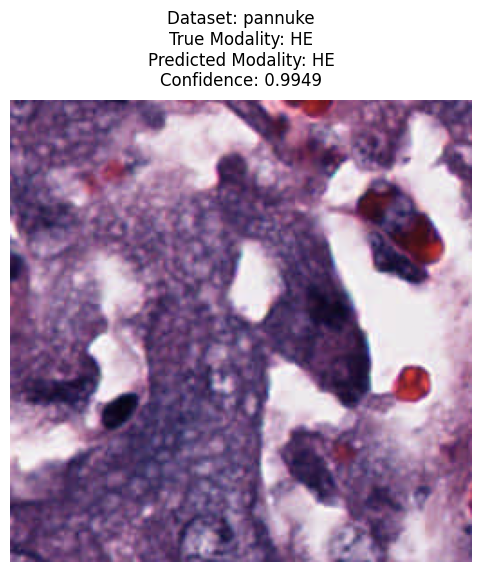

In [68]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_random_gating_sample(model, dataset_manager, device='cuda'):
    model.eval()
    
    # Randomly choose between TissueNet and PanNuke
    dataset_name = random.choice(['tissuenet', 'pannuke'])
    loader = dataset_manager.get_dataloader(dataset_name, 'test', batch_size=1)
    
    # Get a random sample
    random_idx = random.randint(0, len(loader.dataset) - 1)
    sample = loader.dataset[random_idx]
    
    # Debug prints for image shape
    print("Original image shape:", sample['image'].shape)
    
    # Prepare input
    image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
    print("Image shape after adding batch dimension:", image.shape)
    
    # Get metadata
    metadata = sample['metadata']
    print("Sample metadata:", metadata)
    
    # Determine true modality from metadata type
    true_modality = 'MIF' if metadata['modality_type'] == 'tissuenet' else 'HE'
    
    # Get gating prediction
    with torch.no_grad():
        outputs = model(image, modality='gating')
        gate_logits = outputs['gate_weights']
        gate_probs = F.softmax(gate_logits, dim=1)
        prediction = gate_probs.argmax(dim=1)
        confidence = float(gate_probs.max(dim=1)[0])
        
        print(f"Gate probabilities: {gate_probs.squeeze().cpu().numpy()}")
    
    # Convert prediction to modality name
    pred_modality = 'MIF' if prediction.item() == 0 else 'HE'
    
    # Visualize the image
    plt.figure(figsize=(10, 6))
    
    # Convert image to numpy and handle dimensions
    img = image.squeeze().cpu().numpy()
    print("Image shape after squeeze:", img.shape)
    
    # If image is in CHW format, transpose to HWC
    if len(img.shape) == 3 and img.shape[0] in [1, 2, 3, 4]:
        img = np.transpose(img, (1, 2, 0))
    print("Final image shape:", img.shape)
    
    # If image has only 1 or 2 channels, repeat to make it displayable
    if len(img.shape) == 3 and img.shape[2] < 3:
        img = np.repeat(img[..., :1], 3, axis=2)
    
    # Normalize image for visualization
    img = (img - img.min()) / (img.max() - img.min())
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Dataset: {dataset_name}\n'
              f'True Modality: {true_modality}\n'
              f'Predicted Modality: {pred_modality}\n'
              f'Confidence: {confidence:.4f}', 
              pad=10)
    
    plt.show()
    
    return {
        'dataset': dataset_name,
        'true_modality': true_modality,
        'predicted_modality': pred_modality,
        'confidence': confidence,
        'image': img
    }

def run_gating_visualization():
    # Initialize dataset manager
    dataset_manager = ModularDatasetManager()
    dataset_manager.setup_datasets()
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    checkpoint_path = "checkpoints_separate/gating/best_model.pt"
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model = MultiModalExpertModel().to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Successfully loaded model from {checkpoint_path}")
        
        # Visualize random sample
        result = visualize_random_gating_sample(model, dataset_manager, device)
        return model, result
        
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        print(f"Full error details:", e)
        return None, None

# Run the visualization
if __name__ == "__main__":
    model, result = run_gating_visualization()

Loading model and datasets...
Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!
Successfully loaded model from checkpoints_separate/gating/best_model.pt
Original image shape: torch.Size([3, 256, 256])
Image shape after adding batch dimension: torch.Size([1, 3, 256, 256])
Sample metadata: {'modality_type': 'pannuke', 'available_targets': ['cell', 'cell_types', 'hv_maps'], 'original_size': torch.Size([256, 256]), 'fold': None, 'tissue_type': 'HeadNeck', 'tissue_type_id': -1, 'img_name': '2_2036.png', 'cell_type_mapping': {0: 'Background', 1: 'Neoplastic', 2: 'Inflammatory', 3: 'Connective', 4: 'Dead', 5: 'Epithelial'}, 'tissue_type_mapping': {'Breast': 0, 'Colon': 1, 'Liver': 2, 'Kidney': 3, 'Prostate': 4, 'Bladder': 5, 'Ovarian': 6, 'Uterus': 7, 'Thyroid': 8, 'Testis': 9, 'Lung': 10, 'Esophagus': 11, 'Skin': 12, 'Head&Neck': 13, 'Bile-duct': 14, 'Stomach': 15, 'Pancreatic': 16, 'Adrenal': 17}}
Gate probabilities: [2.3758626e-06 9.9999762e-01]
Image

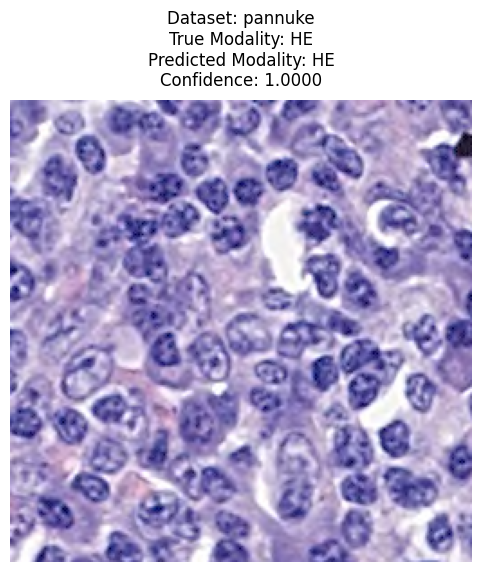

Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!

Running modality contribution analysis...


Analyzing pannuke:   2%|▏         | 50/2722 [00:00<00:36, 73.86it/s] 


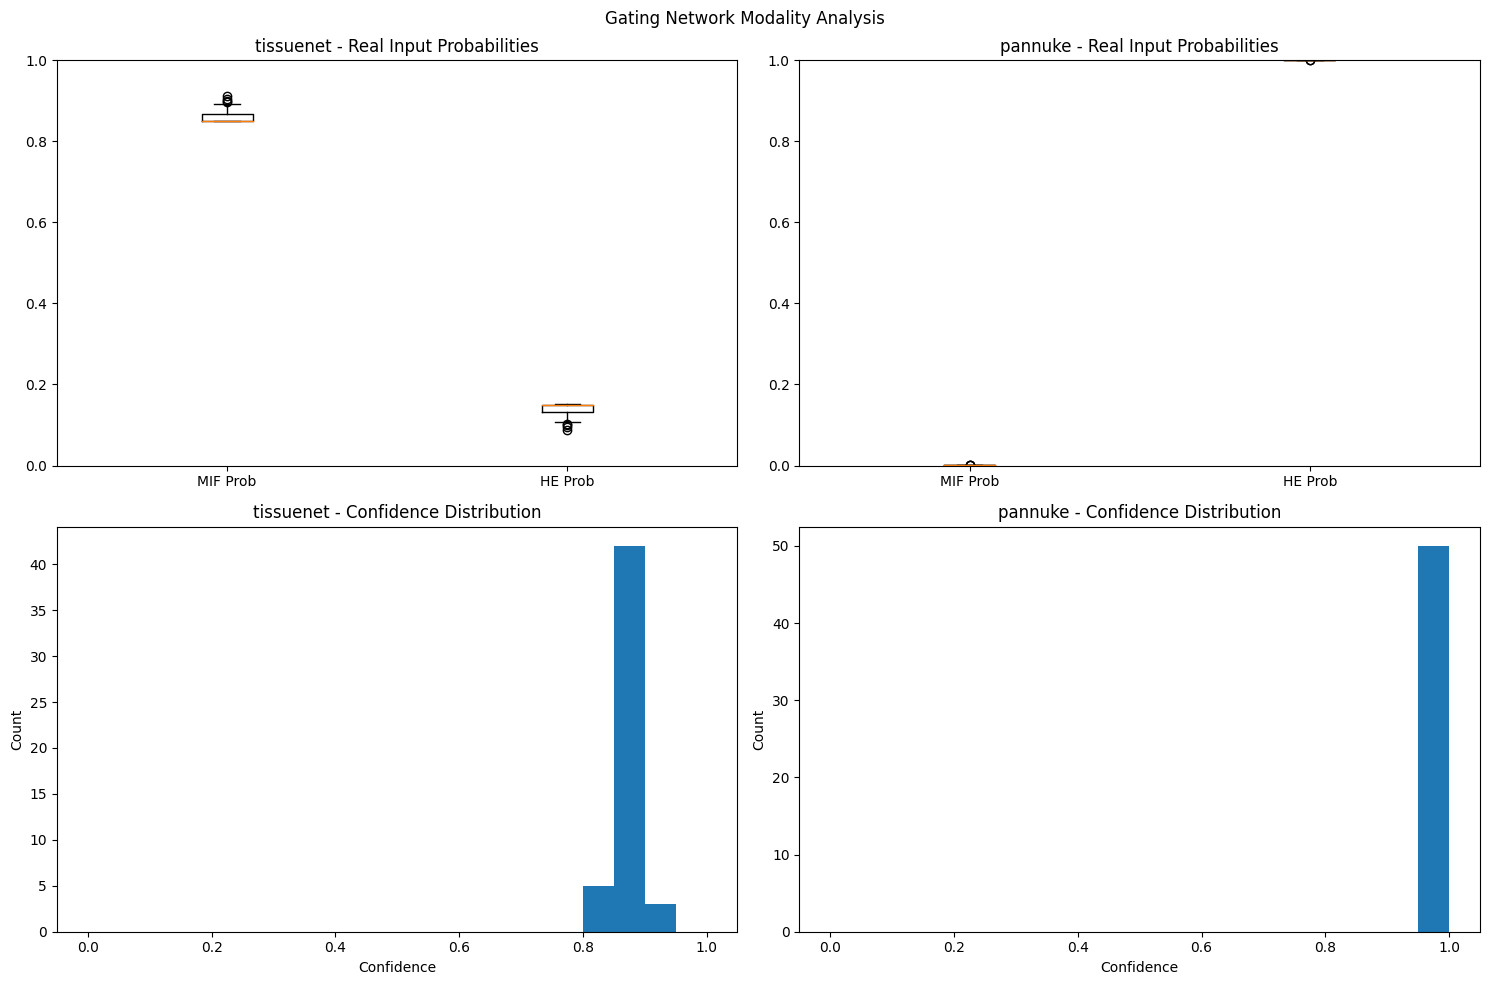


Analysis Summary:

TISSUENET Results:
Average Confidence: 0.861 ± 0.017
Average Probability Difference (Real vs Dummy): 0.854
Decision Switch Rate: 100.0%

PANNUKE Results:
Average Confidence: 1.000 ± 0.000
Average Probability Difference (Real vs Dummy): 0.000
Decision Switch Rate: 0.0%


In [69]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_modality_contribution(model, dataset_manager, device='cuda', n_samples=50):
    """
    Analyzes how each modality contributes to the gating decision by testing
    with real and dummy inputs.
    """
    model.eval()
    results = {
        'tissuenet': {'real': [], 'dummy': [], 'confidence': []},
        'pannuke': {'real': [], 'dummy': [], 'confidence': []}
    }
    
    def get_features(x):
        """Extract features from both paths"""
        if x.shape[1] == 2:  # MIF
            mif_feat = model.gating_network.mif_path(x)
            dummy_he = torch.cat([x, x[:,:1]], dim=1)
            he_feat = model.gating_network.he_path(dummy_he)
        else:  # HE
            he_feat = model.gating_network.he_path(x)
            mif_feat = model.gating_network.mif_path(x[:,:2])
        return mif_feat, he_feat
    
    for dataset_name in ['tissuenet', 'pannuke']:
        loader = dataset_manager.get_dataloader(dataset_name, 'test', batch_size=1)
        
        for i, sample in enumerate(tqdm(loader, desc=f'Analyzing {dataset_name}')):
            if i >= n_samples:
                break
                
            image = sample['image'].to(device)
            
            with torch.no_grad():
                # Get original prediction
                outputs = model(image, modality='gating')
                gate_logits = outputs['gate_weights']
                gate_probs = F.softmax(gate_logits, dim=1)
                confidence = float(gate_probs.max())
                
                # Get features from both paths
                mif_feat, he_feat = get_features(image)
                
                # Create dummy input by zeroing out each path
                if image.shape[1] == 2:  # MIF input
                    dummy_img = torch.cat([torch.zeros_like(image), image[:,:1]], dim=1)
                else:  # HE input
                    dummy_img = torch.zeros_like(image)
                
                # Get prediction with dummy input
                dummy_outputs = model(dummy_img, modality='gating')
                dummy_logits = dummy_outputs['gate_weights']
                dummy_probs = F.softmax(dummy_logits, dim=1)
                
                # Store results
                results[dataset_name]['real'].append(gate_probs.cpu().numpy())
                results[dataset_name]['dummy'].append(dummy_probs.cpu().numpy())
                results[dataset_name]['confidence'].append(confidence)
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Gating Network Modality Analysis')
    
    for idx, dataset_name in enumerate(['tissuenet', 'pannuke']):
        # Convert lists to arrays for easier analysis
        real_preds = np.array(results[dataset_name]['real']).squeeze()
        dummy_preds = np.array(results[dataset_name]['dummy']).squeeze()
        conf = np.array(results[dataset_name]['confidence'])
        
        # Plot probability distributions
        axes[0,idx].boxplot([real_preds[:,0], real_preds[:,1]], 
                          labels=['MIF Prob', 'HE Prob'])
        axes[0,idx].set_title(f'{dataset_name} - Real Input Probabilities')
        axes[0,idx].set_ylim(0, 1)
        
        # Plot confidence histogram
        axes[1,idx].hist(conf, bins=20, range=(0,1))
        axes[1,idx].set_title(f'{dataset_name} - Confidence Distribution')
        axes[1,idx].set_xlabel('Confidence')
        axes[1,idx].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics
    summary = {}
    for dataset_name in results:
        real_preds = np.array(results[dataset_name]['real']).squeeze()
        dummy_preds = np.array(results[dataset_name]['dummy']).squeeze()
        conf = np.array(results[dataset_name]['confidence'])
        
        summary[dataset_name] = {
            'avg_confidence': float(np.mean(conf)),
            'std_confidence': float(np.std(conf)),
            'avg_prob_diff': float(np.mean(np.abs(real_preds - dummy_preds))),
            'decision_switch_rate': float(np.mean(
                np.argmax(real_preds, axis=1) != np.argmax(dummy_preds, axis=1)
            ))
        }
    
    return summary, results

# Function to run the analysis
def run_full_analysis():
    print("Loading model and datasets...")
    model, _ = run_gating_visualization()
    
    if model is None:
        print("Failed to load model")
        return
    
    dataset_manager = ModularDatasetManager()
    dataset_manager.setup_datasets()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("\nRunning modality contribution analysis...")
    summary, results = analyze_modality_contribution(model, dataset_manager, device)
    
    print("\nAnalysis Summary:")
    for dataset_name, stats in summary.items():
        print(f"\n{dataset_name.upper()} Results:")
        print(f"Average Confidence: {stats['avg_confidence']:.3f} ± {stats['std_confidence']:.3f}")
        print(f"Average Probability Difference (Real vs Dummy): {stats['avg_prob_diff']:.3f}")
        print(f"Decision Switch Rate: {stats['decision_switch_rate']*100:.1f}%")
    
    return summary, results

if __name__ == "__main__":
    summary, results = run_full_analysis()

Loading model and datasets...
Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!
Successfully loaded model from checkpoints_separate/gating/best_model.pt
Original image shape: torch.Size([3, 256, 256])
Image shape after adding batch dimension: torch.Size([1, 3, 256, 256])
Sample metadata: {'modality_type': 'pannuke', 'available_targets': ['cell', 'cell_types', 'hv_maps'], 'original_size': torch.Size([256, 256]), 'fold': None, 'tissue_type': 'Bile-duct', 'tissue_type_id': 14, 'img_name': '2_1493.png', 'cell_type_mapping': {0: 'Background', 1: 'Neoplastic', 2: 'Inflammatory', 3: 'Connective', 4: 'Dead', 5: 'Epithelial'}, 'tissue_type_mapping': {'Breast': 0, 'Colon': 1, 'Liver': 2, 'Kidney': 3, 'Prostate': 4, 'Bladder': 5, 'Ovarian': 6, 'Uterus': 7, 'Thyroid': 8, 'Testis': 9, 'Lung': 10, 'Esophagus': 11, 'Skin': 12, 'Head&Neck': 13, 'Bile-duct': 14, 'Stomach': 15, 'Pancreatic': 16, 'Adrenal': 17}}
Gate probabilities: [1.3901759e-05 9.9998605e-01]
Imag

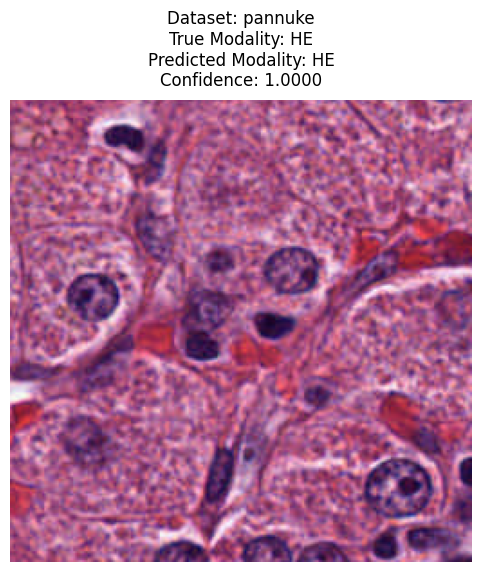

Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!

Analyzing expert contributions...


Analyzing tissuenet:   1%|          | 13/1324 [00:00<00:34, 38.29it/s]


tissuenet Sample 0:
Image shape: torch.Size([1, 2, 256, 256])
Gate probabilities: [0.8514084 0.1485916]

tissuenet Sample 1:
Image shape: torch.Size([1, 2, 256, 256])
Gate probabilities: [0.85164416 0.14835586]

tissuenet Sample 2:
Image shape: torch.Size([1, 2, 256, 256])
Gate probabilities: [0.8514952  0.14850484]

tissuenet Sample 3:
Image shape: torch.Size([1, 2, 256, 256])
Gate probabilities: [0.8517044 0.1482956]

tissuenet Sample 4:
Image shape: torch.Size([1, 2, 256, 256])
Gate probabilities: [0.85049534 0.14950468]

tissuenet Sample 5:
Image shape: torch.Size([1, 2, 256, 256])
Gate probabilities: [0.8508611  0.14913887]

tissuenet Sample 6:
Image shape: torch.Size([1, 2, 256, 256])
Gate probabilities: [0.873093   0.12690696]

tissuenet Sample 7:
Image shape: torch.Size([1, 2, 256, 256])
Gate probabilities: [0.8506702  0.14932981]

tissuenet Sample 8:
Image shape: torch.Size([1, 2, 256, 256])
Gate probabilities: [0.85002434 0.14997567]

tissuenet Sample 9:
Image shape: torch.S

Analyzing pannuke:   1%|          | 20/2722 [00:00<00:47, 57.31it/s]


pannuke Sample 0:
Image shape: torch.Size([1, 3, 256, 256])
Gate probabilities: [3.0325975e-06 9.9999702e-01]

pannuke Sample 1:
Image shape: torch.Size([1, 3, 256, 256])
Gate probabilities: [2.6652608e-06 9.9999738e-01]

pannuke Sample 2:
Image shape: torch.Size([1, 3, 256, 256])
Gate probabilities: [2.937935e-06 9.999970e-01]

pannuke Sample 3:
Image shape: torch.Size([1, 3, 256, 256])
Gate probabilities: [2.5329566e-06 9.9999750e-01]

pannuke Sample 4:
Image shape: torch.Size([1, 3, 256, 256])
Gate probabilities: [3.3741287e-06 9.9999666e-01]

pannuke Sample 5:
Image shape: torch.Size([1, 3, 256, 256])
Gate probabilities: [2.9880453e-06 9.9999702e-01]

pannuke Sample 6:
Image shape: torch.Size([1, 3, 256, 256])
Gate probabilities: [2.6047794e-06 9.9999738e-01]

pannuke Sample 7:
Image shape: torch.Size([1, 3, 256, 256])
Gate probabilities: [2.7345975e-06 9.9999726e-01]

pannuke Sample 8:
Image shape: torch.Size([1, 3, 256, 256])
Gate probabilities: [3.2679957e-06 9.9999678e-01]

pa

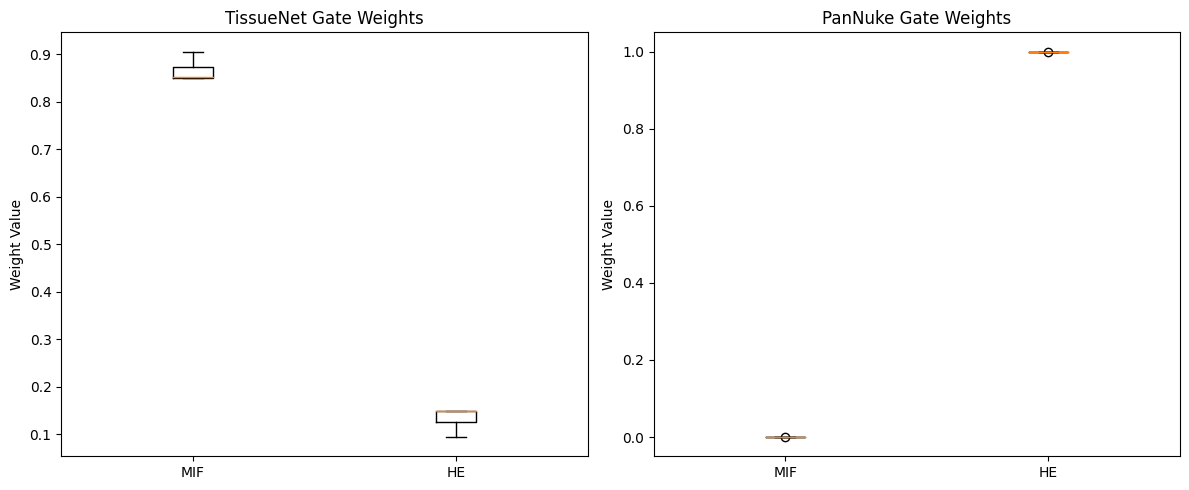

In [70]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_expert_contribution(model, dataset_manager, device='cuda', n_samples=20):
    """
    Analyzes how much each expert contributes to the final predictions
    by comparing outputs and gating weights.
    """
    model.eval()
    results = {
        'tissuenet': {'gate_weights': [], 'expert_outputs': [], 'metadata': []},
        'pannuke': {'gate_weights': [], 'expert_outputs': [], 'metadata': []}
    }

    for dataset_name in ['tissuenet', 'pannuke']:
        loader = dataset_manager.get_dataloader(dataset_name, 'test', batch_size=1)
        
        for i, sample in enumerate(tqdm(loader, desc=f'Analyzing {dataset_name}')):
            if i >= n_samples:
                break
                
            image = sample['image'].to(device)
            metadata = sample['metadata']
            
            with torch.no_grad():
                # Get predictions with gating
                outputs = model(image, modality='gating')
                gate_logits = outputs['gate_weights']
                gate_probs = F.softmax(gate_logits, dim=1).squeeze()
                
                # Print gate probabilities for debugging
                print(f"\n{dataset_name} Sample {i}:")
                print("Image shape:", image.shape)
                print("Gate probabilities:", gate_probs.cpu().numpy())
                
                # Store results
                results[dataset_name]['gate_weights'].append(gate_probs.cpu().numpy())
                results[dataset_name]['metadata'].append(metadata)

    # Print analysis
    print("\nGate Weight Analysis:")
    for dataset_name in results:
        print(f"\n{dataset_name.upper()}:")
        weights = np.array(results[dataset_name]['gate_weights'])
        
        # Calculate statistics for MIF weights (index 0)
        mif_mean = np.mean(weights[:, 0])
        mif_std = np.std(weights[:, 0])
        mif_min = np.min(weights[:, 0])
        mif_max = np.max(weights[:, 0])
        
        # Calculate statistics for HE weights (index 1)
        he_mean = np.mean(weights[:, 1])
        he_std = np.std(weights[:, 1])
        he_min = np.min(weights[:, 1])
        he_max = np.max(weights[:, 1])
        
        print(f"MIF Expert (mean ± std): {mif_mean:.3f} ± {mif_std:.3f} [min: {mif_min:.3f}, max: {mif_max:.3f}]")
        print(f"HE Expert  (mean ± std): {he_mean:.3f} ± {he_std:.3f} [min: {he_min:.3f}, max: {he_max:.3f}]")
        
        # Count strong predictions (>0.9 confidence)
        strong_mif = np.sum(weights[:, 0] > 0.9)
        strong_he = np.sum(weights[:, 1] > 0.9)
        total = len(weights)
        
        print(f"\nStrong predictions (>90% confidence):")
        print(f"MIF Expert: {strong_mif}/{total} ({strong_mif/total*100:.1f}%)")
        print(f"HE Expert:  {strong_he}/{total} ({strong_he/total*100:.1f}%)")

    # Visualize results
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Gate Weight Distributions
    plt.subplot(1, 2, 1)
    
    # Prepare data for box plot
    data_mif = [weights[:, 0] for dataset_name, results_dict in results.items()
                for weights in [np.array(results_dict['gate_weights'])]]
    data_he = [weights[:, 1] for dataset_name, results_dict in results.items()
               for weights in [np.array(results_dict['gate_weights'])]]
    
    plt.boxplot([data_mif[0], data_he[0]], positions=[1, 2], labels=['MIF', 'HE'])
    plt.title('TissueNet Gate Weights')
    plt.ylabel('Weight Value')
    
    # Plot 2: Gate Weight Distributions for PanNuke
    plt.subplot(1, 2, 2)
    plt.boxplot([data_mif[1], data_he[1]], positions=[1, 2], labels=['MIF', 'HE'])
    plt.title('PanNuke Gate Weights')
    plt.ylabel('Weight Value')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run the analysis
if __name__ == "__main__":
    print("Loading model and datasets...")
    model, _ = run_gating_visualization()
    
    if model is None:
        print("Failed to load model")
    else:
        dataset_manager = ModularDatasetManager()
        dataset_manager.setup_datasets()
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("\nAnalyzing expert contributions...")
        results = analyze_expert_contribution(model, dataset_manager, device)

## GAting vs  H&E ONLY

Loaded HE expert checkpoint from: checkpoints_separate/he/best_model.pt
Loaded gated model checkpoint from: checkpoints_separate/gating/best_model.pt
Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!
Analyzing random sample 2558 out of 2722 samples

Gating Probabilities:
MIF Expert: 0.269
HE Expert:  0.731
Using __proc_np_hv from post-processing file vitamin-p_update
Using __proc_np_hv from post-processing file vitamin-p_update


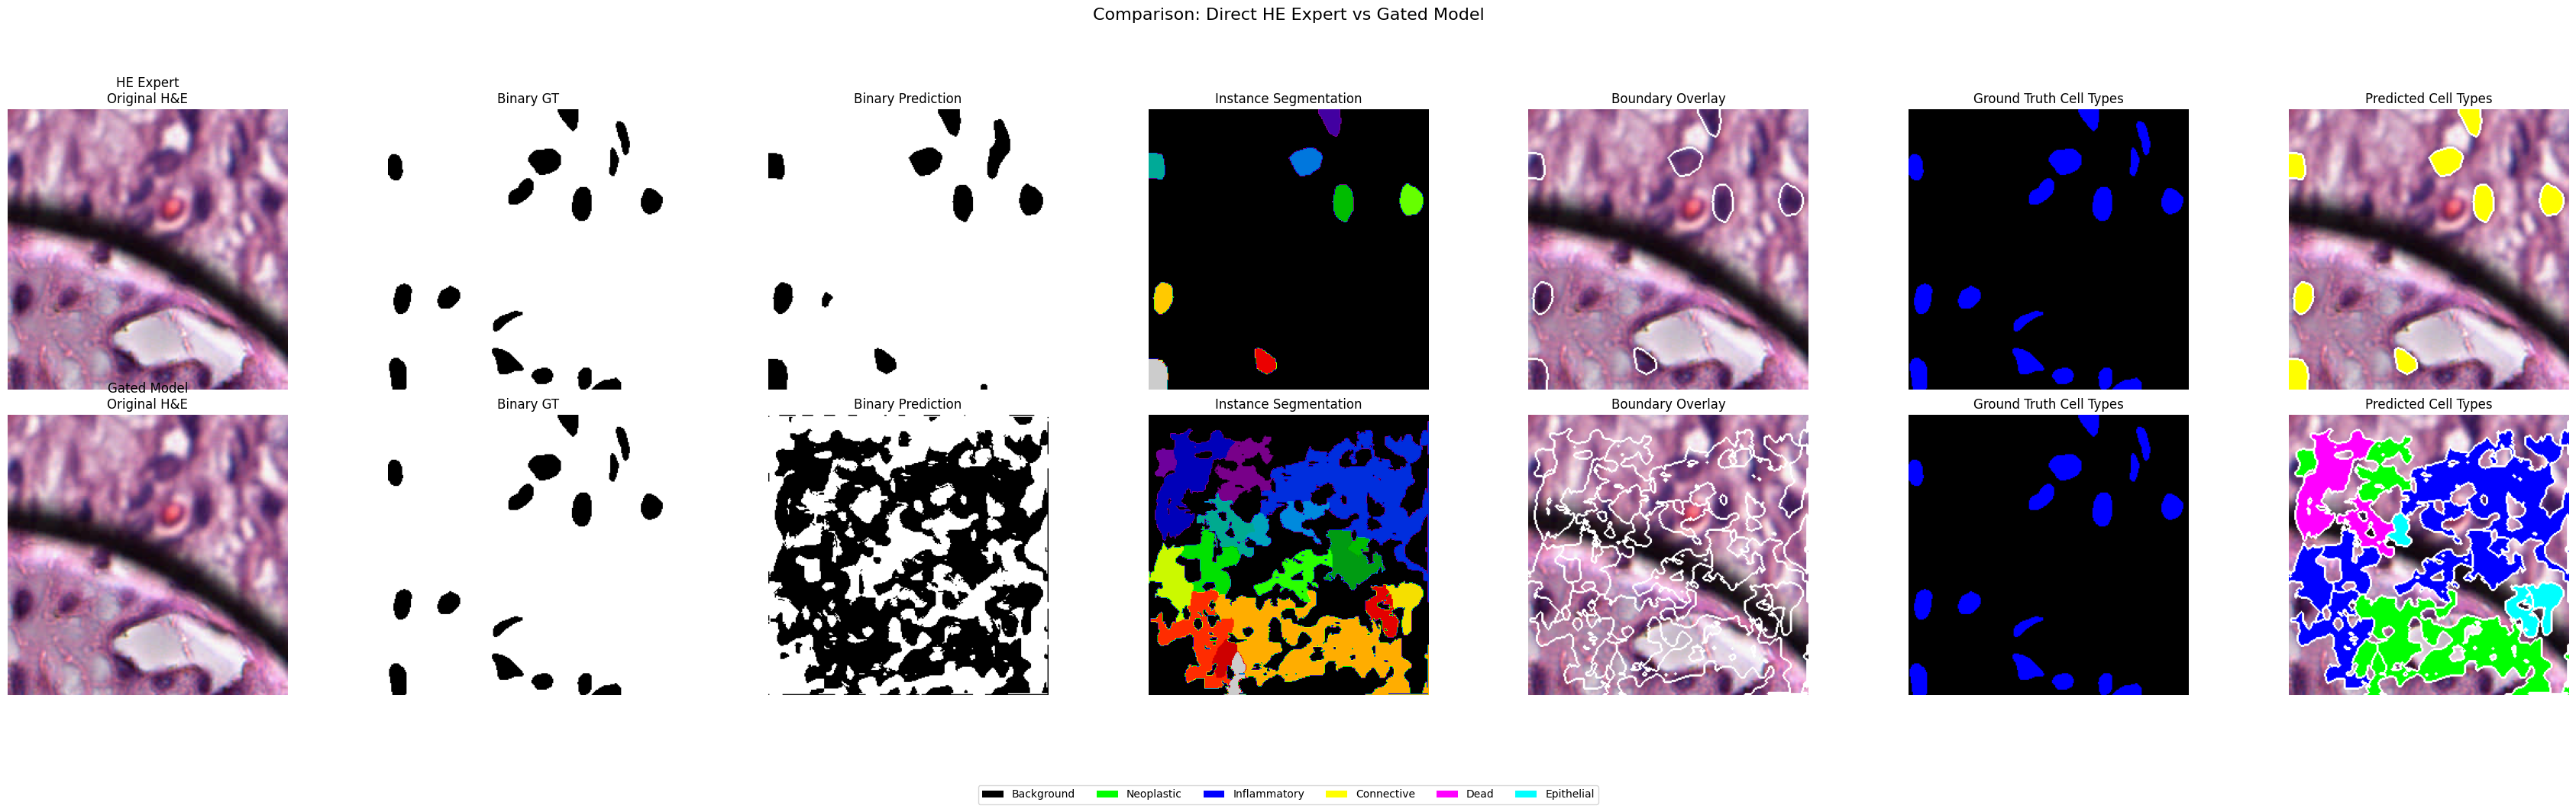


HE Expert Statistics:
Number of detected cells: 8

HE Expert Cell type distribution:
Connective: 8 cells

Gated Model Statistics:
Number of detected cells: 18

Gated Model Cell type distribution:
Neoplastic: 5 cells
Dead: 2 cells
Inflammatory: 8 cells
Epithelial: 3 cells


In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.segmentation import find_boundaries
import os
from cell_segmentation.utils.post_proc_vitaminp import DetectionCellPostProcessor

def compare_gating_vs_direct(base_dir: str, device: str = 'cuda'):
    """
    Compare predictions from direct HE expert vs gated model
    """
    # Initialize both models
    he_model = HEExpert().to(device)
    gated_model = MultiModalExpertModel().to(device)
    
    # Load HE expert checkpoint
    he_checkpoint_path = os.path.join(base_dir, 'he', 'best_model.pt')
    if os.path.exists(he_checkpoint_path):
        checkpoint = torch.load(he_checkpoint_path)
        he_model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded HE expert checkpoint from: {he_checkpoint_path}")
    else:
        raise FileNotFoundError(f"No HE checkpoint found at {he_checkpoint_path}")
        
    # Load gated model checkpoint
    gated_checkpoint_path = os.path.join(base_dir, 'gating', 'best_model.pt')
    if os.path.exists(gated_checkpoint_path):
        checkpoint = torch.load(gated_checkpoint_path)
        gated_model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded gated model checkpoint from: {gated_checkpoint_path}")
    else:
        raise FileNotFoundError(f"No gating checkpoint found at {gated_checkpoint_path}")

    # Create dataset manager and get sample
    manager = ModularDatasetManager()
    datasets = manager.setup_datasets()
    test_loader = manager.get_dataloader('pannuke', 'test', batch_size=1)

    random_idx = np.random.randint(0, len(test_loader.dataset))
    print(f"Analyzing random sample {random_idx} out of {len(test_loader.dataset)} samples")

    random_sample = test_loader.dataset[random_idx]
    batch = test_loader.collate_fn([random_sample])

    # Define class names and colors
    class_names = {
        0: "Background", 1: "Neoplastic", 2: "Inflammatory",
        3: "Connective", 4: "Dead", 5: "Epithelial"
    }
    type_colors = {
        0: 'black', 1: '#00FF00', 2: 'blue',
        3: 'yellow', 4: 'magenta', 5: 'cyan'
    }

    # Get predictions from both models
    he_model.eval()
    gated_model.eval()
    cell_post_processor = DetectionCellPostProcessor(nr_types=6, magnification=40)
    
    with torch.no_grad():
        images = batch['image'].to(device)
        
        # Get HE expert predictions
        he_outputs = he_model(images)
        
        # Get gated model predictions
        gated_outputs = gated_model(images)
        gate_probs = F.softmax(gated_outputs['gate_weights'], dim=1)
        print("\nGating Probabilities:")
        print(f"MIF Expert: {gate_probs[0,0]:.3f}")
        print(f"HE Expert:  {gate_probs[0,1]:.3f}")
        
        # Process predictions for both models
        he_pred_map = np.concatenate([
            torch.argmax(he_outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
            torch.argmax(he_outputs['cell_mask'][0], dim=0).cpu().numpy()[..., None],
            he_outputs['cell_hv'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)
        
        gated_pred_map = np.concatenate([
            torch.argmax(gated_outputs['cell_types'][0], dim=0).cpu().numpy()[..., None],
            torch.argmax(gated_outputs['segmentation'][0], dim=0).cpu().numpy()[..., None],
            gated_outputs['hv_maps'][0].cpu().numpy().transpose(1, 2, 0)
        ], axis=-1)

        he_instance_map, he_type_pred = cell_post_processor.post_process_cell_segmentation(he_pred_map)
        gated_instance_map, gated_type_pred = cell_post_processor.post_process_cell_segmentation(gated_pred_map)
        
        # Create visualization with two rows (HE expert and Gated)
        fig, axes = plt.subplots(2, 7, figsize=(35, 10))
        plt.suptitle('Comparison: Direct HE Expert vs Gated Model', y=1.05, fontsize=16)
        
        # Helper function for visualization
        def visualize_row(row_idx, instance_map, type_pred, outputs, title_prefix):
            # Original image
            img_display = images[0].cpu().numpy()
            img_display = np.moveaxis(img_display, 0, -1)
            img_display = np.clip((img_display - img_display.min()) / 
                                (img_display.max() - img_display.min() + 1e-8), 0, 1)
            axes[row_idx,0].imshow(img_display)
            axes[row_idx,0].set_title(f'{title_prefix}\nOriginal H&E')
            axes[row_idx,0].axis('off')
            
            # Binary Ground Truth
            if 'masks' in batch['targets'] and 'cell' in batch['targets']['masks']:
                binary_gt = batch['targets']['masks']['cell'][0].squeeze().cpu().numpy()
                axes[row_idx,1].imshow(binary_gt > 0, cmap='binary')
                axes[row_idx,1].set_title('Binary GT')
            else:
                axes[row_idx,1].set_title('Binary GT (Not Available)')
            axes[row_idx,1].axis('off')
            
            # Binary Prediction
            if row_idx == 0:  # HE expert
                binary_pred = torch.softmax(outputs['cell_mask'][0], dim=0)[1].cpu().numpy()
            else:  # Gated model
                binary_pred = torch.softmax(outputs['segmentation'][0], dim=0)[1].cpu().numpy()
            axes[row_idx,2].imshow(binary_pred > 0.5, cmap='binary')
            axes[row_idx,2].set_title('Binary Prediction')
            axes[row_idx,2].axis('off')
            
            # Instance Segmentation
            axes[row_idx,3].imshow(instance_map, cmap='nipy_spectral')
            axes[row_idx,3].set_title('Instance Segmentation')
            axes[row_idx,3].axis('off')
            
            # Boundary Overlay
            boundaries = find_boundaries(instance_map, mode='thick')
            overlay = img_display.copy()
            overlay[boundaries] = [1, 1, 1]
            axes[row_idx,4].imshow(overlay)
            axes[row_idx,4].set_title('Boundary Overlay')
            axes[row_idx,4].axis('off')
            
            # Ground Truth Cell Types
            if 'semantic' in batch['targets'] and 'cell_types' in batch['targets']['semantic']:
                cell_types = batch['targets']['semantic']['cell_types'][0].cpu().numpy()
                cell_mask = batch['targets']['masks']['cell'][0].squeeze().cpu().numpy()
                gt_type_map = np.zeros_like(cell_mask)
                active_type = np.argmax(cell_types)
                gt_type_map[cell_mask > 0] = active_type
                gt_type_rgb = np.zeros((*gt_type_map.shape, 3))
                for type_id in range(len(class_names)):
                    color = np.array(mcolors.to_rgb(type_colors[type_id]))
                    gt_type_rgb[gt_type_map == type_id] = color
                axes[row_idx,5].imshow(gt_type_rgb)
                axes[row_idx,5].set_title('Ground Truth Cell Types')
            else:
                axes[row_idx,5].set_title('Ground Truth Cell Types (Not Available)')
            axes[row_idx,5].axis('off')
            
            # Predicted Cell Types
            pred_type_overlay = img_display.copy()
            for cell_id, cell_info in type_pred.items():
                cell_mask = instance_map == cell_id
                cell_type = cell_info['type']
                pred_type_overlay[cell_mask] = np.array(mcolors.to_rgb(type_colors[cell_type]))
            pred_type_overlay[boundaries] = [1, 1, 1]
            axes[row_idx,6].imshow(pred_type_overlay)
            axes[row_idx,6].set_title('Predicted Cell Types')
            axes[row_idx,6].axis('off')
        
        # Visualize both rows
        visualize_row(0, he_instance_map, he_type_pred, he_outputs, "HE Expert")
        visualize_row(1, gated_instance_map, gated_type_pred, gated_outputs, "Gated Model")
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none', 
                         label=class_names[i]) for i, color in type_colors.items()]
        fig.legend(handles=legend_elements, loc='lower center', 
                  ncol=len(class_names), bbox_to_anchor=(0.5, 0))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()

        # Print statistics for both models
        print("\nHE Expert Statistics:")
        print(f"Number of detected cells: {len(he_type_pred)}")
        he_type_counts = {}
        for cell_id, cell_info in he_type_pred.items():
            cell_type = cell_info['type']
            he_type_counts[cell_type] = he_type_counts.get(cell_type, 0) + 1
        
        print("\nHE Expert Cell type distribution:")
        for type_id, count in he_type_counts.items():
            print(f"{class_names[type_id]}: {count} cells")
            
        print("\nGated Model Statistics:")
        print(f"Number of detected cells: {len(gated_type_pred)}")
        gated_type_counts = {}
        for cell_id, cell_info in gated_type_pred.items():
            cell_type = cell_info['type']
            gated_type_counts[cell_type] = gated_type_counts.get(cell_type, 0) + 1
        
        print("\nGated Model Cell type distribution:")
        for type_id, count in gated_type_counts.items():
            print(f"{class_names[type_id]}: {count} cells")

        return he_model, gated_model, test_loader

# Run the visualization
if __name__ == "__main__":
    base_dir = 'checkpoints_separate'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        he_model, gated_model, loader = compare_gating_vs_direct(base_dir, device)
    except Exception as e:
        print(f"Error occurred: {str(e)}")